In [1]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from IPython.display import Image
import copy
import warnings
import re
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
from matplotlib.ticker import MaxNLocator


import matplotlib
font = {
        'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)
df=pd.read_csv(r'../robustness/robustness.csv', header=None).T
df.columns = df.iloc[0] # Set new column names
plt.figure(figsize=(12,10))
# plt.xticks(rotation=45)
# sns.set_palette("RdBu")
# sns.set_palette("Dark2_r")
sns.set_palette("CMRmap_r")
sns.set_style()

class Figure:
    
    
    def __init__(self, sheet_path=r'./../Complete_Sheet.xlsx',
                sheet_names=['10 Min', '30 Min', '60 Min', '240 Min','10 Min - F1 Score', '60 Min - F1 Score', 'meta-features']):
        self.sheet = pd.read_excel(sheet_path,
                              na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
                              sheet_name=sheet_names)
    def get_sheet(self):
        return self.sheet
    
    def check(self):
        return pd.DataFrame({ 'diff': self.diff, 'va11': self.var1, 'var2': self.var2 })
        
    def compare_acc_scatter(self, var1, var2, x_label, y_label, title,
                           legend_missing='Failed Run', legend_negative='-ve Dif',
                           legend_zero='Zero Dif', legend_positive='+ve Dif',
                           fig_size = (8, 8), legend_ncols=4, legend_x_shift=-0.015, y_limit=None,
                           x_axis_grid=False, divide_data=False):
       
        font_size=16
        self.var1, self.var2 = var1.reset_index(drop=True).fillna(0), var2.reset_index(drop=True).fillna(0)
        argsort = (self.var1 - self.var2).argsort()
        self.var1 = self.var1[argsort].reset_index(drop=True)
        self.var2 = self.var2[argsort].reset_index(drop=True)

        self.diff = (self.var1 - self.var2).reset_index(drop=True)
        y_limit = [1.1* min(self.diff), 1.1 * max(self.diff)]
        if y_limit[0] == 0:
            y_limit[0] = -0.1 * y_limit[1]
        fig, ax = plt.subplots(figsize=fig_size)

        dot_size=60
        yy = self.diff[(self.diff <= -0.01) & (self.var1 != 0.0) & (self.var2 != 0)]
        print('Average and Max loss = {}, and {},  from {} datasets'.format(round(100 * yy.mean(), 1), round(100 * yy.min(), 1), yy.size))
        loss_mean, loss_max, loss_datasets = round(100 * yy.mean(), 1), round(100 * yy.min(), 1), yy.size
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'red',
               marker ='v',
               label = 'Negative',
                  s=dot_size)

        yy = self.diff[(self.diff > -0.01) & (self.diff < 0.01) & (self.var1 != 0.0) & (self.var2 != 0)]
        print(' {} datasets have the same performance'.format(yy.size))
        nogain_datasets = yy.size
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'blue',
               marker ='.',
               label = 'Same',
                  s=dot_size*1.5)

        yy = self.diff[(self.diff >= 0.01)  & (self.var1 != 0.0) & (self.var2 != 0)]
        print('Average and Max gain = {} and {},  from {} datasets'.format(round(100 * yy.mean(), 1), round(100 * yy.max(), 1) ,yy.size))
        gain_mean, gain_max, gain_datasets = round(100 * yy.mean(), 1), round(100 * yy.max(), 1) ,yy.size
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'green',
               marker ='^',
               label = 'Positive',
                  s=dot_size)

        yy = self.diff[(self.var1 == 0.0) | (self.var2 == 0)]
        yy_right = self.diff[(self.var1 != 0.0) & (self.var2 == 0)]
        yy_left = self.diff[(self.var1 == 0.0) & (self.var2 != 0)]
        yy_mid = self.diff[(self.var1 == 0.0) & (self.var2 == 0)]
        print('{} datasets failed to run on the left side only'.format( yy_right.size))
        print('{} datasets failed to run on the right side only'.format( yy_left.size))
        print('{} datasets failed to run on the both sides'.format( yy_mid.size))
        print(gain_mean, ' & ', gain_max, ' & ', gain_datasets, ' & ', nogain_datasets, ' & ', loss_datasets, ' & ', loss_mean, ' & ', loss_max)
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'darkorange',
               marker ='x',
               label = 'Failed',
                  s=dot_size)

        l = ax.legend( ncol=legend_ncols, bbox_to_anchor=(legend_x_shift, 1), loc='lower left', fontsize=font_size)
        
        plt.xlabel(x_label, fontsize=font_size*1.2)
        plt.ylabel(y_label, fontsize=font_size*1.2)
        ax.yaxis.grid() # horizontal lines
        if x_axis_grid:
            ax.xaxis.grid()
        plt.ylim(y_limit)
        plt.xlim([-1,1+self.var1.shape[0]])
        plt.xticks(np.arange(0, 1+self.var1.shape[0], 10), fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.title(label = title, pad = 40, fontsize=font_size)
        plt.tight_layout()
        #plt.savefig('./search_space_figs/' + title.replace(' ', '_') + '.pdf', format='pdf')
        plt.savefig('./bench_figs/' + re.sub(r'\W+', '', title) + '.pdf', format='pdf', bbox_inches = "tight")
        plt.show()
        return
    
    def compare_acc_bar( self, acc1, acc2, x_label, y_label, title,
                           legend_missing='Failed Run', legend_negative='Negative Difference',
                           legend_zero='Zero Difference', legend_positive='Positive Difference',
                           fig_size = (8, 8), legend_ncols=4, legend_x_shift=0, y_limit=None,
                           x_axis_grid=False, divide_data=False):
       
        result = copy.deepcopy(self.sheet)

        no_improved_datasets = [[np.array([]), np.array([]), np.array([]), np.array([])],
                                [np.array([]), np.array([]), np.array([]), np.array([])],
                                [np.array([]), np.array([]), np.array([]), np.array([])],
                                [np.array([]), np.array([]), np.array([]), np.array([])]]
        return_array = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
        indxs = []
        for time in ['10 Min', '30 Min', '60 Min', '240 Min']:
            var1 = result[time].loc[:, acc1]#.reset_index(drop=True).fillna(0)
            var2 = result[time].loc[:, acc2]#.reset_index(drop=True).fillna(0)
#             argsort = (var1 - var2).argsort()
#             var1 = var1[argsort]#.reset_index(drop=True)
#             var2 = var2[argsort]#.reset_index(drop=True)
            diff = (var1 - var2)#.reset_index(drop=True)
            indxs.append(np.array(np.where(diff>0.01)))
        
        # 3 is in the back then 2 then 1 then 0 is in the front
#         print(indxs[0].shape)
#         no_improved_datasets[0][0] = indxs[0].shape[1]
#         no_improved_datasets[0][1] = np.array(np.intersect1d(indxs[0], indxs[1])).shape[0]
#         no_improved_datasets[0][2] = np.array(np.intersect1d(np.array(np.intersect1d(indxs[0], indxs[1])), indxs[2])).shape[0]
#         no_improved_datasets[0][3] = np.array(np.intersect1d(np.array(np.intersect1d(np.array(np.intersect1d(indxs[0], indxs[1])), indxs[2])), indxs[3])).shape[0]
        
#         no_improved_datasets[1][1] = indxs[1].shape[1]
#         no_improved_datasets[1][2] = no_improved_datasets[0][2] + np.array(np.intersect1d(indxs[1], np.setdiff1d(indxs[2], indxs[0]))).shape[0]
#         no_improved_datasets[1][3] = no_improved_datasets[0][3] + np.array(np.intersect1d(np.array(np.intersect1d(indxs[1], np.setdiff1d(indxs[2], indxs[0]))), np.setdiff1d(indxs[3], indxs[0]))).shape[0]
                
#         no_improved_datasets[2][3] = no_improved_datasets[0][3] + no_improved_datasets[1][3] + np.array(np.intersect1d(np.setdiff1d(np.setdiff1d(indxs[3], indxs[0]), indxs[1]), np.array(np.intersect1d(np.array(np.intersect1d(indxs[1], np.setdiff1d(indxs[2], indxs[0]))), np.setdiff1d(indxs[3], indxs[0]))))).shape[0]
#         no_improved_datasets[2][2] = indxs[2].shape[1]
                
#         no_improved_datasets[3][3] = indxs[3].shape[1]
#         indxs = indxs[::-1]
#         indxs[2],indxs[3] = indxs[3],indxs[2]

        no_improved_datasets[0][0] = indxs[0]
        no_improved_datasets[0][1] = np.array(np.intersect1d(indxs[0], indxs[1]))
        no_improved_datasets[0][2] = np.array(np.intersect1d(no_improved_datasets[0][1], indxs[2]))
        no_improved_datasets[0][3] = np.array(np.intersect1d(no_improved_datasets[0][2], indxs[3]))
        
        no_improved_datasets[1][1] = indxs[1]
        no_improved_datasets[1][2] = np.concatenate((no_improved_datasets[0][2] , np.array(np.intersect1d(no_improved_datasets[1][1], np.setdiff1d(indxs[2], no_improved_datasets[0][2])))))
        no_improved_datasets[1][3] = np.concatenate((no_improved_datasets[0][3] , np.array(np.intersect1d(no_improved_datasets[1][2], np.setdiff1d(indxs[3], no_improved_datasets[0][3])))))
        
        no_improved_datasets[2][2] = indxs[2]
        no_improved_datasets[2][3] = np.concatenate((no_improved_datasets[1][3] , np.array(np.intersect1d(np.setdiff1d(indxs[2], no_improved_datasets[1][2]), np.setdiff1d(indxs[3], no_improved_datasets[1][3])))))
                
        no_improved_datasets[3][3] = indxs[3]
        
        print(no_improved_datasets[0][3])
        for i in range(4):
            for j in range(4):
                if len(no_improved_datasets[i][j]) == 0:
                    continue
                return_array[i][j] = no_improved_datasets[i][j].size

        no_improved_datasets = return_array
        
        y_lim = (1 + max(map(max, no_improved_datasets))//5) * 5
        #no_improved_datasets = [[20, 20, 20, 20], [40, 40, 40, 40], [40, 40, 40, 40], [50, 50, 50, 50]]
        fig, ax = plt.subplots(figsize=fig_size)
#         colors=['#2f4b7c','#a05195','#f95d6a','#ffa600']
        for k in range(4-1,-1,-1):
#             print(no_improved_datasets[k])
            plt.bar(np.arange(4), np.array(no_improved_datasets[k]))#, color=colors[k])#, color=['red', 'green', 'blue', 'cyan'])

        ax.set(xlabel='Time Budget', ylabel='No. of data sets')#,title=title)
        ax.yaxis.grid()
        #plt.xlim([-1, 4])
        
        #plt.yticks(np.array(0, y_lim, 5))
        #plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
        ax.set_xticklabels(['','10 Min', '30 Min', '60 Min', '240 Min'])
        #plt.xticks(rotation=70)
        title = ''.join(title.splitlines())
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.savefig('./bench_figs/' + title.replace(' ', '_').replace('.', '') + '.pdf', format='pdf', bbox_inches = "tight")
        plt.show()
       
            
            
    def draw_heat_map(self, tool_acc, tool_name, fig_size=None, divide_data=False):
        time_budgets =['10 Min', '30 Min', '60 Min', '240 Min']


        result = copy.deepcopy(self.sheet)
        for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
             'Small # features and Large # instances', 'Large # features and Small # instances',
             'Large # (features and instances)'],
             [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
             result['meta-features'].nr_classes >2,
             (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
              (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
             (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
              (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
             ]):
            result = copy.deepcopy(self.sheet)
            for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
                result[tt] = result[tt][condition]


            heat_df = pd.DataFrame()
            for t in time_budgets:
                heat_df[t] = result[t].loc[:, tool_acc].value_counts()
            
            matrix = heat_df.fillna(0).values.T

            classifiers = list(heat_df.index)
            font_sizet = 17
            plt.figure(figsize=fig_size)
            ax=sns.heatmap(matrix.astype(float), cmap=sns.cubehelix_palette(500, light=0.95, dark=0.15), square=True, annot=True, vmin=0., vmax=50, cbar=True, linewidth=2 , edgecolor=".2")
#             fig, ax = plt.subplots(figsize=fig_size)
#             im = ax.imshow(matrix)#, cmap='Oranges')
#             plt.colorbar(im)
            # We want to show all ticks...
            ax.set_xticks(np.arange(len(classifiers))+0.5)
            ax.set_yticks(np.arange(len(time_budgets))+0.5)
            # ... and label them with the respective list entries
            ax.set_xticklabels(classifiers)#, fontsize=font_size)
            ax.set_yticklabels(time_budgets)#, fontsize=font_size)
            plt.yticks(rotation=90)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
#             for i in range(len(time_budgets)):
#                 for j in range(len(classifiers)):
#                     text = ax.text(j, i, int(matrix[i, j]),
#                                    ha="center", va="center", color="black")
            
            plt.yticks(rotation=45)
            title = "Classifiers' Heat map ("+ tool_name + ")"
#             ax.set_title(title)#, fontsize=font_size)
            bottom, top = ax.get_ylim()
#             ax.set_ylim(bottom + 0.5, top - 0.5)
#             fig.tight_layout()
            plt.savefig('./bench_figs/' + title.replace(' ', '_').replace('.', '') + '.pdf', format='pdf', bbox_inches = "tight")
#             plt.show()
            if not divide_data:
                return
        
        
    def draw_heat_map2(self, t, tools, tools_names, fig_size=None, divide_data=False):
        time_budgets =['10 Min', '30 Min', '60 Min', '240 Min']


        result = copy.deepcopy(self.sheet)
        for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
             'Small # features and Large # instances', 'Large # features and Small # instances',
             'Large # (features and instances)'],
             [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
             result['meta-features'].nr_classes >2,
             (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
              (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
             (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
              (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
             ]):
            result = copy.deepcopy(self.sheet)
            for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
                result[tt] = result[tt][condition]


            heat_df = pd.DataFrame()
            for tool in tools:
                for tool2 in tools:
                    heat_df.loc[tool,tool2] = (result[t].loc[:, tool].subtract(result[t].loc[:, tool2]) > 0.01).sum()
#             display(heat_df)
            matrix = heat_df.fillna(0).values
            plt.figure(figsize=fig_size)
            ax=sns.heatmap(matrix.astype(float), cmap=sns.cubehelix_palette(500, light=0.95, dark=0.15), square=True, annot=True, vmin=0., vmax=30, cbar=True, linewidth=2 , edgecolor=".2")
#             fig, ax = plt.subplots(figsize=fig_size)
            
#             im = ax.imshow(matrix)#, cmap='Oranges')
#             plt.colorbar(im)
            # We want to show all ticks...
            ax.set_xticks(np.arange(len(tools_names))+0.5)
            ax.set_yticks(np.arange(len(tools_names))+0.5)
            plt.yticks(rotation=90)
            # ... and label them with the respective list entries
            ax.set_xticklabels(tools_names)
            ax.set_yticklabels(tools_names)
            plt.xlabel("Loses")
            plt.ylabel("Wins")

            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")

#             Loop over data dimensions and create text annotations.
#             for i in range(len(tools_names)):
#                 for j in range(len(tools_names)):
#                     text = ax.text(j, i, int(matrix[i, j]),
#                                    ha="center", va="center")#, color="white")
            plt.yticks(rotation=45)
            title = "Frameworks' Heat map ("+ t + ")"
#             ax.set_title(title)
            bottom, top = ax.get_ylim()
#             ax.set_ylim(bottom + 0.5, top - 0.5)
#             fig.tight_layout()
            plt.savefig('./bench_figs/' + title.replace(' ', '_').replace('.', '') + '.pdf', format='pdf', bbox_inches = "tight")
#             plt.show()
            if not divide_data:
                return

            
fig = Figure()

<Figure size 864x720 with 0 Axes>

In [110]:
df.columns.to_list()

['TPOT',
 'Autosklearn-v',
 'Autosklearn-e',
 'Autosklearn-m',
 'Autosklearn',
 'ATM',
 'SmartML-m',
 'SmartML-e',
 'Recipe',
 'Autoweka']

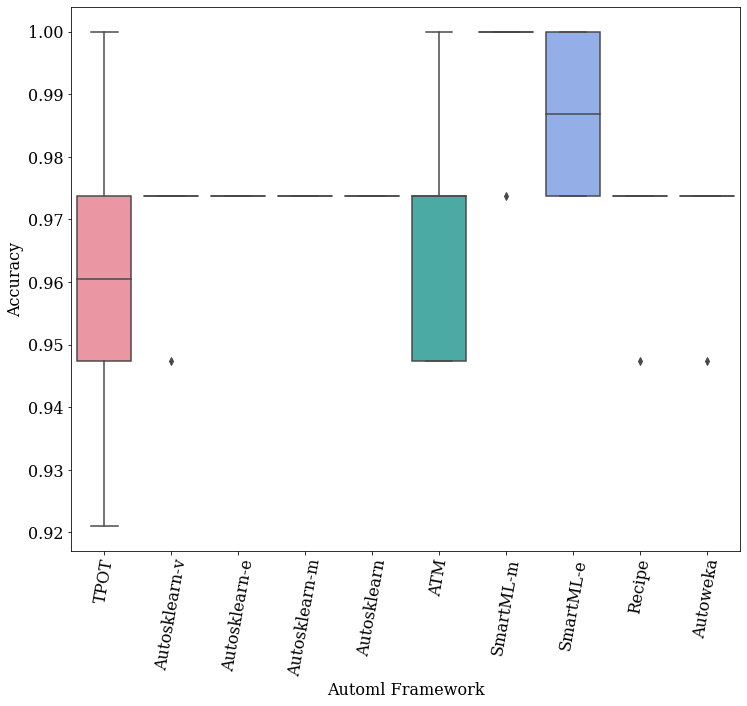

In [111]:
import matplotlib
font = {
        'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)
df=pd.read_csv(r'../robustness/robustness.csv', header=None).T
df.columns = df.iloc[0] # Set new column names
df.drop(0,inplace=True) 
plt.figure(figsize=(12,10))
# plt.xticks(rotation=45)
#sns.set_palette("RdBu")
#sns.set_style()
 
# sns.violinplot(data=df,orient="v",inner='box', scale='width',order=df.columns.to_list(),cut=0, linewidth=2)
ax = sns.boxplot(data=df)
h = plt.gcf()
plt.ylabel("Accuracy")
plt.xlabel("Automl Framework")
# plt.xticks(rotation=60)
ax.tick_params(axis='x', rotation=80)
h.savefig("./bench_figs/robustness.pdf" ,bbox_inches = 'tight',pad_inches = 0, format='pdf')

In [64]:
# df=pd.read_csv(r'../robustness/robustness.csv')

# df=df[model_list]
# df.columns=["AB","ET","RF","GB","DT","SVM"]
# plt.figure(figsize=(12,10))
# # plt.xticks(rotation=45)
# sns.set_palette("RdBu")
# sns.set_style("darkgrid")
 
# sns.violinplot(data=df,orient="v",inner='box', scale='width',order=[ "SVM", "AB", "GB","ET","DT","RF"],cut=0, linewidth=2)
# h = plt.gcf()
# plt.ylabel("Standard Deviations")
# plt.xlabel("Classifiers");
# h.savefig("../output_plots/standard_deviations.pdf" ,bbox_inches = 'tight',pad_inches = 0, format='pdf')

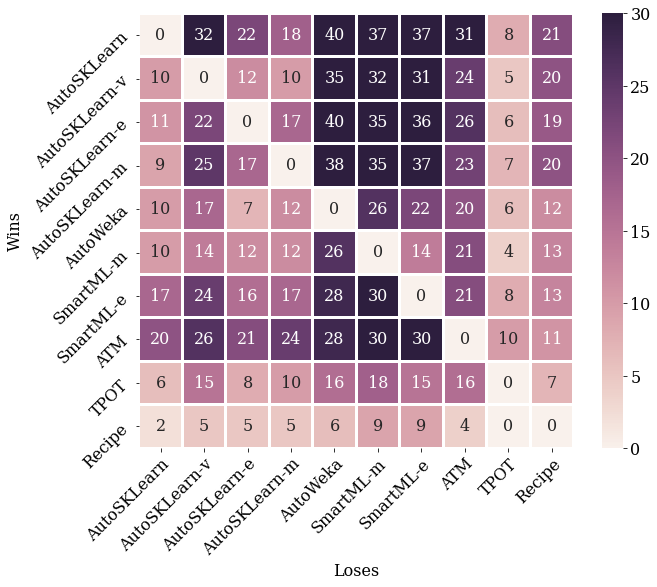

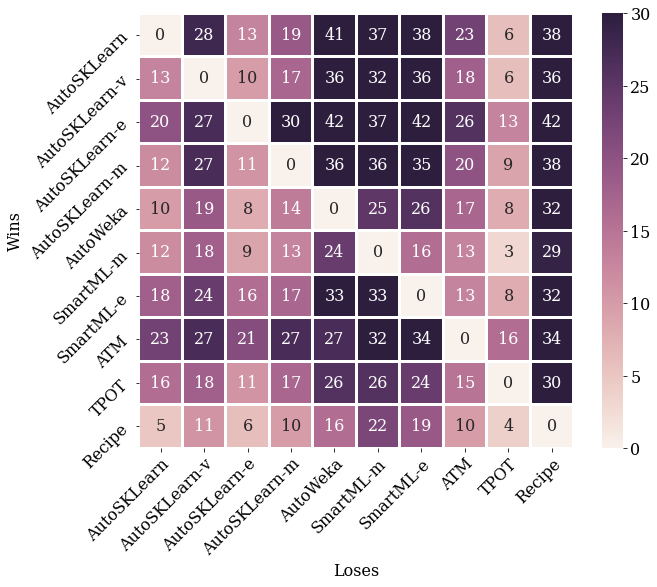

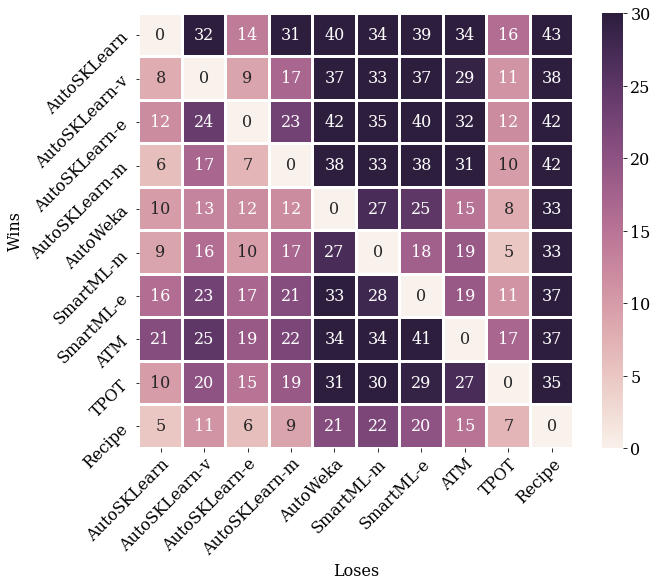

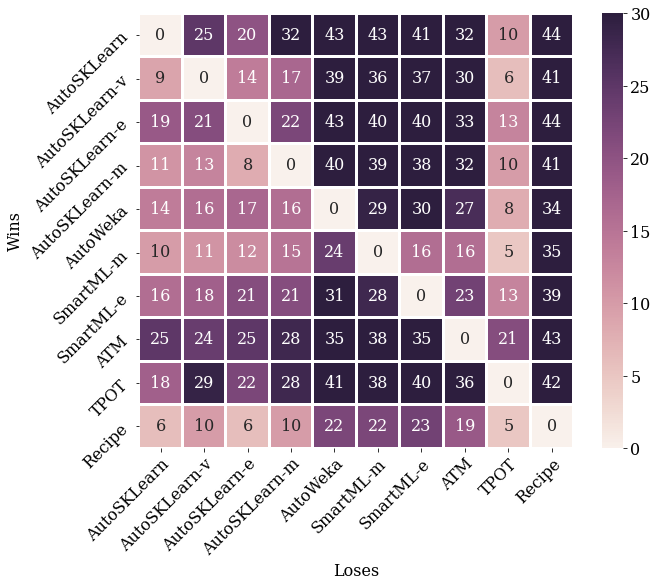

In [65]:
tools = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m', 'AutoWeka', 'SmartML-m', 'SmartML-e', 'ATM', 'TPOT', 'Recipe']
tools_acc = ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'smartml_valid_acc', 'smartml_e_valid_acc', 'atm_acc', 'tpot_accuracy_mean', 'recipe_test_acc']
models = ['sklearn_model_1', 'sklearn_v_model_1', 'sklearn_e_model_1', 'sklearn_m_model_1',
            'autoweka_model_1', 'smartml_model', 'ATM_classifier', 'tpot_classifier']

fig = Figure()
for t in ['10 Min', '30 Min', '60 Min', '240 Min']:
    fig.draw_heat_map2(t, tools_acc, tools, fig_size=(10,8), divide_data=False)

# How often each tool succeeded to deliver a pipeline within the given time budget?

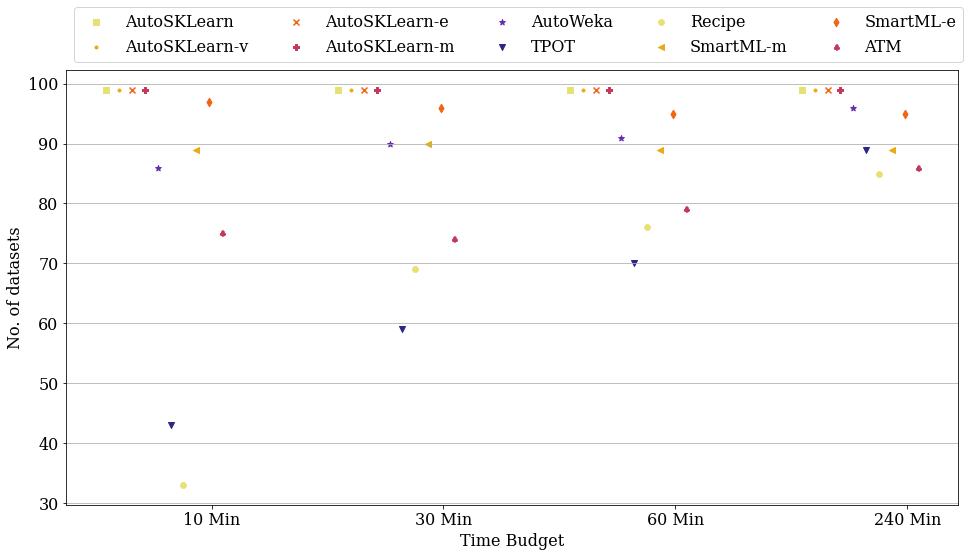

In [66]:
sheet_path = r'./../Complete_Sheet.xlsx'
result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min', '30 Min', '60 Min', '240 Min','10 Min - F1 Score', '60 Min - F1 Score', 'meta-features'])
experiment_time = ['10 Min', '30 Min', '60 Min', '240 Min']
frameworks = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML-m', 'SmartML-e', 'ATM']
#colors        = ['seagreen', 'red', 'orchid', 'orange']
gray_colors = itertools.cycle(['silver', 'gainsboro', 'gray', 'lightgrey', 'darkgray'])

# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '240 Min', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
#         result[tt] = result[tt][condition]
autoSKLearn = [np.sum(result['10 Min'].sklearn_accuracy_mean> 0),
            np.sum(result['30 Min'].sklearn_accuracy_mean> 0),
            np.sum(result['60 Min'].sklearn_accuracy_mean> 0),
            np.sum(result['240 Min'].sklearn_accuracy_mean> 0)]
autoSKLearn_v = [np.sum(result['10 Min'].sklearn_v_accuracy_mean> 0),
            np.sum(result['30 Min'].sklearn_v_accuracy_mean> 0),
            np.sum(result['60 Min'].sklearn_v_accuracy_mean> 0),
            np.sum(result['240 Min'].sklearn_v_accuracy_mean> 0)]
autoSKLearn_e = [np.sum(result['10 Min'].sklearn_e_accuracy_mean> 0),
            np.sum(result['30 Min'].sklearn_e_accuracy_mean> 0),
            np.sum(result['60 Min'].sklearn_e_accuracy_mean> 0),
            np.sum(result['240 Min'].sklearn_e_accuracy_mean> 0)]
autoSKLearn_m = [np.sum(result['10 Min'].sklearn_m_accuracy_mean> 0),
            np.sum(result['30 Min'].sklearn_m_accuracy_mean> 0),
            np.sum(result['60 Min'].sklearn_m_accuracy_mean> 0),
            np.sum(result['240 Min'].sklearn_m_accuracy_mean> 0)]
autoweka = [np.sum(result['10 Min'].autoweka_accuracy_mean> 0),
            np.sum(result['30 Min'].autoweka_accuracy_mean> 0),
            np.sum(result['60 Min'].autoweka_accuracy_mean> 0),
            np.sum(result['240 Min'].autoweka_accuracy_mean> 0)]
TPOT = [np.sum(result['10 Min'].tpot_accuracy_mean> 0),
            np.sum(result['30 Min'].tpot_accuracy_mean> 0),
            np.sum(result['60 Min'].tpot_accuracy_mean> 0),
            np.sum(result['240 Min'].tpot_accuracy_mean> 0)]
Recipe = [np.sum(result['10 Min'].recipe_test_acc> 0),
            np.sum(result['30 Min'].recipe_test_acc> 0),
            np.sum(result['60 Min'].recipe_test_acc> 0),
            np.sum(result['240 Min'].recipe_test_acc> 0)]
SmartML_v = [np.sum(result['10 Min'].smartml_valid_acc> 0),
            np.sum(result['30 Min'].smartml_valid_acc> 0),
            np.sum(result['60 Min'].smartml_valid_acc> 0),
            np.sum(result['240 Min'].smartml_valid_acc> 0)]
SmartML_e = [np.sum(result['10 Min'].smartml_e_valid_acc> 0),
            np.sum(result['30 Min'].smartml_e_valid_acc> 0),
            np.sum(result['60 Min'].smartml_e_valid_acc> 0),
            np.sum(result['240 Min'].smartml_e_valid_acc> 0)]
atm = [np.sum(result['10 Min'].atm_acc> 0),
            np.sum(result['30 Min'].atm_acc> 0),
            np.sum(result['60 Min'].atm_acc> 0),
            np.sum(result['240 Min'].atm_acc> 0)]
numerical = [autoSKLearn,
             autoSKLearn_v,
             autoSKLearn_e,
             autoSKLearn_m,
             autoweka,
             TPOT,
             Recipe,
             SmartML,
             SmartML_e,
             atm]
#rint(np.sum(result['10 Min'].autoweka_accuracy_mean > 0))
#rint((result['10 Min'].autoweka_accuracy_mean > 0).to_string())
number_groups = len(frameworks) 
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit$'])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(16,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(len(experiment_time)) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(len(experiment_time)) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(experiment_time)
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(-0.0, 1), loc='lower left')
x_label, y_label='Time Budget', 'No. of datasets'
font_size=17
ax.yaxis.grid() # horizontal lines
plt.xlabel(x_label)#, fontsize=font_size)
plt.ylabel(y_label)#, fontsize=font_size)
# plt.title(label = 'No. of datasets in which the tool has succeeded to return a model', pad = 45, fontsize=font_size)
plt.savefig('./bench_figs/' + 'No of times the tool has succeeded to return a model'.replace(' ', '_') + '.pdf', format='pdf')
plt.show()

# How many times each tool has achieved the best performance?
# And what is the effect of time budget increasing over each tool?
# Does the impact of Meta-Learning, Ensembling, Genetic Based Optimization and Bayesian Based Optimization increase or decrease by time budget increasing?

In [10]:
sheet_path = r'./../Complete_Sheet.xlsx'
result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min', '30 Min', '60 Min', '240 Min','10 Min - F1 Score', '60 Min - F1 Score', 'meta-features'])
experiment_time = ['10 Min - F1 Score', '60 Min - F1 Score']
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML-m', 'ATM']
types= ['AutoSKLearn', 'AutoSKLearn_v', 'AutoSKLearn_e', 'AutoSKLearn_m','AutoWeka', 'TPot', 'Recipe', 'SmartML_v', 'ATM']
# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '240 Min', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
#         result[tt] = result[tt][condition]

T=[]


for t in experiment_time:
    total = [0,0,0,0,0,0,0,0,0]
    for i in result[t][types[0]].index:
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = ['10 Min', '240 Min']
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))
y_lim = (1 + max(map(max, s))//5) * 5
fig, ax = plt.subplots(figsize=(16, 8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit$'])
for i in range(len(types)-1):
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])

line1, = ax.plot(t, s[len(types)-1],linestyle='-',label=labels[len(types)-1])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[len(types)-1],
           #color= next(gray_colors),
           marker =next(markers))

x_label, y_label='Time Budget', 'No. of datasets'
font_size=17
plt.xlabel(x_label, fontsize=font_size)
plt.ylabel(y_label, fontsize=font_size)

ax.set_yticks(np.arange(0,5+y_lim, y_lim//5))
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([0, y_lim])
plt.legend(loc='upper left', labels=labels, ncol=5, bbox_to_anchor=(-0.0, 1))
plt.title(label='No. of datasets in which the tool has acheived the best \n performance w.r.t other tools (F1 Score)', pad=45, fontsize=font_size)
plt.savefig('./bench_figs/' + 'No of times the tool has acheived the best performance w.r.t other tools (F1 Score)'.replace(' ', '_').replace('.', '') + '.pdf', format='pdf')
plt.show()

KeyError: 'SmartML_v'

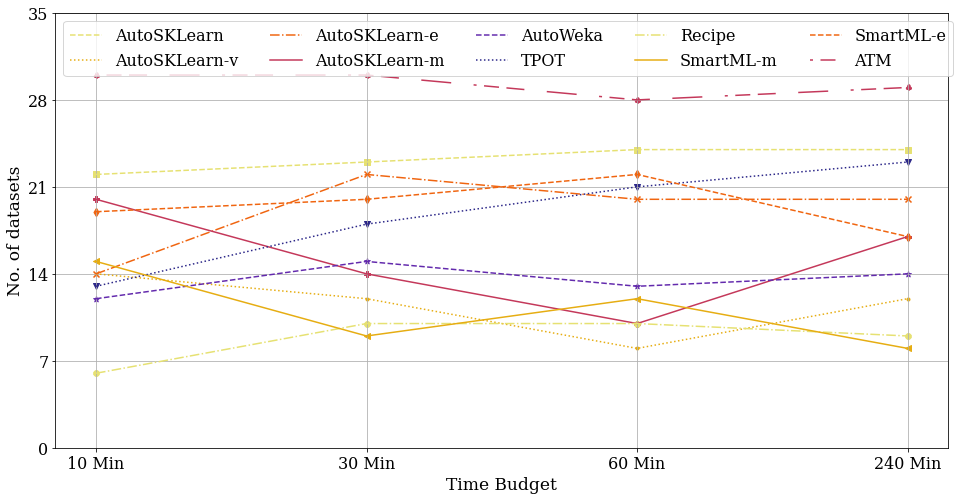

In [67]:
experiment_time = ['10 Min', '30 Min', '60 Min', '240 Min']
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML-m', 'SmartML-e', 'ATM']
types= ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'smartml_e_valid_acc', 'atm_acc']
# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '240 Min', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
#         result[tt] = result[tt][condition]

T=[]


for t in experiment_time:
    total = [0,0,0,0,0,0,0,0,0,0]
    for i in result[t][types[0]].index:
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))
y_lim = (1 + max(map(max, s))//5) * 5
fig, ax = plt.subplots(figsize=(16,8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit$'])
for i in range(len(types)-1):
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])

line1, = ax.plot(t, s[len(types)-1],linestyle='-',label=labels[len(types)-1])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[len(types)-1],
           #color= next(gray_colors),
           marker =next(markers))
x_label, y_label='Time Budget', 'No. of datasets'
font_size=17
plt.xlabel(x_label, fontsize=font_size)
plt.ylabel(y_label, fontsize=font_size)
ax.set_yticks(np.arange(0,5+y_lim, y_lim//5))
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([0, y_lim])
plt.legend(loc='upper left', labels=labels, ncol=5, bbox_to_anchor=(-0.0, 1))
#plt.title(label='No. of datasets in which the tool has acheived the best \n performance w.r.t other tools', pad=45, fontsize=font_size)
plt.savefig('./bench_figs/' + 'No of times the tool has acheived the best performance w.r.t other tools'.replace(' ', '_').replace('.', '') + '.pdf', format='pdf')
plt.show()

# How many times each tool has achieved the worst performance?

In [12]:
sheet_path = r'./../Complete_Sheet.xlsx'
result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min', '30 Min', '60 Min', '240 Min','10 Min - F1 Score', '60 Min - F1 Score', 'meta-features'])
experiment_time = ['10 Min - F1 Score', '60 Min - F1 Score']
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML-m', 'ATM']
types= ['AutoSKLearn', 'AutoSKLearn_v', 'AutoSKLearn_e', 'AutoSKLearn_m','AutoWeka', 'TPot', 'Recipe', 'SmartML-m', 'ATM']# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '240 Min', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
#         result[tt] = result[tt][condition]


T=[]
for t in experiment_time:
    total = [0,0,0,0,0,0,0,0,0]
    for i in result[t][types[0]].index:
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        min_value = min(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if x-min_value<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = ['10 Min', '60 Min']
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))
#print(s)
y_lim = (1 + max(map(max, s))//5) * 5
fig, ax = plt.subplots(figsize=(9,4))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit$'])
for i in range(len(types)-1):
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])

line1, = ax.plot(t, s[len(types)-1],linestyle='-',label=labels[len(types)-1])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[len(types)-1],
           #color= next(gray_colors),
           marker =next(markers))
x_label, y_label='Time Budget', 'No. of datasets'
font_size=17
plt.xlabel(x_label, fontsize=font_size)
plt.ylabel(y_label, fontsize=font_size)
plt.title(label='No. of datasets in which the tool has acheived the worst \n performance w.r.t other tools (F1 Score)', pad=45, fontsize=font_size)
ax.grid()
#plt.xlim([-3, 3])
ax.set_yticks(np.arange(0,5+y_lim, y_lim//5))
plt.ylim([0, y_lim])
plt.legend(loc='upper left', ncol=5,labels=labels, bbox_to_anchor=(-0.0, 1))
plt.savefig('./bench_figs/' + 'No of times the tool has acheived the worst performance w.r.t other tools (F1 Score)'.replace(' ', '_').replace('.', '') + '.pdf', format='pdf')
plt.show()

KeyError: 'SmartML-v'

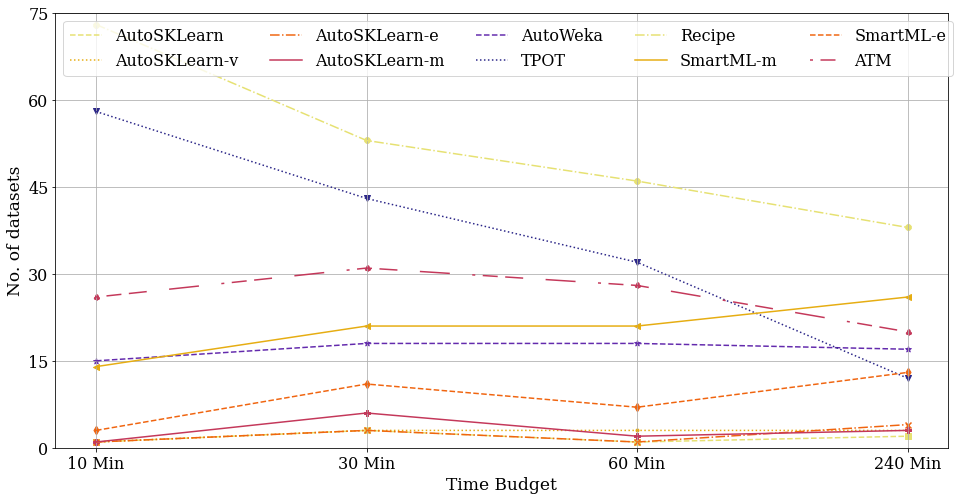

In [68]:
experiment_time = ['10 Min', '30 Min', '60 Min', '240 Min']
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML-m', 'SmartML-e', 'ATM']
types= ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'smartml_e_valid_acc', 'atm_acc']
# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '240 Min', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
#         result[tt] = result[tt][condition]


T=[]
for t in experiment_time:
    total = [0,0,0,0,0,0,0,0,0,0]
    for i in result[t][types[0]].index:
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        min_value = min(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if x-min_value<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))
#print(s)
y_lim = (1 + max(map(max, s))//5) * 5
fig, ax = plt.subplots(figsize=(16,8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit$'])
for i in range(len(types)-1):
    ax.scatter(x=np.arange(len(experiment_time)),
               y=s[i],
               marker =next(markers))
           #color= next(gray_colors),
          
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])
    
line1, = ax.plot(t, s[len(types)-1],linestyle='-',label=labels[len(types)-1])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
            y=s[len(types)-1],
            #color= next(gray_colors),
            marker =next(markers))
x_label, y_label='Time Budget', 'No. of datasets'
font_size=17
plt.xlabel(x_label, fontsize=font_size)
plt.ylabel(y_label, fontsize=font_size)
# plt.title(label='No. of datasets in which the tool has acheived the worst \n performance w.r.t other tools', pad=45, fontsize=font_size)
ax.grid()
#plt.xlim([-3, 3])
ax.set_yticks(np.arange(0,5+y_lim, y_lim//5))
plt.ylim([0, y_lim])
plt.legend(loc='upper left', ncol=5,labels=labels, bbox_to_anchor=(-0.0, 1))
plt.savefig('./bench_figs/' + 'No of times the tool has acheived the worst performance w.r.t other tools'.replace(' ', '_').replace('.', '') + '.pdf', format='pdf')
plt.show()

# What is the best time budget for each tool ? In each time budget, how many datasets reached the maximum accuracy w.r.t this tool only ?

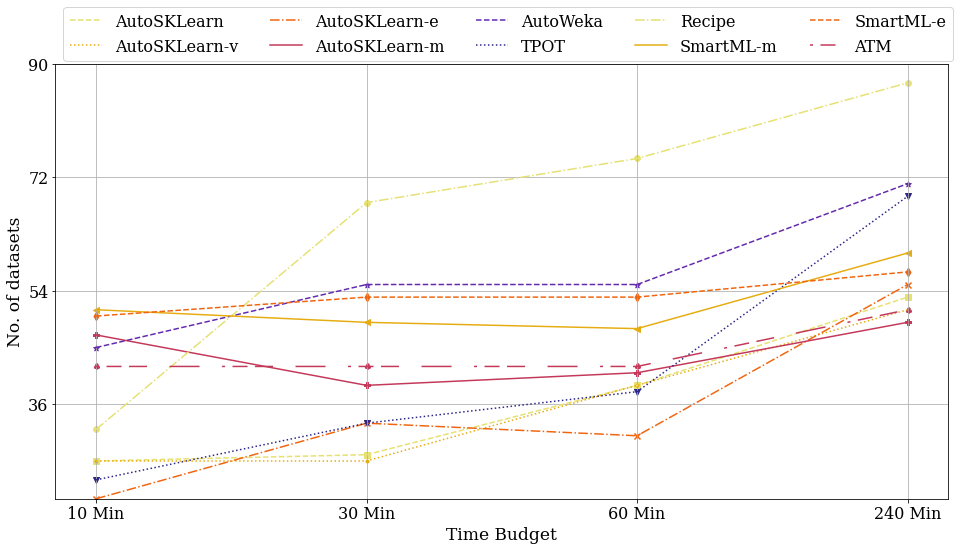

In [69]:
# types= ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
#             'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'atm_acc']
# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '240 Min', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
#         result[tt] = result[tt][condition]


total = [0,0,0,0]

T = [[0,0,0,0],[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]] 



for j in range(len(types)):
    for i in result['10 Min'][types[0]].index:
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][types[j]][i] for t in experiment_time]
        #print(my_list)
        my_list = [0 if np.isnan(t) else t for t in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        for ind in range(4):
            if max_value - my_list[ind] <0.00001:
                T[j][ind] +=1
#print(T)
y_lim = (1 + max(map(max, T))//5) * 5
t = experiment_time
fig, ax = plt.subplots(figsize=(16,8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit$'])
for i in range(len(types)-1):
    ax.plot(t, T[i],linestyle=style[i],label=labels[i])
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=T[i],
           #color= next(gray_colors),
           marker =next(markers))

line1, = ax.plot(t, T[len(types)-1],linestyle='-',label=labels[len(types)-1])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=T[len(types)-1],
           #color= next(gray_colors),
           marker =next(markers))
x_label, y_label='Time Budget', 'No. of datasets'
font_size=17
plt.xlabel(x_label, fontsize=font_size)
plt.ylabel(y_label, fontsize=font_size)
# plt.title(label='No. of datasets in which the tool acheived the best \n performance w.r.t other time budgets', pad=45, fontsize=font_size)
ax.grid()
#plt.xlim([-3, 3])
ax.set_yticks(np.arange(0,5+y_lim, y_lim//5))
plt.ylim([min(map(min, T)), y_lim])
plt.legend(loc='upper left', ncol=5,labels=labels, bbox_to_anchor=(-0.0, 1.15))
plt.savefig('./bench_figs/' + 'No of datasets acheived the best performance w.r.t other time budgets'.replace(' ', '_').replace('.', '') + '.pdf', format='pdf')
plt.show()

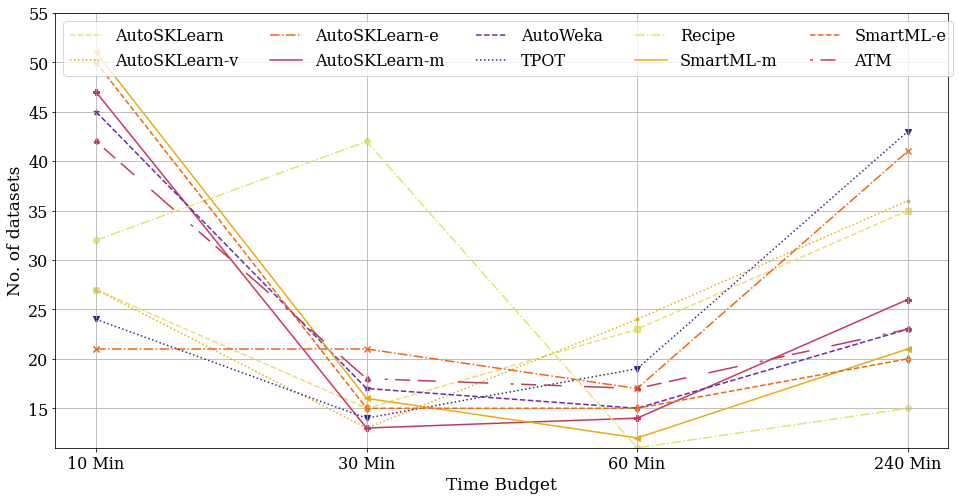

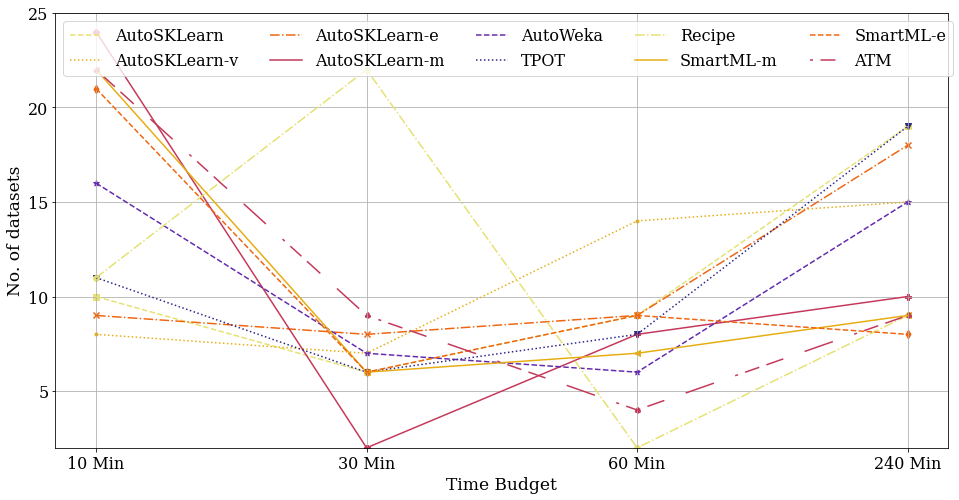

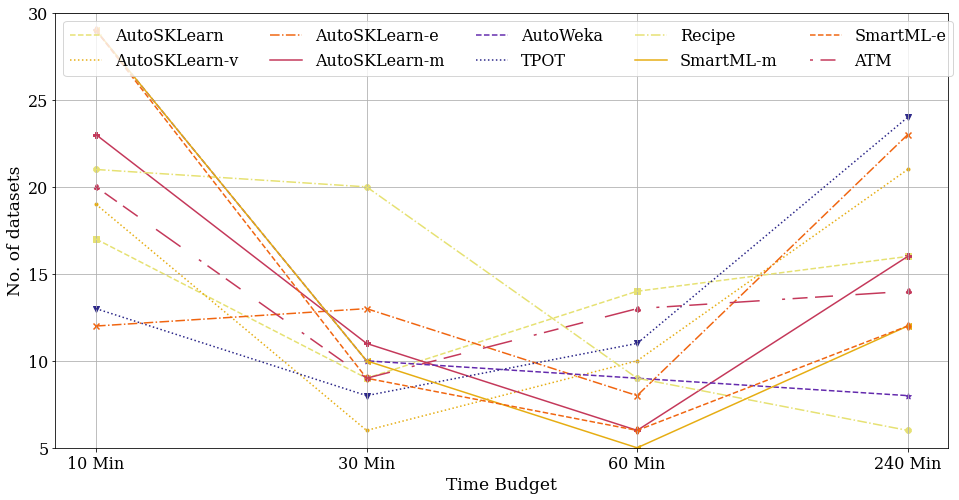

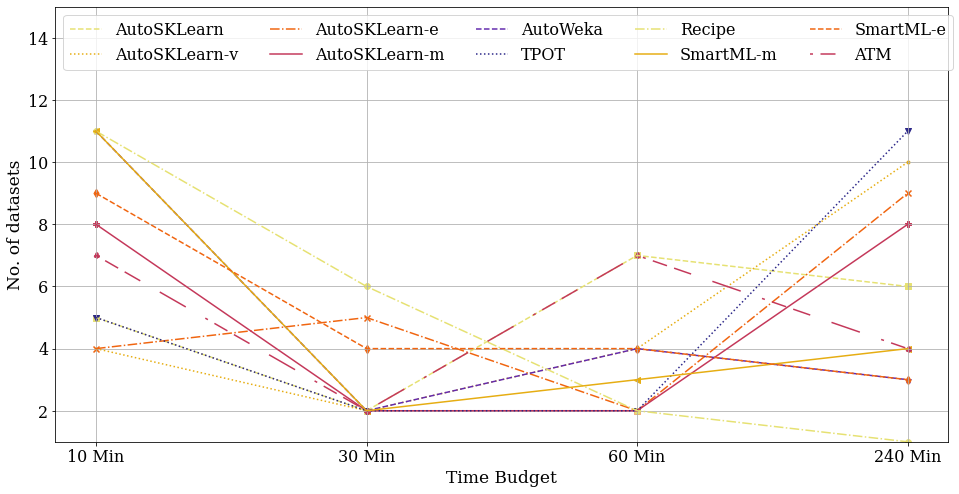

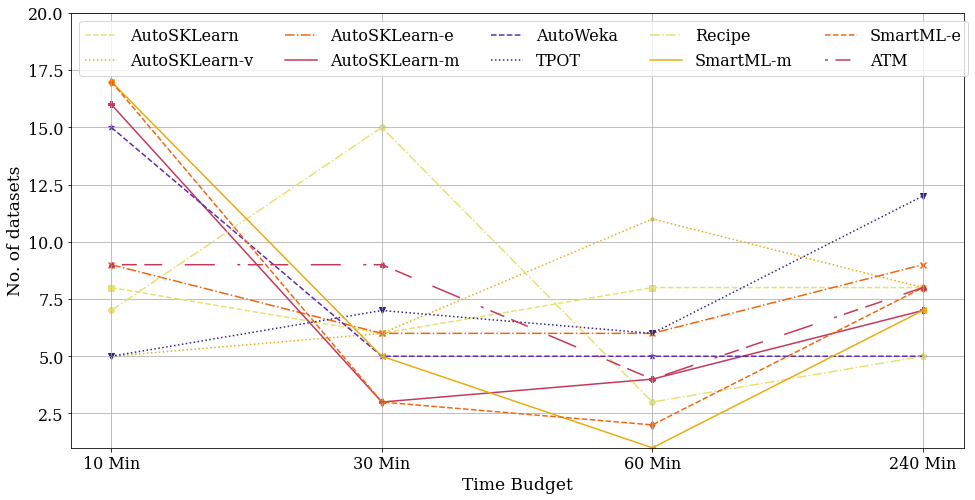

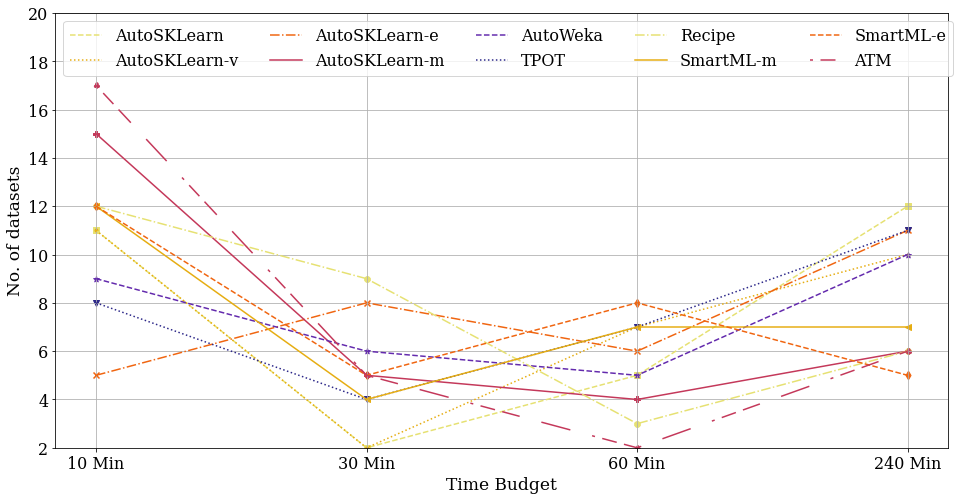

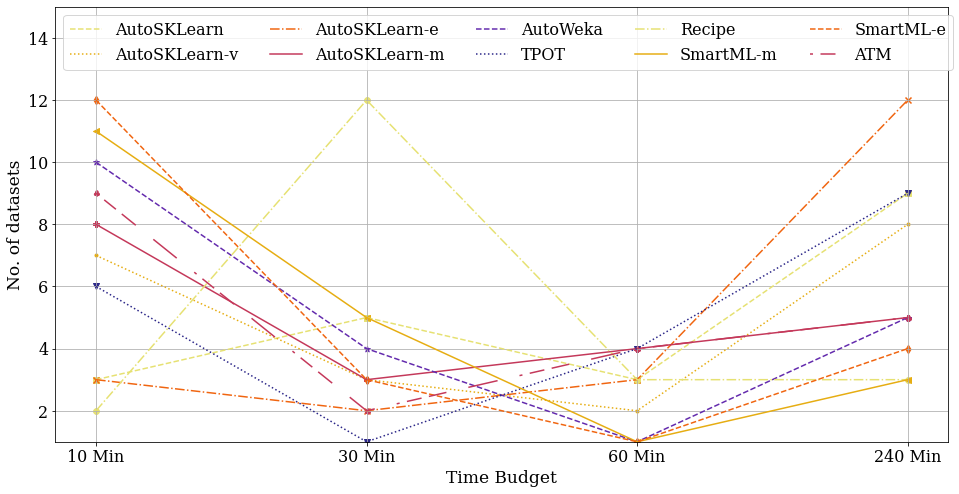

In [70]:
# types= ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
#             'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'atm_acc']
for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
             'Small # features and Large # instances', 'Large # features and Small # instances',
             'Large # (features and instances)'],
         [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
         result['meta-features'].nr_classes >2,
         (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
         (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
         ]):
    result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min', '30 Min', '60 Min', '240 Min', 'meta-features'])
    for tt in ['10 Min', '30 Min', '60 Min', '240 Min']:
        result[tt] = result[tt][condition]
        
    total = [0,0,0,0]

    T = [[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]] 



    for j in range(len(types)):
        for i in result['10 Min'][types[0]].index:
            #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
            my_list= [result[t][types[j]][i] for t in experiment_time]
            #print(my_list)
            my_list = [0 if np.isnan(t) else t for t in my_list]
            max_value = max(my_list)
            #print(max_value,my_list)
            for ind in range(4):
                if max_value - my_list[ind] <0.00001:
                    T[j][ind] +=1
                    break
    #print(T)
    y_lim = (1 + max(map(max, T))//5) * 5
    t = experiment_time
    fig, ax = plt.subplots(figsize=(16,8))
    #ax.plot(t, s[0],linestyle='-',label=labels[0])
    style = ['--', ':', '-.', '-', '--', ':', '-.', '-', '--']
    markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit$'])
    for i in range(len(types)-1):
        ax.plot(t, T[i],linestyle=style[i],label=labels[i])
        ax.scatter(x=np.arange(len(experiment_time)), 
               y=T[i],
               #color= next(gray_colors),
               marker =next(markers))

    line1, = ax.plot(t, T[len(types)-1],linestyle='-',label=labels[len(types)-1])
    line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
    ax.scatter(x=np.arange(len(experiment_time)), 
               y=T[len(types)-1],
               #color= next(gray_colors),
               marker =next(markers))
    x_label, y_label='Time Budget', 'No. of datasets'
    font_size=17
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
#     plt.title(label='No. of datasets in which the tool acheived the best \n performance w.r.t other time budgets(' + case + ')', pad=45, fontsize=font_size)
    ax.grid()
    #plt.xlim([-3, 3])
    plt.ylim([min(map(min, T)), y_lim])
    plt.legend(loc='upper left', ncol=5, labels=labels, bbox_to_anchor=(-0.0, 1))
    plt.show()

# How many times Meta-learning improved the performance and what is the average improvement in AutoSKLearn?

[34]


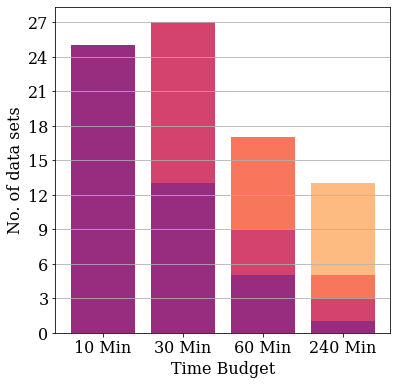

In [112]:
#cubehelix_r
sns.set_palette("magma_r")
x_label = 'Data Sets'
fig = Figure()
meta = 'sklearn_m_accuracy_mean'
vanilla = 'sklearn_v_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Meta-Learning'
fig.compare_acc_bar(meta, vanilla, x_label, y_lable, title, fig_size=(6, 6), legend_x_shift=-0.012, y_limit=[-0.2, 0.1], divide_data=False)

[]


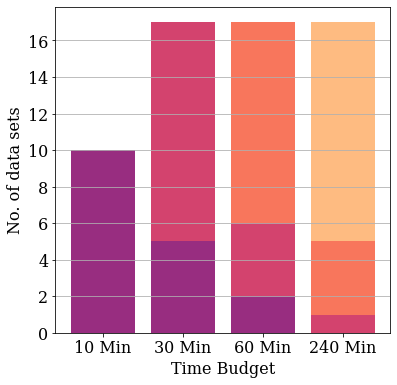

In [113]:
sns.set_palette("magma_r")
x_label = 'Data Sets'
fig = Figure()
meta = 'sklearn_m_accuracy_mean'
vanilla = 'sklearn_v_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Vanilla Version'
fig.compare_acc_bar(vanilla, meta, x_label, y_lable, title, fig_size=(6, 6))

In [54]:

total = [0,0,0,0]

T = [[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]] 
result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min', '30 Min', '60 Min', '240 Min', 'meta-features'])


for j in range(len(types)):
    for i in range(100):
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][types[j]][i] for t in experiment_time]
        #print(my_list)
        my_list = [0 if np.isnan(t) else t for t in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        for ind in range(4):
            if max_value - my_list[ind] <0.00001:
                T[j][ind] +=1
                break
#print(T)

t = experiment_time
fig, ax = plt.subplots(figsize=(9, 4))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit

for k in range(len(experiment_time)):
    plt.bar(np.arange(len(types)), [sum(T[j][i] for i in np.arange(len(experiment_time)-k)) for j in np.arange(len(types))])

ax.set(xlabel='Tool', ylabel='No. of data sets acheived max. accuracy',title='No. of datasets acheived the best performance over time')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([20, 100])
#plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
ax.set_xticklabels(labels)
plt.xticks(rotation=70)
plt.show()])

for k in range(len(experiment_time)):
    plt.bar(np.arange(len(types)), [sum(T[j][i] for i in np.arange(len(experiment_time)-k)) for j in np.arange(len(types))])

ax.set(xlabel='Tool', ylabel='No. of data sets acheived max. accuracy',title='No. of datasets acheived the best performance over time')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([20, 100])
#plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
ax.set_xticklabels(labels)
plt.xticks(rotation=70)
plt.show()])

for k in range(len(experiment_time)):
    plt.bar(np.arange(len(types)), [sum(T[j][i] for i in np.arange(len(experiment_time)-k)) for j in np.arange(len(types))])

ax.set(xlabel='Tool', ylabel='No. of data sets acheived max. accuracy',title='No. of datasets acheived the best performance over time')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([20, 100])
#plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
ax.set_xticklabels(labels)
plt.xticks(rotation=70)
plt.show()])

for k in range(len(experiment_time)):
    plt.bar(np.arange(len(types)), [sum(T[j][i] for i in np.arange(len(experiment_time)-k)) for j in np.arange(len(types))])

ax.set(xlabel='Tool', ylabel='No. of data sets acheived max. accuracy',title='No. of datasets acheived the best performance over time')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([20, 100])
#plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
ax.set_xticklabels(labels)
plt.xticks(rotation=70)
plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-54-bfd8c69810e5>, line 26)

# Performance Comparison between ATM (Best Performing) vs AutoSkLearn - V (Low Performing)

Average and Max loss = -6.0, and -25.7,  from 24 datasets
 25 datasets have the same performance
Average and Max gain = 8.9 and 46.7,  from 26 datasets
0 datasets failed to run on the left side only
24 datasets failed to run on the right side only
1 datasets failed to run on the both sides
8.9  &  46.7  &  26  &  25  &  24  &  -6.0  &  -25.7


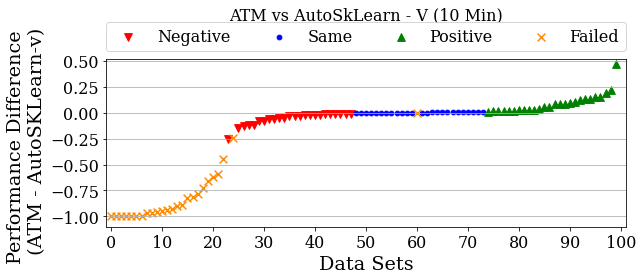

In [73]:
%matplotlib inline 
x_label = 'Data Sets'
fig = Figure()
atm = fig.get_sheet()['10 Min'].atm_acc
vanilla = fig.get_sheet()['10 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n (ATM - AutoSKLearn-v)'
title = 'ATM vs AutoSkLearn - V (10 Min)'
fig.compare_acc_scatter(atm, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -6.7, and -20.0,  from 18 datasets
 29 datasets have the same performance
Average and Max gain = 10.5 and 40.0,  from 27 datasets
0 datasets failed to run on the left side only
25 datasets failed to run on the right side only
1 datasets failed to run on the both sides
10.5  &  40.0  &  27  &  29  &  18  &  -6.7  &  -20.0


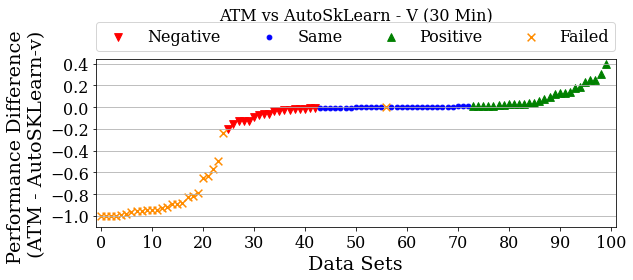

In [74]:
%matplotlib inline 
x_label = 'Data Sets'
fig = Figure()
atm = fig.get_sheet()['30 Min'].atm_acc
vanilla = fig.get_sheet()['30 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n (ATM - AutoSKLearn-v) '
title = 'ATM vs AutoSkLearn - V (30 Min)'
fig.compare_acc_scatter(atm, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -6.2, and -21.8,  from 29 datasets
 25 datasets have the same performance
Average and Max gain = 7.9 and 26.6,  from 25 datasets
0 datasets failed to run on the left side only
20 datasets failed to run on the right side only
1 datasets failed to run on the both sides
7.9  &  26.6  &  25  &  25  &  29  &  -6.2  &  -21.8


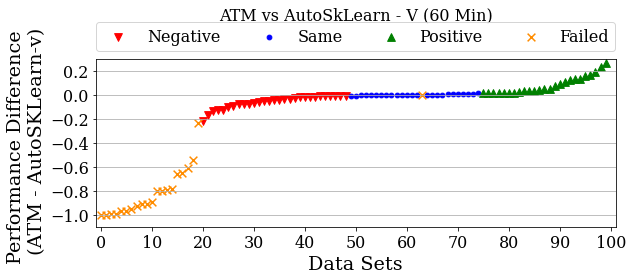

In [75]:
%matplotlib inline 
x_label = 'Data Sets'
fig = Figure()
atm = fig.get_sheet()['60 Min'].atm_acc
vanilla = fig.get_sheet()['60 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n (ATM - AutoSKLearn-v)'
title = 'ATM vs AutoSkLearn - V (60 Min)'
fig.compare_acc_scatter(atm, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -5.8, and -23.5,  from 30 datasets
 32 datasets have the same performance
Average and Max gain = 11.4 and 40.4,  from 24 datasets
0 datasets failed to run on the left side only
13 datasets failed to run on the right side only
1 datasets failed to run on the both sides
11.4  &  40.4  &  24  &  32  &  30  &  -5.8  &  -23.5


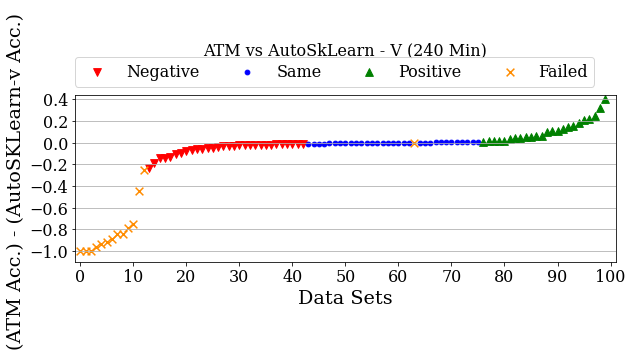

In [76]:
%matplotlib inline 
x_label = 'Data Sets'
fig = Figure()
atm = fig.get_sheet()['240 Min'].atm_acc
vanilla = fig.get_sheet()['240 Min'].sklearn_v_accuracy_mean
y_lable = '(ATM Acc.) - (AutoSKLearn-v Acc.) '
title = 'ATM vs AutoSkLearn - V (240 Min)'
fig.compare_acc_scatter(atm, vanilla, x_label, y_lable, title, fig_size=(9, 4))

# Effect of Meta-Learning

Average and Max loss = -5.6, and -15.4,  from 10 datasets
 64 datasets have the same performance
Average and Max gain = 2.9 and 6.7,  from 25 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
2.9  &  6.7  &  25  &  64  &  10  &  -5.6  &  -15.4


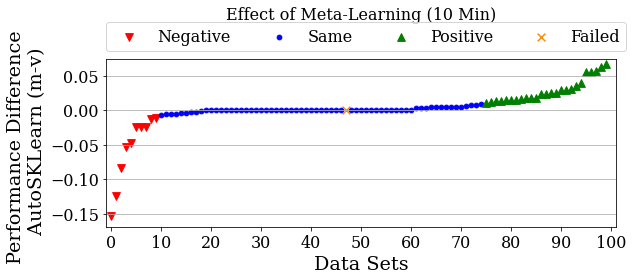

In [77]:
%matplotlib inline 
x_label = 'Data Sets'
fig = Figure()
meta = fig.get_sheet()['10 Min'].sklearn_m_accuracy_mean
vanilla = fig.get_sheet()['10 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (m-v)'
title = 'Effect of Meta-Learning (10 Min)'
fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -4.5, and -16.7,  from 17 datasets
 55 datasets have the same performance
Average and Max gain = 2.8 and 18.8,  from 27 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
2.8  &  18.8  &  27  &  55  &  17  &  -4.5  &  -16.7


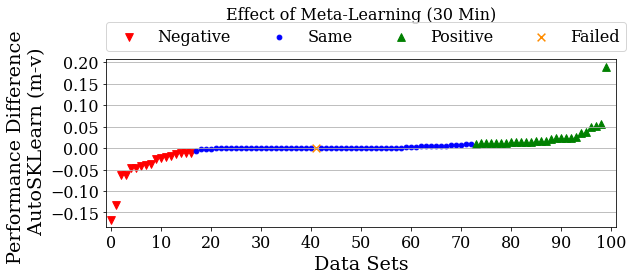

In [78]:
fig = Figure()
meta = fig.get_sheet()['30 Min'].sklearn_m_accuracy_mean
vanilla = fig.get_sheet()['30 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (m-v)'
title = 'Effect of Meta-Learning (30 Min)'
fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -4.4, and -13.3,  from 17 datasets
 65 datasets have the same performance
Average and Max gain = 3.4 and 18.8,  from 17 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.4  &  18.8  &  17  &  65  &  17  &  -4.4  &  -13.3


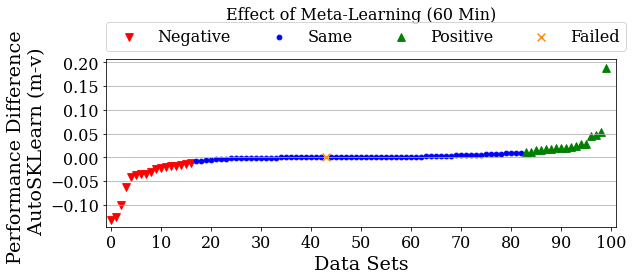

In [79]:
%matplotlib inline 
x_label = 'Data Sets'
fig = Figure()
meta = fig.get_sheet()['60 Min'].sklearn_m_accuracy_mean
vanilla = fig.get_sheet()['60 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (m-v)'
title = 'Effect of Meta-Learning (60 Min)'
fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -2.7, and -8.3,  from 17 datasets
 69 datasets have the same performance
Average and Max gain = 5.5 and 18.8,  from 13 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.5  &  18.8  &  13  &  69  &  17  &  -2.7  &  -8.3


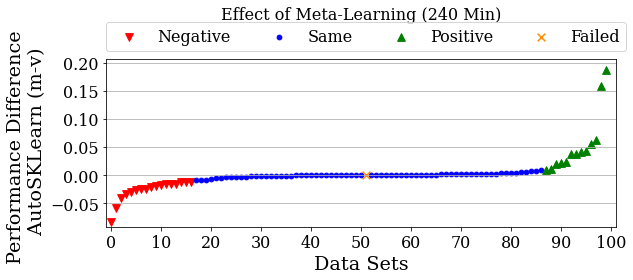

In [80]:
fig = Figure()
meta = fig.get_sheet()['240 Min'].sklearn_m_accuracy_mean
vanilla = fig.get_sheet()['240 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (m-v)'
title = 'Effect of Meta-Learning (240 Min)'
fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9, 4))

# How many times Ensembling improved the performance and what is the average improvement in AutoSKLearn?

[ 5 46 64]


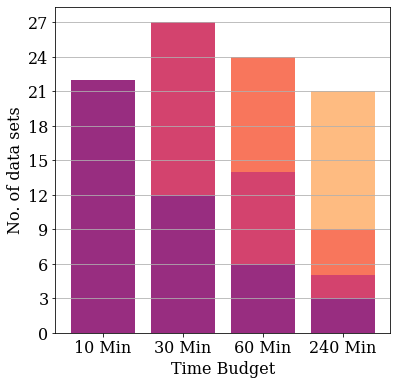

In [114]:
sns.set_palette("magma_r")
x_label = 'Data Sets'
fig = Figure()
ensembling = 'sklearn_e_accuracy_mean'
vanilla = 'sklearn_v_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Ensembling Version'
fig.compare_acc_bar(ensembling, vanilla, x_label, y_lable, title, fig_size=(6, 6))

[26]


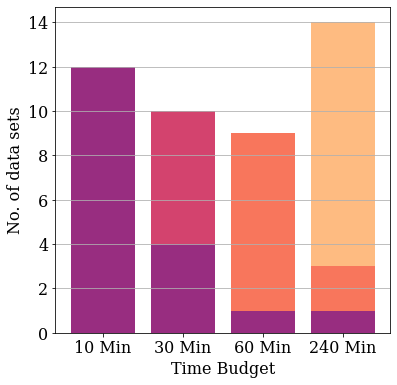

In [117]:
sns.set_palette("magma_r")
x_label = 'Data Sets'
fig = Figure()
ensembling = 'sklearn_e_accuracy_mean'
vanilla = 'sklearn_v_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Vanilla than Ensembling'
fig.compare_acc_bar(vanilla, ensembling, x_label, y_lable, title, fig_size=(6, 6))

[ 7  8 24 27 34 35 38 47 56 62 68 70 72 78 79 81 83 92 94 99]


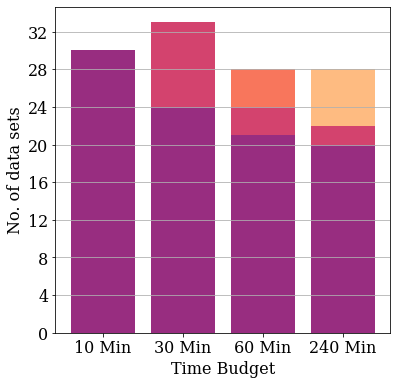

In [115]:
sns.set_palette("magma_r")
x_label = 'Data Sets'
fig = Figure()
ensembling = 'smartml_e_valid_acc'
vanilla = 'smartml_valid_acc'
y_lable = ' '
title = 'No. of datasets had better accuracy\n with Ensembling Version of smartML'
fig.compare_acc_bar(ensembling, vanilla, x_label, y_lable, title, fig_size=(6, 6))

In [84]:
print(list(range(100)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [85]:
indx = [ 7,  8, 24, 27, 34, 35, 38, 47, 56, 62, 68, 70, 72, 78, 79, 81, 83, 92, 94, 99]
indx_prime = [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 69, 71, 73, 74, 75, 76, 77, 80, 82, 84, 85, 86, 87, 88, 89, 90, 91, 93, 95, 96, 97, 98]
fig.sheet['meta-features'].iloc[indx,:]
# fig.sheet['meta-features'][['nr_features', 'nr_instances']].plot(x='nr_features', y='nr_instances', style='o')
# fig.sheet['meta-features'].loc[indx,['nr_features', 'nr_instances']].plot(x='nr_features', y='nr_instances', style='rx')
# display(fig.sheet['meta-features'][['class_entropy']].sort_values(by='class_entropy', ascending=False))
# display(fig.sheet['meta-features'].loc[indx,['class_entropy']].sort_values(by='class_entropy', ascending=False))
# fig.sheet['meta-features'][['nr_features', 'nr_instances']].hist(bins=5)
display(fig.sheet['meta-features'].loc[indx,['nr_features', 'nr_instances']].sort_values(by='nr_instances', ascending=False))
display(fig.sheet['meta-features'].loc[indx_prime,['nr_features', 'nr_instances']].sort_values(by='nr_instances', ascending=False).iloc[30:,:])

nr_features  nr_instances
99         65.0     1455525.0
94         42.0      299285.0
92          5.0      149332.0
83         17.0       45211.0
81         11.0       20867.0
79         11.0       19020.0
78        130.0       13910.0
72         22.0       10885.0
70         33.0        9873.0
68          9.0        8192.0
62         52.0        6118.0
56         21.0        5000.0
47         73.0        2534.0
38      10001.0        1500.0
35        101.0        1212.0
34        857.0        1080.0
27         19.0         846.0
24         10.0         699.0
8          26.0         205.0
7       16064.0         190.0

nr_features  nr_instances
58         37.0        5100.0
57         41.0        5000.0
55         12.0        4898.0
54         45.0        4704.0
53         58.0        4601.0
52       1618.0        4229.0
51          9.0        4177.0
50        971.0        3468.0
49         27.0        2800.0
48        501.0        2600.0
46         19.0        2310.0
45        241.0        2000.0
44         28.0        1941.0
43         65.0        1600.0
42         65.0        1600.0
41         12.0        1599.0
40         65.0        1599.0
39        257.0        1593.0
37          9.0        1484.0
36         18.0        1340.0
34        857.0        1080.0
33         81.0        1080.0
32         42.0        1055.0
31         21.0        1000.0
30         23.0        1000.0
29         21.0        1000.0
28         14.0         990.0
27         19.0         846.0
26         71.0         841.0
25         20.0         736.0
23         36.0         683.0
22         61.0         600.0
21      10305.0         575.0
20       1083.0         571.0
19      10937.0         470.0
18        263.0         452.0
17       1088.0         360.0
16         34.0         351.0
15         14.0         340.0
14          8.0         336.0
13         13.0         315.0
12      10937.0         275.0
11      10937.0         267.0
10         70.0         226.0
9          61.0         208.0
6           5.0         150.0
5       22278.0          95.0
4        7130.0          72.0
2        4703.0          64.0
3        3722.0          64.0
1        7130.0          60.0
0        4027.0          45.0

In [86]:
display(fig.sheet['meta-features'].loc[indx,['nr_features', 'nr_instances']].mean())
display(fig.sheet['meta-features'].loc[indx_prime,['nr_features', 'nr_instances']].mean())

nr_features       1378.45
nr_instances    102574.20
dtype: float64

nr_features      1292.219512
nr_instances    47976.256098
dtype: float64

[12 18 19 45 55 58 64 82 86]


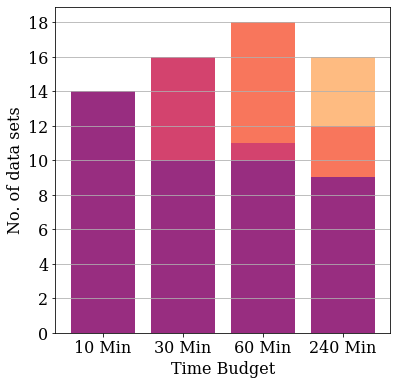

In [116]:
sns.set_palette("magma_r")
x_label = 'Data Sets'
fig = Figure()
ensembling = 'smartml_e_valid_acc'
vanilla = 'smartml_valid_acc'
y_lable = ' '
title = 'No. of datasets had better accuracy\n with vanilla than ensembling of smartML'
fig.compare_acc_bar(vanilla, ensembling, x_label, y_lable, title, fig_size=(6, 6))

In [88]:
indx = [12, 18, 19, 45, 55, 58, 64, 82, 86]
fig.sheet['meta-features'].iloc[indx,:]
# fig.sheet['meta-features'][['nr_features', 'nr_instances']].plot(x='nr_features', y='nr_instances', style='o')
# fig.sheet['meta-features'].loc[indx,['nr_features', 'nr_instances']].plot(x='nr_features', y='nr_instances', style='rx')
# fig.sheet['meta-features'][['nr_features', 'nr_instances']].hist(bins=5)
display(fig.sheet['meta-features'].loc[indx,['nr_features', 'nr_instances']].sort_values(by='nr_features', ascending=False))
display(fig.sheet['meta-features'].loc[indx,['nr_features', 'nr_instances']].sort_values(by='nr_instances', ascending=False))

nr_features  nr_instances
12      10937.0         275.0
19      10937.0         470.0
18        263.0         452.0
45        241.0        2000.0
58         37.0        5100.0
64         21.0        7400.0
86         15.0       48842.0
55         12.0        4898.0
82         10.0       32769.0

nr_features  nr_instances
86         15.0       48842.0
82         10.0       32769.0
64         21.0        7400.0
58         37.0        5100.0
55         12.0        4898.0
45        241.0        2000.0
19      10937.0         470.0
18        263.0         452.0
12      10937.0         275.0

Average and Max loss = -3.4, and -8.3,  from 12 datasets
 65 datasets have the same performance
Average and Max gain = 4.1 and 16.4,  from 22 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.1  &  16.4  &  22  &  65  &  12  &  -3.4  &  -8.3


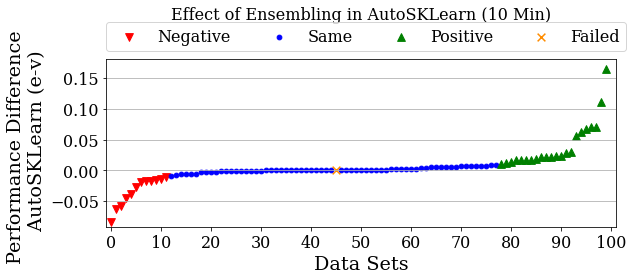

In [89]:
x_label = 'Data Sets'
fig = Figure()
ensembling = fig.get_sheet()['10 Min'].sklearn_e_accuracy_mean
vanilla = fig.get_sheet()['10 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (e-v)'
title = 'Effect of Ensembling in AutoSKLearn (10 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -3.1, and -11.1,  from 10 datasets
 62 datasets have the same performance
Average and Max gain = 3.4 and 13.5,  from 27 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.4  &  13.5  &  27  &  62  &  10  &  -3.1  &  -11.1


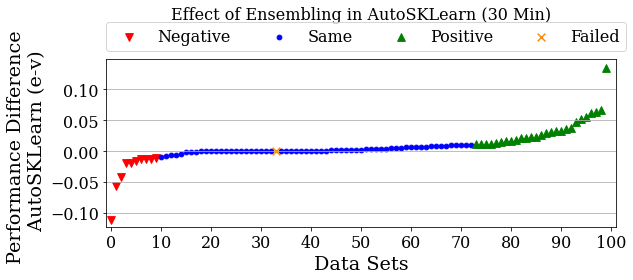

In [90]:
fig = Figure()
ensembling = fig.get_sheet()['30 Min'].sklearn_e_accuracy_mean
vanilla = fig.get_sheet()['30 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (e-v)'
title = 'Effect of Ensembling in AutoSKLearn (30 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -3.1, and -6.7,  from 9 datasets
 66 datasets have the same performance
Average and Max gain = 4.9 and 12.5,  from 24 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.9  &  12.5  &  24  &  66  &  9  &  -3.1  &  -6.7


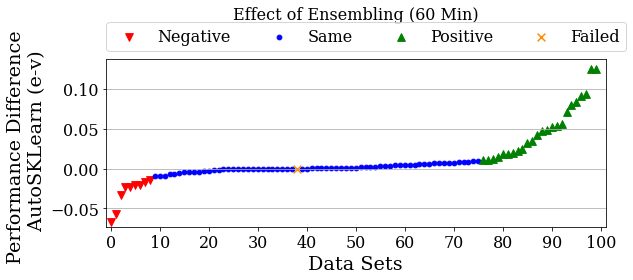

In [91]:
fig = Figure()
ensembling = fig.get_sheet()['60 Min'].sklearn_e_accuracy_mean
vanilla = fig.get_sheet()['60 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (e-v)'
title = 'Effect of Ensembling (60 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -2.9, and -8.3,  from 14 datasets
 64 datasets have the same performance
Average and Max gain = 7.1 and 52.7,  from 21 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
7.1  &  52.7  &  21  &  64  &  14  &  -2.9  &  -8.3


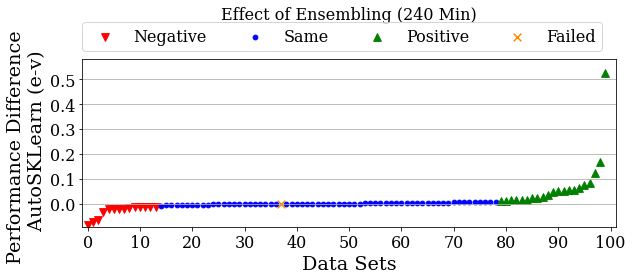

In [92]:
fig = Figure()
ensembling = fig.get_sheet()['240 Min'].sklearn_e_accuracy_mean
vanilla = fig.get_sheet()['240 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (e-v)'
title = 'Effect of Ensembling (240 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))

# Effect of Ensembling in SmartML

Average and Max loss = -10.2, and -36.1,  from 14 datasets
 44 datasets have the same performance
Average and Max gain = 12.6 and 64.2,  from 30 datasets
9 datasets failed to run on the left side only
1 datasets failed to run on the right side only
2 datasets failed to run on the both sides
12.6  &  64.2  &  30  &  44  &  14  &  -10.2  &  -36.1


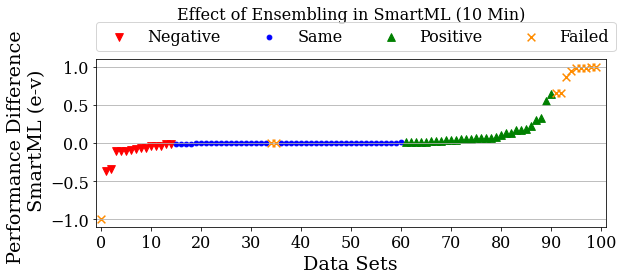

In [93]:
x_label = 'Data Sets'
fig = Figure()
ensembling = fig.get_sheet()['10 Min'].smartml_e_valid_acc
vanilla = fig.get_sheet()['10 Min'].smartml_valid_acc
y_lable = 'Performance Difference \n SmartML (e-v)'
title = 'Effect of Ensembling in SmartML (10 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -10.6, and -39.4,  from 16 datasets
 40 datasets have the same performance
Average and Max gain = 12.5 and 73.2,  from 33 datasets
7 datasets failed to run on the left side only
1 datasets failed to run on the right side only
3 datasets failed to run on the both sides
12.5  &  73.2  &  33  &  40  &  16  &  -10.6  &  -39.4


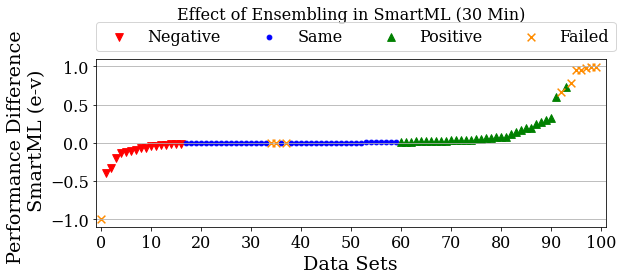

In [94]:
fig = Figure()
ensembling = fig.get_sheet()['30 Min'].smartml_e_valid_acc
vanilla = fig.get_sheet()['30 Min'].smartml_valid_acc
y_lable = 'Performance Difference \n SmartML (e-v)'
title = 'Effect of Ensembling in SmartML (30 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -10.5, and -31.1,  from 18 datasets
 42 datasets have the same performance
Average and Max gain = 11.2 and 55.8,  from 28 datasets
7 datasets failed to run on the left side only
1 datasets failed to run on the right side only
4 datasets failed to run on the both sides
11.2  &  55.8  &  28  &  42  &  18  &  -10.5  &  -31.1


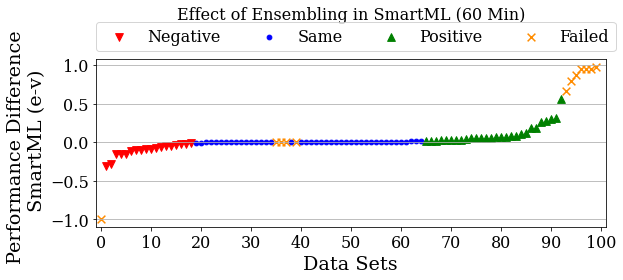

In [95]:
fig = Figure()
ensembling = fig.get_sheet()['60 Min'].smartml_e_valid_acc
vanilla = fig.get_sheet()['60 Min'].smartml_valid_acc
y_lable = 'Performance Difference \n SmartML (e-v)'
title = 'Effect of Ensembling in SmartML (60 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -11.9, and -37.2,  from 16 datasets
 44 datasets have the same performance
Average and Max gain = 10.2 and 34.5,  from 28 datasets
7 datasets failed to run on the left side only
1 datasets failed to run on the right side only
4 datasets failed to run on the both sides
10.2  &  34.5  &  28  &  44  &  16  &  -11.9  &  -37.2


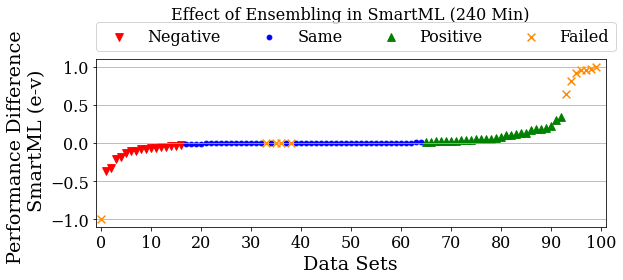

In [96]:
fig = Figure()
ensembling = fig.get_sheet()['240 Min'].smartml_e_valid_acc
vanilla = fig.get_sheet()['240 Min'].smartml_valid_acc
y_lable = 'Performance Difference \n SmartML (e-v)'
title = 'Effect of Ensembling in SmartML (240 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))

# How many times combined Meta-learning and Ensembling improved the performance and what is the average improvement in AutoSKLearn?

Average and Max loss = -5.5, and -16.7,  from 10 datasets
 57 datasets have the same performance
Average and Max gain = 3.1 and 12.4,  from 32 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.1  &  12.4  &  32  &  57  &  10  &  -5.5  &  -16.7


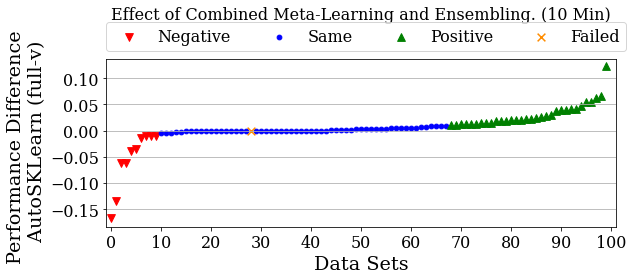

In [97]:
fig = Figure()
full = fig.get_sheet()['10 Min'].sklearn_accuracy_mean
vanilla = fig.get_sheet()['10 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (full-v)'
title = 'Effect of Combined Meta-Learning and Ensembling. (10 Min)'
fig.compare_acc_scatter(full, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -5.0, and -25.0,  from 13 datasets
 58 datasets have the same performance
Average and Max gain = 3.4 and 17.6,  from 28 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.4  &  17.6  &  28  &  58  &  13  &  -5.0  &  -25.0


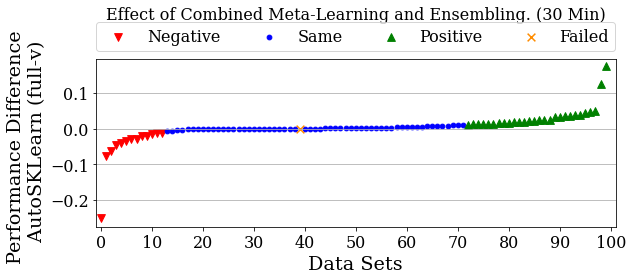

In [98]:
fig = Figure()
full = fig.get_sheet()['30 Min'].sklearn_accuracy_mean
vanilla = fig.get_sheet()['30 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (full-v)'
title = 'Effect of Combined Meta-Learning and Ensembling. (30 Min)'
fig.compare_acc_scatter(full, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -3.7, and -6.7,  from 8 datasets
 59 datasets have the same performance
Average and Max gain = 3.0 and 12.5,  from 32 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.0  &  12.5  &  32  &  59  &  8  &  -3.7  &  -6.7


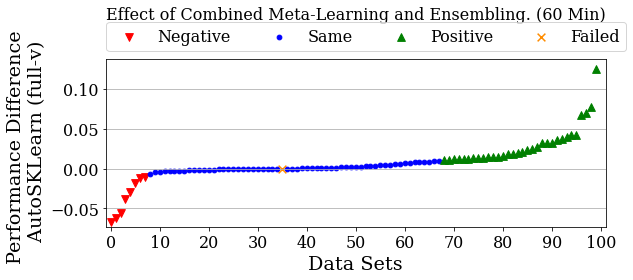

In [99]:
fig = Figure()
full = fig.get_sheet()['60 Min'].sklearn_accuracy_mean
vanilla = fig.get_sheet()['60 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (full-v)'
title = 'Effect of Combined Meta-Learning and Ensembling. (60 Min)'
fig.compare_acc_scatter(full, vanilla, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -1.9, and -2.4,  from 9 datasets
 65 datasets have the same performance
Average and Max gain = 5.4 and 51.4,  from 25 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.4  &  51.4  &  25  &  65  &  9  &  -1.9  &  -2.4


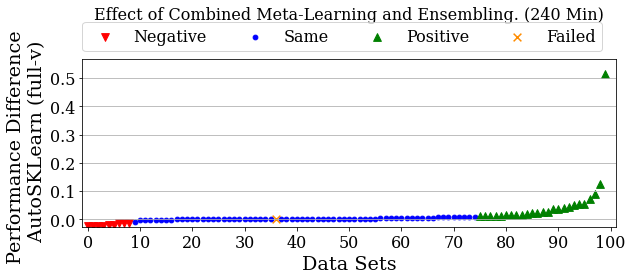

In [100]:
fig = Figure()
full = fig.get_sheet()['240 Min'].sklearn_accuracy_mean
vanilla = fig.get_sheet()['240 Min'].sklearn_v_accuracy_mean
y_lable = 'Performance Difference \n AutoSKLearn (full-v)'
title = 'Effect of Combined Meta-Learning and Ensembling. (240 Min)'
fig.compare_acc_scatter(full, vanilla, x_label, y_lable, title, fig_size=(9, 4))

# TPOT v.s. Recipe 

Average and Max loss = -2.5, and -2.5,  from 1 datasets
 14 datasets have the same performance
Average and Max gain = 26.0 and 82.4,  from 23 datasets
5 datasets failed to run on the left side only
31 datasets failed to run on the right side only
26 datasets failed to run on the both sides
26.0  &  82.4  &  23  &  14  &  1  &  -2.5  &  -2.5


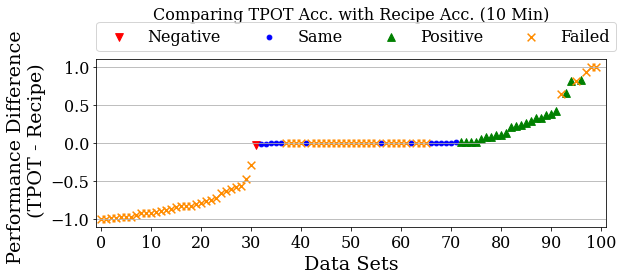

In [101]:
fig = Figure()
tpot = fig.get_sheet()['10 Min'].tpot_accuracy_mean
recipe = fig.get_sheet()['30 Min'].recipe_test_acc
x_label = 'Data Sets'
y_lable = 'Performance Difference \n (TPOT - Recipe)'
title = 'Comparing TPOT Acc. with Recipe Acc. (10 Min)'
fig.compare_acc_scatter(tpot, recipe, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -4.4, and -7.8,  from 4 datasets
 16 datasets have the same performance
Average and Max gain = 21.4 and 82.2,  from 30 datasets
9 datasets failed to run on the left side only
19 datasets failed to run on the right side only
22 datasets failed to run on the both sides
21.4  &  82.2  &  30  &  16  &  4  &  -4.4  &  -7.8


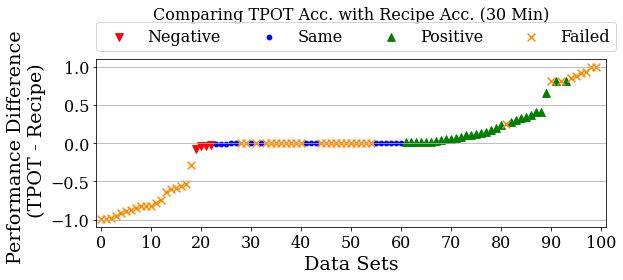

In [102]:
fig = Figure()
tpot = fig.get_sheet()['30 Min'].tpot_accuracy_mean
recipe = fig.get_sheet()['30 Min'].recipe_test_acc
x_label = 'Data Sets'
y_lable = 'Performance Difference \n (TPOT - Recipe)'
title = 'Comparing TPOT Acc. with Recipe Acc. (30 Min)'
fig.compare_acc_scatter(tpot, recipe, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -2.4, and -5.3,  from 7 datasets
 18 datasets have the same performance
Average and Max gain = 22.0 and 82.5,  from 35 datasets
10 datasets failed to run on the left side only
16 datasets failed to run on the right side only
14 datasets failed to run on the both sides
22.0  &  82.5  &  35  &  18  &  7  &  -2.4  &  -5.3


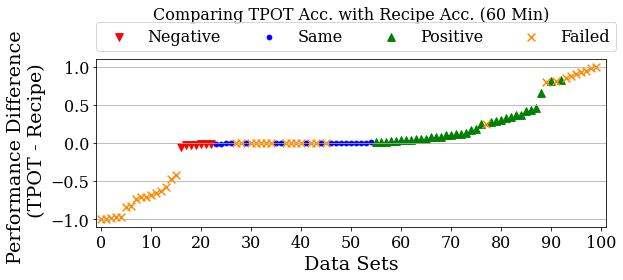

In [103]:
fig = Figure()
tpot = fig.get_sheet()['60 Min'].tpot_accuracy_mean
recipe = fig.get_sheet()['60 Min'].recipe_test_acc
x_label = 'Data Sets'
y_lable = 'Performance Difference \n (TPOT - Recipe)'
title = 'Comparing TPOT Acc. with Recipe Acc. (60 Min)'
fig.compare_acc_scatter(tpot, recipe, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -2.6, and -6.7,  from 5 datasets
 31 datasets have the same performance
Average and Max gain = 20.8 and 82.4,  from 42 datasets
11 datasets failed to run on the left side only
7 datasets failed to run on the right side only
4 datasets failed to run on the both sides
20.8  &  82.4  &  42  &  31  &  5  &  -2.6  &  -6.7


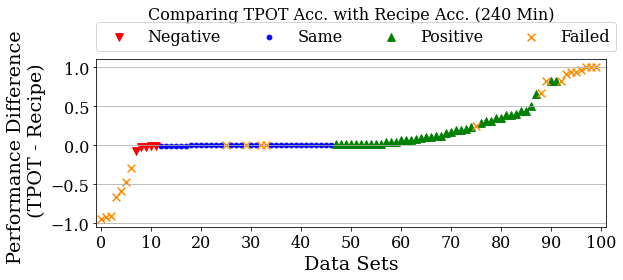

In [104]:
fig = Figure()
tpot = fig.get_sheet()['240 Min'].tpot_accuracy_mean
recipe = fig.get_sheet()['240 Min'].recipe_test_acc
x_label = 'Data Sets'
y_lable = 'Performance Difference \n (TPOT - Recipe)'
title = 'Comparing TPOT Acc. with Recipe Acc. (240 Min)'
fig.compare_acc_scatter(tpot, recipe, x_label, y_lable, title, fig_size=(9, 4))

## TPOT  v.s Recipe

### TPOT
Number of Classifiers : 11 

Number of Preprocessors and Extractors : 14

Number of Feature Selector : 5

### Recipe
Number of Classifiers : 20

Number of Preprocessors and Extractors : 15

Number of Feature Selector : 8

# How much is the performance gain increse by increasing time budget ?

Average and Max loss = -2.3, and -4.3,  from 9 datasets
 73 datasets have the same performance
Average and Max gain = 3.2 and 13.9,  from 17 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.2  &  13.9  &  17  &  73  &  9  &  -2.3  &  -4.3


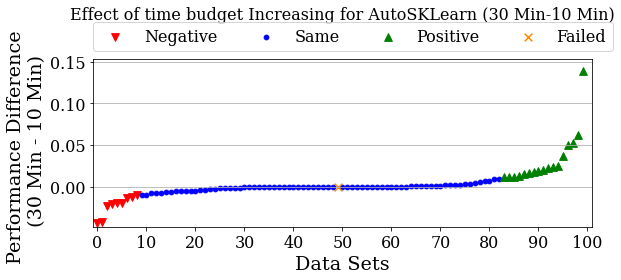

Average and Max loss = -1.8, and -3.0,  from 7 datasets
 71 datasets have the same performance
Average and Max gain = 4.4 and 19.4,  from 21 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.4  &  19.4  &  21  &  71  &  7  &  -1.8  &  -3.0


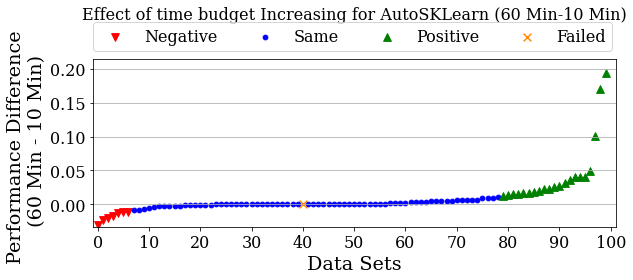

Average and Max loss = -2.7, and -6.2,  from 9 datasets
 69 datasets have the same performance
Average and Max gain = 3.6 and 17.1,  from 21 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.6  &  17.1  &  21  &  69  &  9  &  -2.7  &  -6.2


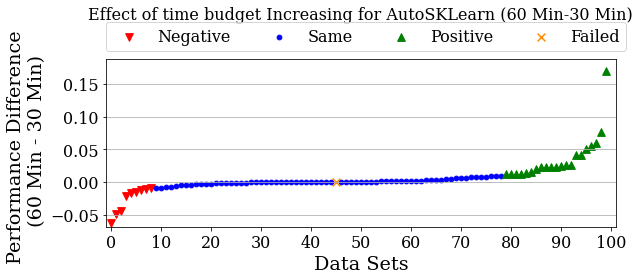

Average and Max loss = -3.2, and -7.7,  from 11 datasets
 62 datasets have the same performance
Average and Max gain = 6.5 and 51.5,  from 26 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
6.5  &  51.5  &  26  &  62  &  11  &  -3.2  &  -7.7


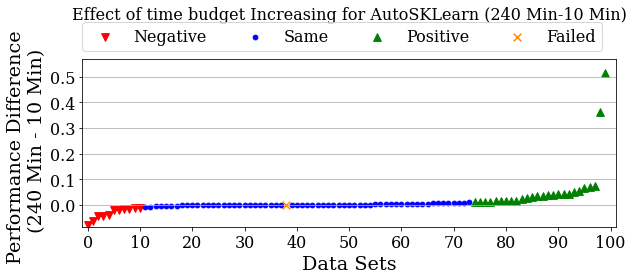

Average and Max loss = -4.0, and -12.5,  from 8 datasets
 66 datasets have the same performance
Average and Max gain = 5.6 and 51.5,  from 25 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.6  &  51.5  &  25  &  66  &  8  &  -4.0  &  -12.5


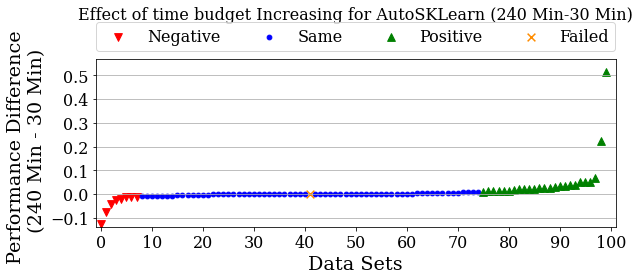

Average and Max loss = -3.3, and -10.3,  from 13 datasets
 64 datasets have the same performance
Average and Max gain = 4.3 and 34.5,  from 22 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.3  &  34.5  &  22  &  64  &  13  &  -3.3  &  -10.3


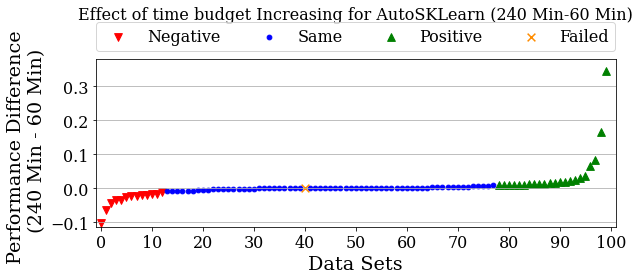

Average and Max loss = -2.9, and -6.2,  from 12 datasets
 69 datasets have the same performance
Average and Max gain = 4.6 and 22.2,  from 18 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.6  &  22.2  &  18  &  69  &  12  &  -2.9  &  -6.2


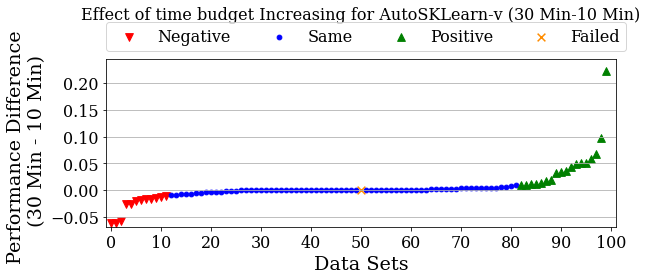

Average and Max loss = -6.4, and -18.8,  from 8 datasets
 63 datasets have the same performance
Average and Max gain = 4.2 and 13.3,  from 28 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.2  &  13.3  &  28  &  63  &  8  &  -6.4  &  -18.8


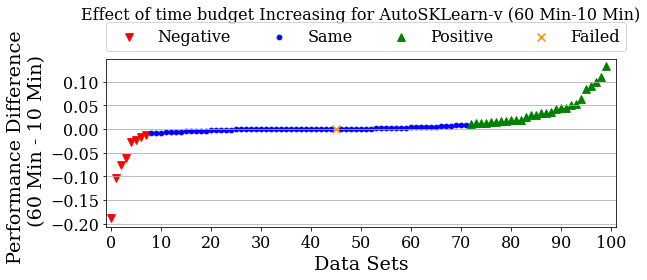

Average and Max loss = -5.1, and -13.9,  from 13 datasets
 63 datasets have the same performance
Average and Max gain = 3.6 and 12.5,  from 23 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.6  &  12.5  &  23  &  63  &  13  &  -5.1  &  -13.9


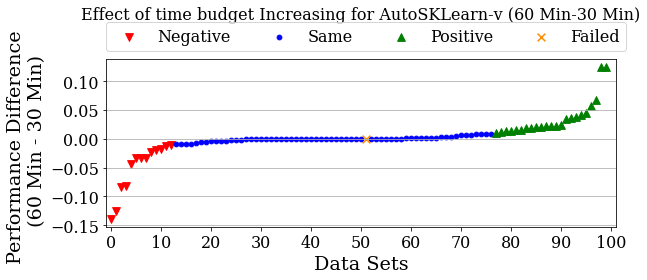

Average and Max loss = -7.0, and -13.5,  from 9 datasets
 59 datasets have the same performance
Average and Max gain = 4.0 and 19.4,  from 31 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.0  &  19.4  &  31  &  59  &  9  &  -7.0  &  -13.5


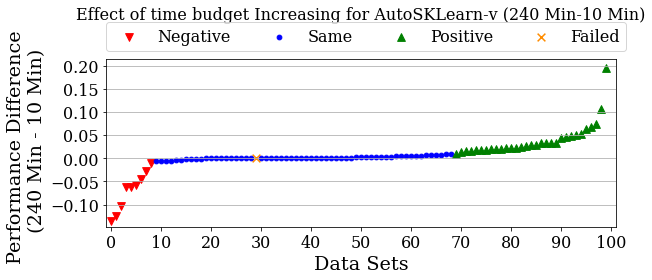

Average and Max loss = -4.3, and -12.5,  from 14 datasets
 57 datasets have the same performance
Average and Max gain = 2.7 and 12.4,  from 28 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
2.7  &  12.4  &  28  &  57  &  14  &  -4.3  &  -12.5


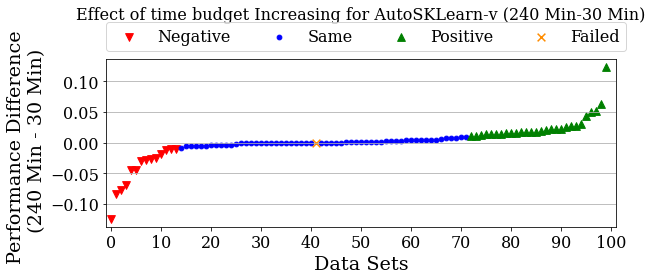

Average and Max loss = -5.8, and -16.7,  from 13 datasets
 62 datasets have the same performance
Average and Max gain = 3.1 and 12.5,  from 24 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.1  &  12.5  &  24  &  62  &  13  &  -5.8  &  -16.7


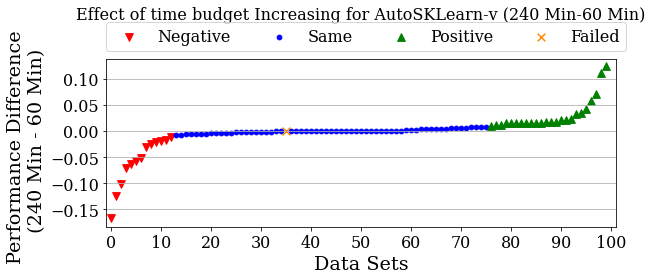

Average and Max loss = -3.4, and -11.2,  from 8 datasets
 67 datasets have the same performance
Average and Max gain = 3.6 and 13.4,  from 24 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.6  &  13.4  &  24  &  67  &  8  &  -3.4  &  -11.2


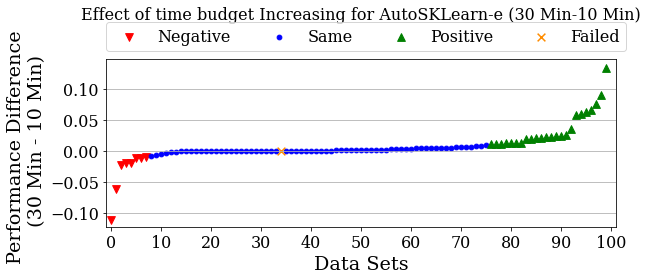

Average and Max loss = -2.4, and -7.7,  from 9 datasets
 65 datasets have the same performance
Average and Max gain = 5.0 and 17.8,  from 25 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.0  &  17.8  &  25  &  65  &  9  &  -2.4  &  -7.7


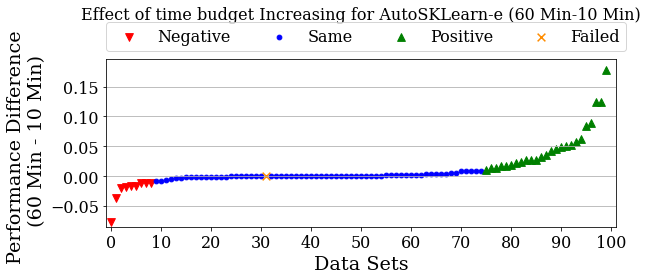

Average and Max loss = -2.4, and -6.7,  from 15 datasets
 66 datasets have the same performance
Average and Max gain = 4.3 and 18.8,  from 18 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.3  &  18.8  &  18  &  66  &  15  &  -2.4  &  -6.7


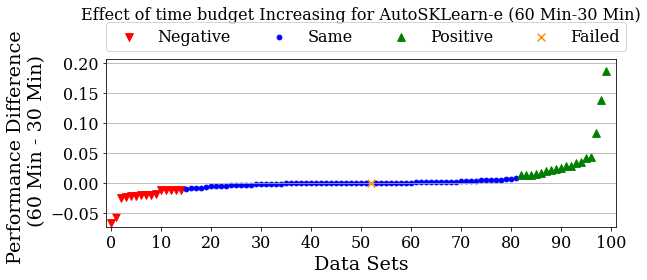

Average and Max loss = -3.6, and -9.6,  from 10 datasets
 57 datasets have the same performance
Average and Max gain = 5.1 and 36.1,  from 32 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.1  &  36.1  &  32  &  57  &  10  &  -3.6  &  -9.6


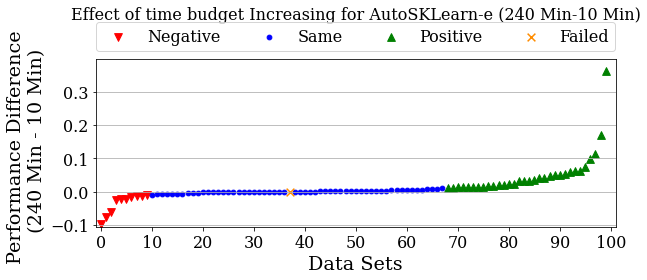

Average and Max loss = -3.8, and -9.4,  from 15 datasets
 62 datasets have the same performance
Average and Max gain = 5.0 and 47.2,  from 22 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.0  &  47.2  &  22  &  62  &  15  &  -3.8  &  -9.4


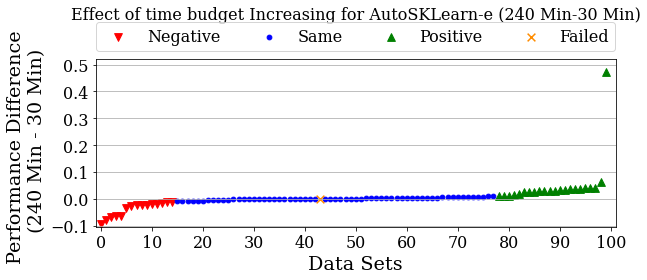

Average and Max loss = -3.8, and -12.5,  from 15 datasets
 64 datasets have the same performance
Average and Max gain = 3.8 and 33.4,  from 20 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.8  &  33.4  &  20  &  64  &  15  &  -3.8  &  -12.5


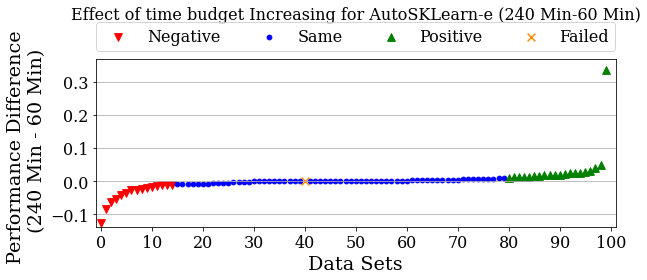

Average and Max loss = -3.0, and -13.3,  from 12 datasets
 68 datasets have the same performance
Average and Max gain = 3.8 and 12.5,  from 19 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.8  &  12.5  &  19  &  68  &  12  &  -3.0  &  -13.3


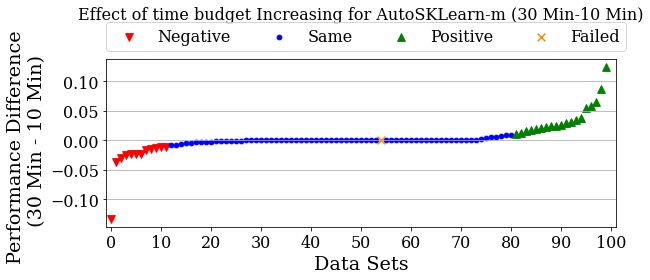

Average and Max loss = -3.9, and -8.3,  from 13 datasets
 65 datasets have the same performance
Average and Max gain = 4.1 and 12.5,  from 21 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.1  &  12.5  &  21  &  65  &  13  &  -3.9  &  -8.3


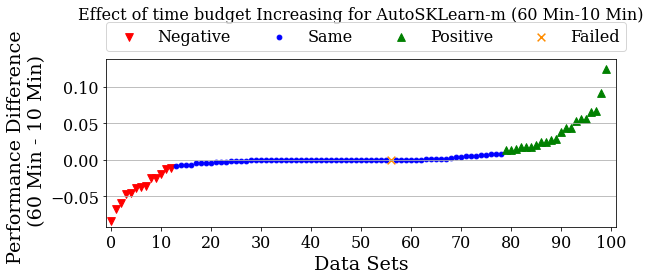

Average and Max loss = -4.1, and -12.5,  from 14 datasets
 71 datasets have the same performance
Average and Max gain = 4.1 and 12.5,  from 14 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.1  &  12.5  &  14  &  71  &  14  &  -4.1  &  -12.5


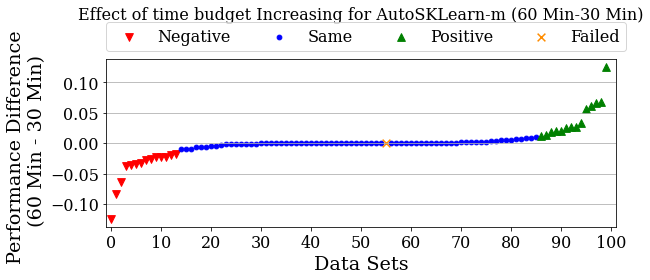

Average and Max loss = -3.1, and -12.5,  from 17 datasets
 57 datasets have the same performance
Average and Max gain = 5.1 and 16.0,  from 25 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.1  &  16.0  &  25  &  57  &  17  &  -3.1  &  -12.5


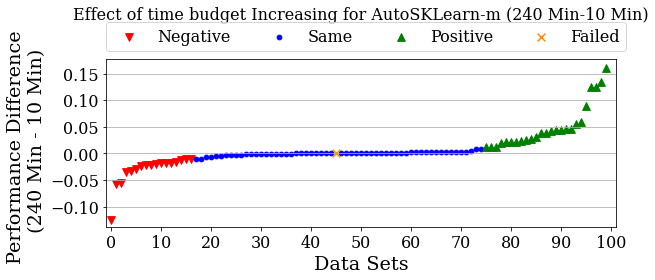

Average and Max loss = -2.9, and -12.5,  from 17 datasets
 66 datasets have the same performance
Average and Max gain = 5.5 and 16.0,  from 16 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.5  &  16.0  &  16  &  66  &  17  &  -2.9  &  -12.5


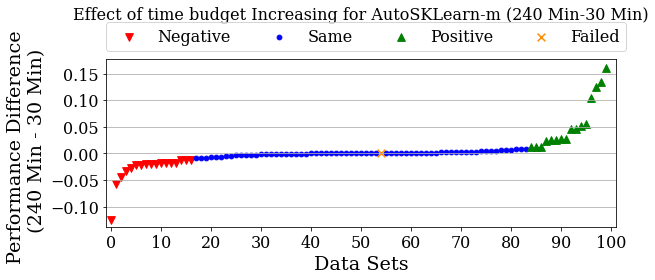

Average and Max loss = -2.7, and -4.9,  from 14 datasets
 66 datasets have the same performance
Average and Max gain = 4.1 and 12.5,  from 19 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.1  &  12.5  &  19  &  66  &  14  &  -2.7  &  -4.9


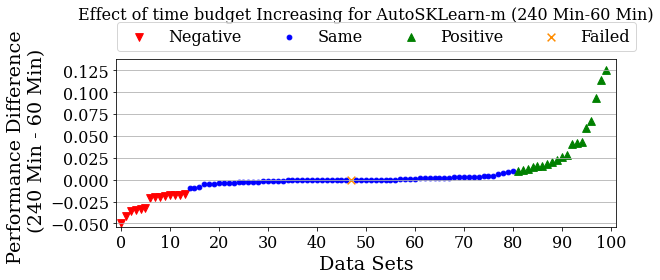

In [105]:
x_label = 'Data Sets'
tools = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m']
acc = ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean']
t =  ['10 Min', '30 Min', '60 Min', '240 Min']
for tool, acc in zip(tools,acc):
    for i in range(1, len(t)):
        for j in range(i):
            fig = Figure()
            first = fig.get_sheet()[t[i]].loc[:, acc]
            second = fig.get_sheet()[t[j]].loc[:, acc]
            y_lable = 'Performance Difference \n (' + t[i] + ' - ' + t[j] + ')'
            title = 'Effect of time budget Increasing for '+ tool + ' ('+ t[i] +'-'+t[j]+ ')'
            fig.compare_acc_scatter(first, second, x_label, y_lable, title, fig_size=(9, 4))

Average and Max loss = -2.3, and -4.3,  from 9 datasets
 73 datasets have the same performance
Average and Max gain = 3.2 and 13.9,  from 17 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.2  &  13.9  &  17  &  73  &  9  &  -2.3  &  -4.3


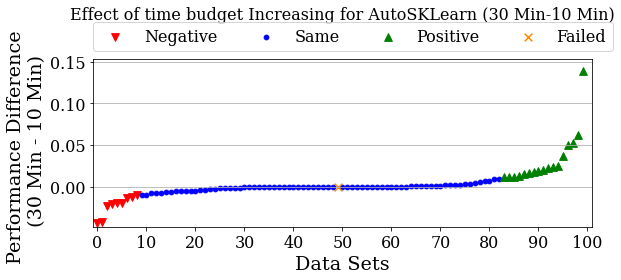

Average and Max loss = -1.8, and -3.0,  from 7 datasets
 71 datasets have the same performance
Average and Max gain = 4.4 and 19.4,  from 21 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.4  &  19.4  &  21  &  71  &  7  &  -1.8  &  -3.0


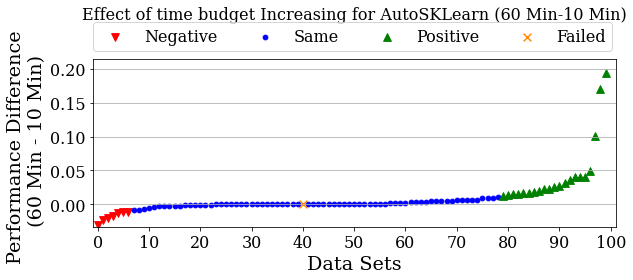

Average and Max loss = -2.7, and -6.2,  from 9 datasets
 69 datasets have the same performance
Average and Max gain = 3.6 and 17.1,  from 21 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.6  &  17.1  &  21  &  69  &  9  &  -2.7  &  -6.2


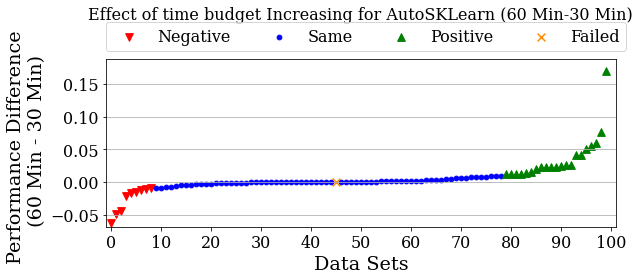

Average and Max loss = -3.2, and -7.7,  from 11 datasets
 62 datasets have the same performance
Average and Max gain = 6.5 and 51.5,  from 26 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
6.5  &  51.5  &  26  &  62  &  11  &  -3.2  &  -7.7


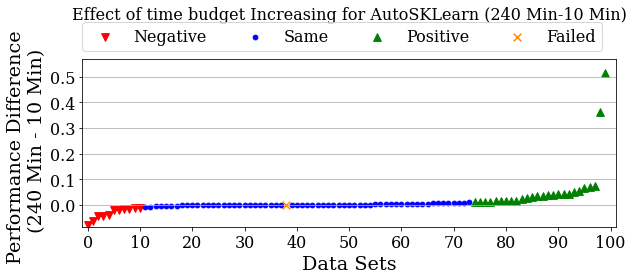

Average and Max loss = -4.0, and -12.5,  from 8 datasets
 66 datasets have the same performance
Average and Max gain = 5.6 and 51.5,  from 25 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.6  &  51.5  &  25  &  66  &  8  &  -4.0  &  -12.5


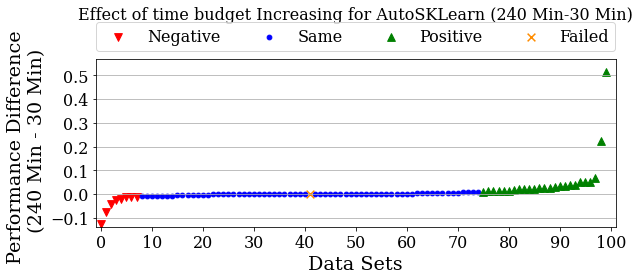

Average and Max loss = -3.3, and -10.3,  from 13 datasets
 64 datasets have the same performance
Average and Max gain = 4.3 and 34.5,  from 22 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.3  &  34.5  &  22  &  64  &  13  &  -3.3  &  -10.3


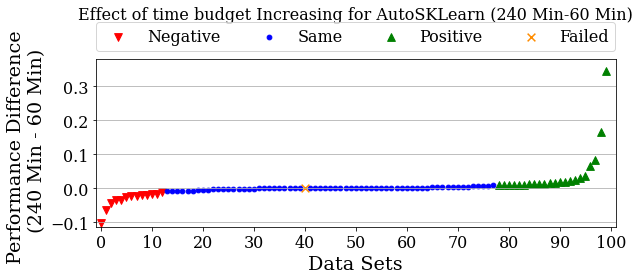

Average and Max loss = -2.9, and -6.2,  from 12 datasets
 69 datasets have the same performance
Average and Max gain = 4.6 and 22.2,  from 18 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.6  &  22.2  &  18  &  69  &  12  &  -2.9  &  -6.2


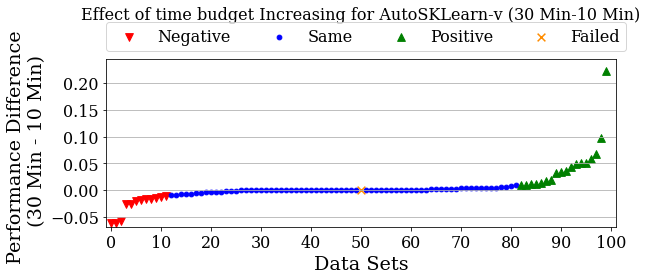

Average and Max loss = -6.4, and -18.8,  from 8 datasets
 63 datasets have the same performance
Average and Max gain = 4.2 and 13.3,  from 28 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.2  &  13.3  &  28  &  63  &  8  &  -6.4  &  -18.8


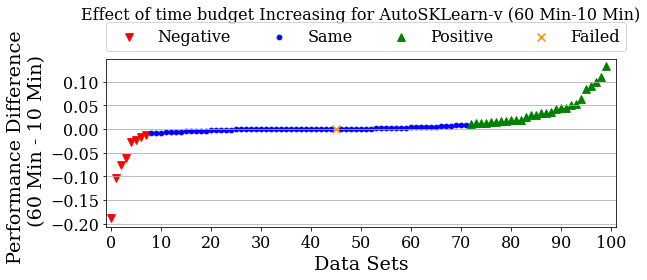

Average and Max loss = -5.1, and -13.9,  from 13 datasets
 63 datasets have the same performance
Average and Max gain = 3.6 and 12.5,  from 23 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.6  &  12.5  &  23  &  63  &  13  &  -5.1  &  -13.9


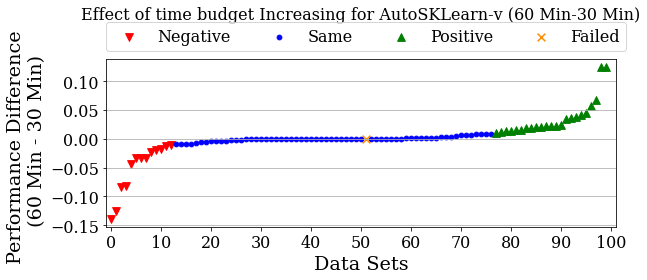

Average and Max loss = -7.0, and -13.5,  from 9 datasets
 59 datasets have the same performance
Average and Max gain = 4.0 and 19.4,  from 31 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.0  &  19.4  &  31  &  59  &  9  &  -7.0  &  -13.5


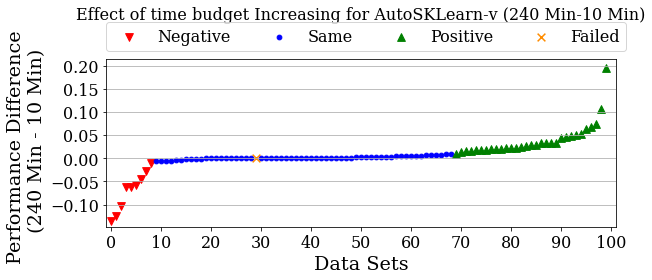

Average and Max loss = -4.3, and -12.5,  from 14 datasets
 57 datasets have the same performance
Average and Max gain = 2.7 and 12.4,  from 28 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
2.7  &  12.4  &  28  &  57  &  14  &  -4.3  &  -12.5


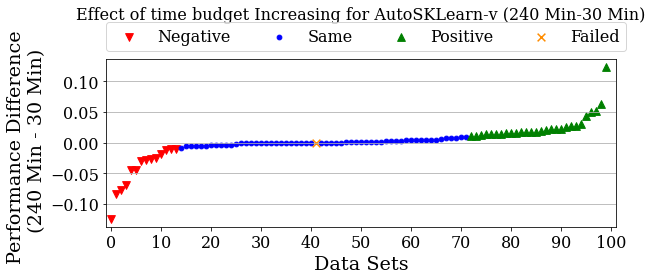

Average and Max loss = -5.8, and -16.7,  from 13 datasets
 62 datasets have the same performance
Average and Max gain = 3.1 and 12.5,  from 24 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.1  &  12.5  &  24  &  62  &  13  &  -5.8  &  -16.7


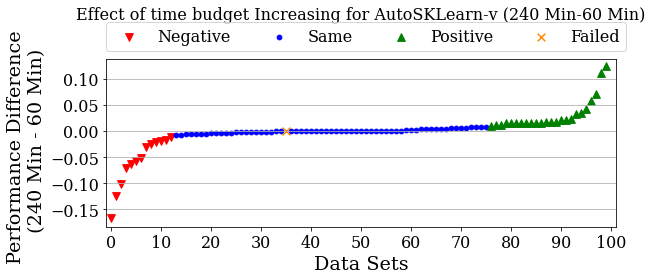

Average and Max loss = -3.4, and -11.2,  from 8 datasets
 67 datasets have the same performance
Average and Max gain = 3.6 and 13.4,  from 24 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.6  &  13.4  &  24  &  67  &  8  &  -3.4  &  -11.2


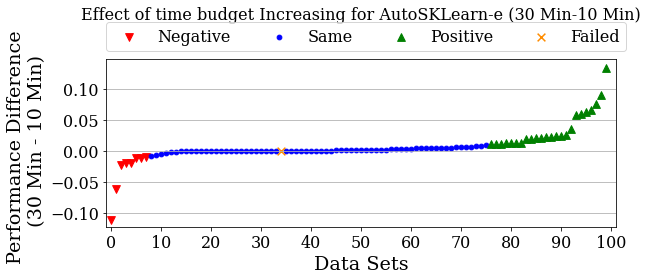

Average and Max loss = -2.4, and -7.7,  from 9 datasets
 65 datasets have the same performance
Average and Max gain = 5.0 and 17.8,  from 25 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.0  &  17.8  &  25  &  65  &  9  &  -2.4  &  -7.7


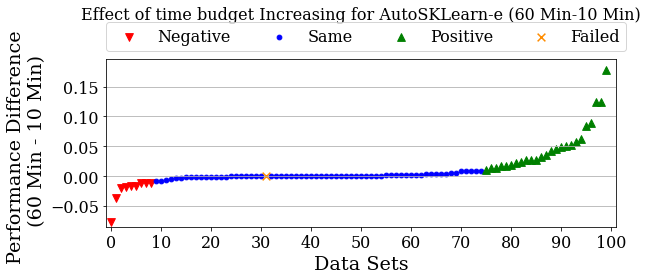

Average and Max loss = -2.4, and -6.7,  from 15 datasets
 66 datasets have the same performance
Average and Max gain = 4.3 and 18.8,  from 18 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.3  &  18.8  &  18  &  66  &  15  &  -2.4  &  -6.7


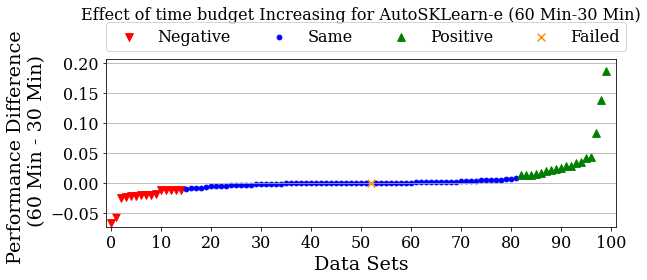

Average and Max loss = -3.6, and -9.6,  from 10 datasets
 57 datasets have the same performance
Average and Max gain = 5.1 and 36.1,  from 32 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.1  &  36.1  &  32  &  57  &  10  &  -3.6  &  -9.6


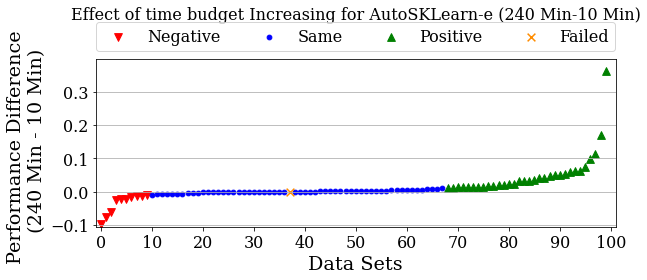

Average and Max loss = -3.8, and -9.4,  from 15 datasets
 62 datasets have the same performance
Average and Max gain = 5.0 and 47.2,  from 22 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.0  &  47.2  &  22  &  62  &  15  &  -3.8  &  -9.4


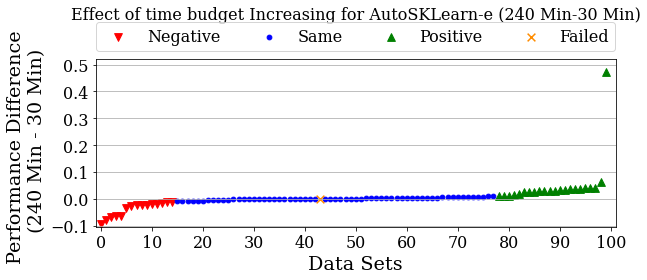

Average and Max loss = -3.8, and -12.5,  from 15 datasets
 64 datasets have the same performance
Average and Max gain = 3.8 and 33.4,  from 20 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.8  &  33.4  &  20  &  64  &  15  &  -3.8  &  -12.5


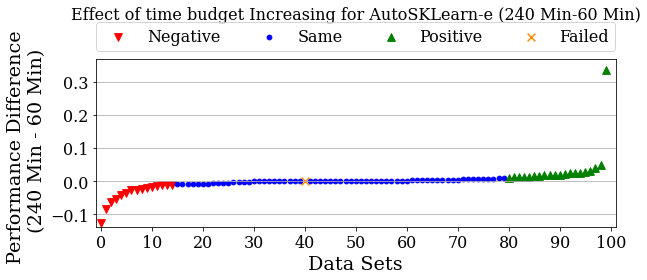

Average and Max loss = -3.0, and -13.3,  from 12 datasets
 68 datasets have the same performance
Average and Max gain = 3.8 and 12.5,  from 19 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
3.8  &  12.5  &  19  &  68  &  12  &  -3.0  &  -13.3


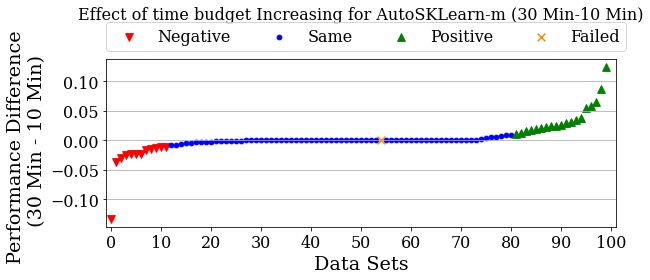

Average and Max loss = -3.9, and -8.3,  from 13 datasets
 65 datasets have the same performance
Average and Max gain = 4.1 and 12.5,  from 21 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.1  &  12.5  &  21  &  65  &  13  &  -3.9  &  -8.3


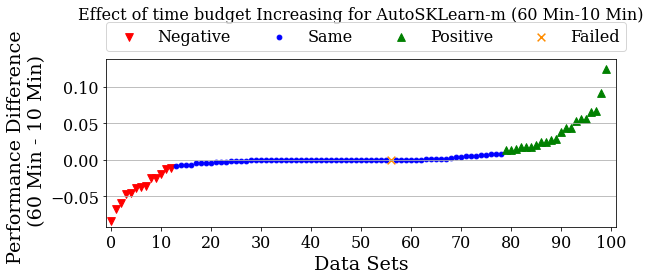

Average and Max loss = -4.1, and -12.5,  from 14 datasets
 71 datasets have the same performance
Average and Max gain = 4.1 and 12.5,  from 14 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.1  &  12.5  &  14  &  71  &  14  &  -4.1  &  -12.5


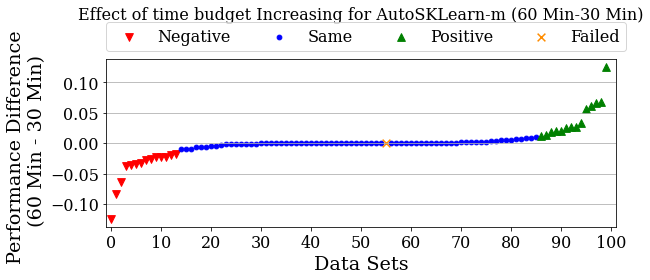

Average and Max loss = -3.1, and -12.5,  from 17 datasets
 57 datasets have the same performance
Average and Max gain = 5.1 and 16.0,  from 25 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.1  &  16.0  &  25  &  57  &  17  &  -3.1  &  -12.5


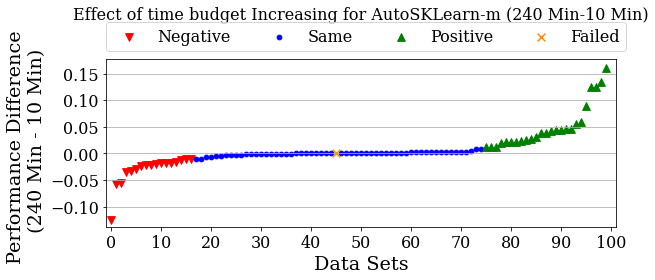

Average and Max loss = -2.9, and -12.5,  from 17 datasets
 66 datasets have the same performance
Average and Max gain = 5.5 and 16.0,  from 16 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.5  &  16.0  &  16  &  66  &  17  &  -2.9  &  -12.5


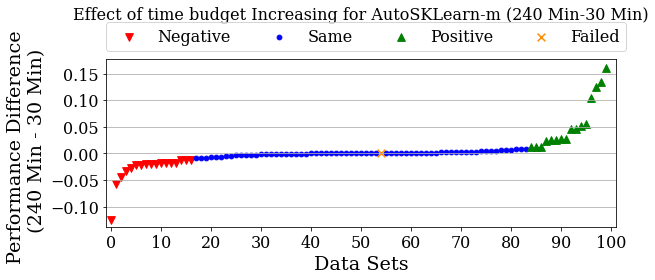

Average and Max loss = -2.7, and -4.9,  from 14 datasets
 66 datasets have the same performance
Average and Max gain = 4.1 and 12.5,  from 19 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.1  &  12.5  &  19  &  66  &  14  &  -2.7  &  -4.9


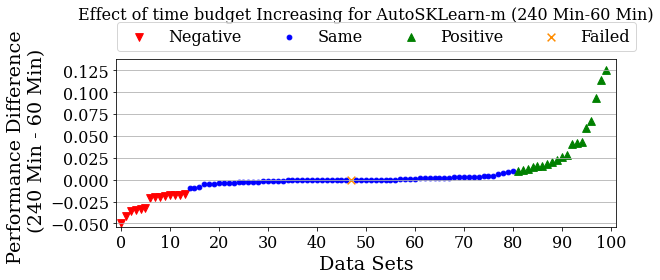

Average and Max loss = -3.8, and -11.5,  from 7 datasets
 65 datasets have the same performance
Average and Max gain = 6.1 and 19.6,  from 14 datasets
4 datasets failed to run on the left side only
0 datasets failed to run on the right side only
10 datasets failed to run on the both sides
6.1  &  19.6  &  14  &  65  &  7  &  -3.8  &  -11.5


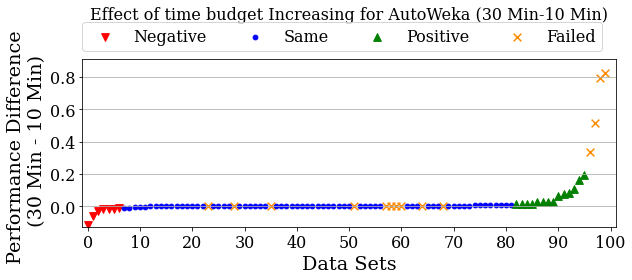

Average and Max loss = -7.9, and -39.9,  from 11 datasets
 58 datasets have the same performance
Average and Max gain = 6.3 and 19.6,  from 17 datasets
5 datasets failed to run on the left side only
0 datasets failed to run on the right side only
9 datasets failed to run on the both sides
6.3  &  19.6  &  17  &  58  &  11  &  -7.9  &  -39.9


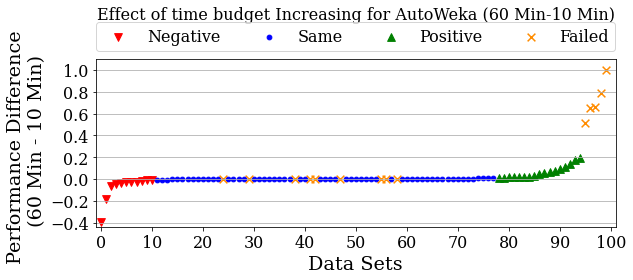

Average and Max loss = -8.1, and -39.9,  from 14 datasets
 66 datasets have the same performance
Average and Max gain = 12.4 and 66.6,  from 10 datasets
1 datasets failed to run on the left side only
0 datasets failed to run on the right side only
9 datasets failed to run on the both sides
12.4  &  66.6  &  10  &  66  &  14  &  -8.1  &  -39.9


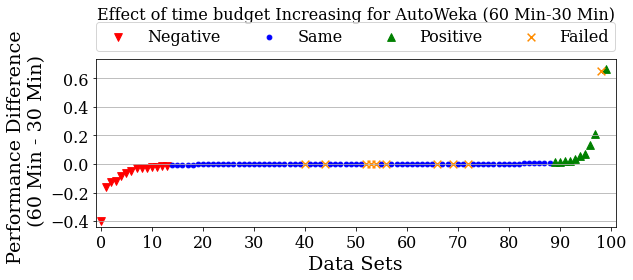

Average and Max loss = -8.7, and -39.9,  from 8 datasets
 54 datasets have the same performance
Average and Max gain = 5.8 and 19.6,  from 24 datasets
10 datasets failed to run on the left side only
0 datasets failed to run on the right side only
4 datasets failed to run on the both sides
5.8  &  19.6  &  24  &  54  &  8  &  -8.7  &  -39.9


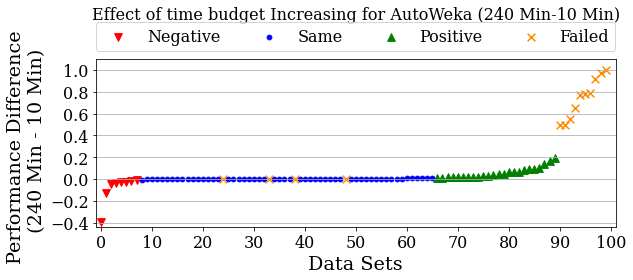

Average and Max loss = -8.4, and -39.9,  from 12 datasets
 59 datasets have the same performance
Average and Max gain = 7.9 and 66.6,  from 19 datasets
6 datasets failed to run on the left side only
0 datasets failed to run on the right side only
4 datasets failed to run on the both sides
7.9  &  66.6  &  19  &  59  &  12  &  -8.4  &  -39.9


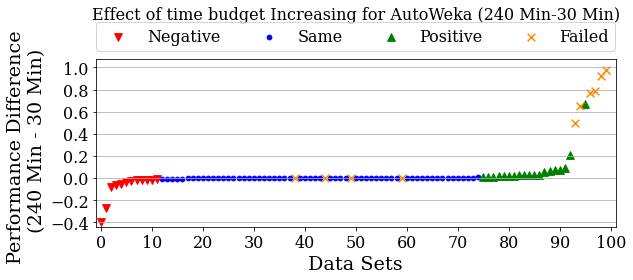

Average and Max loss = -4.4, and -11.3,  from 8 datasets
 66 datasets have the same performance
Average and Max gain = 4.3 and 10.8,  from 17 datasets
5 datasets failed to run on the left side only
0 datasets failed to run on the right side only
4 datasets failed to run on the both sides
4.3  &  10.8  &  17  &  66  &  8  &  -4.4  &  -11.3


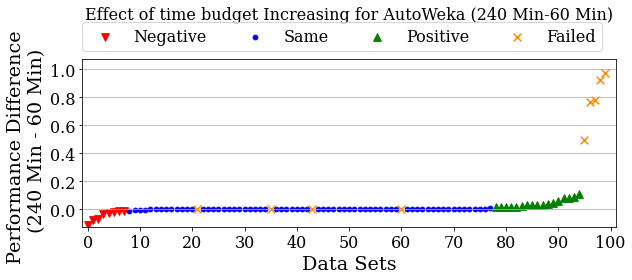

Average and Max loss = -2.0, and -3.7,  from 5 datasets
 28 datasets have the same performance
Average and Max gain = 6.3 and 17.9,  from 7 datasets
19 datasets failed to run on the left side only
3 datasets failed to run on the right side only
38 datasets failed to run on the both sides
6.3  &  17.9  &  7  &  28  &  5  &  -2.0  &  -3.7


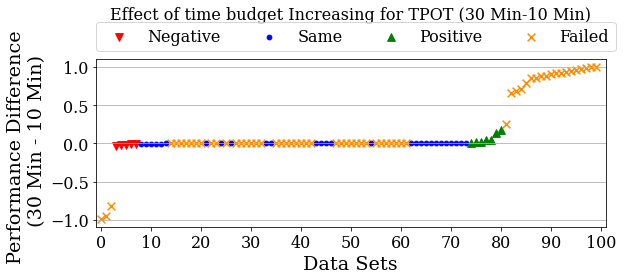

Average and Max loss = -4.1, and -7.0,  from 4 datasets
 32 datasets have the same performance
Average and Max gain = 7.1 and 19.2,  from 7 datasets
27 datasets failed to run on the left side only
0 datasets failed to run on the right side only
30 datasets failed to run on the both sides
7.1  &  19.2  &  7  &  32  &  4  &  -4.1  &  -7.0


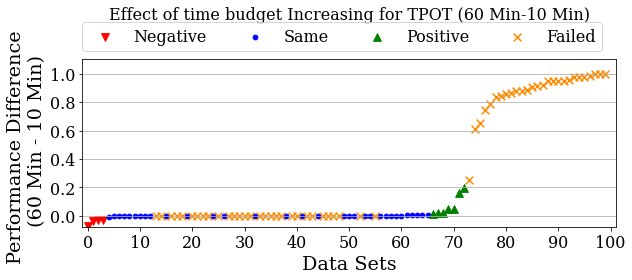

Average and Max loss = -2.9, and -7.0,  from 7 datasets
 43 datasets have the same performance
Average and Max gain = 3.7 and 8.9,  from 6 datasets
14 datasets failed to run on the left side only
3 datasets failed to run on the right side only
27 datasets failed to run on the both sides
3.7  &  8.9  &  6  &  43  &  7  &  -2.9  &  -7.0


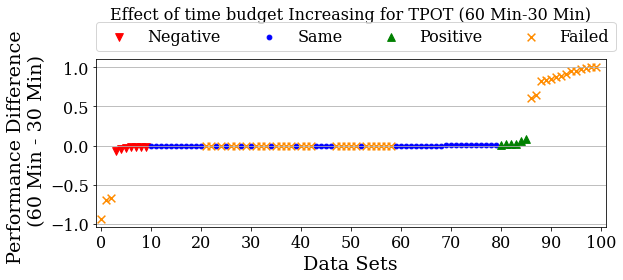

Average and Max loss = -1.9, and -3.5,  from 5 datasets
 24 datasets have the same performance
Average and Max gain = 4.6 and 18.6,  from 14 datasets
46 datasets failed to run on the left side only
0 datasets failed to run on the right side only
11 datasets failed to run on the both sides
4.6  &  18.6  &  14  &  24  &  5  &  -1.9  &  -3.5


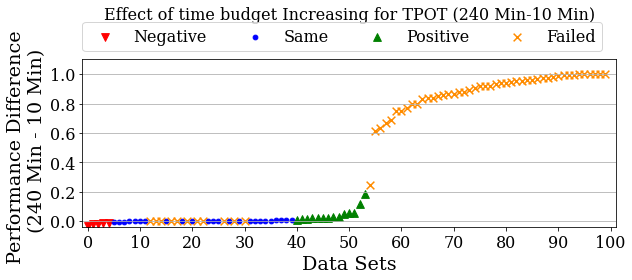

Average and Max loss = -2.3, and -3.5,  from 7 datasets
 34 datasets have the same performance
Average and Max gain = 2.8 and 6.2,  from 17 datasets
31 datasets failed to run on the left side only
1 datasets failed to run on the right side only
10 datasets failed to run on the both sides
2.8  &  6.2  &  17  &  34  &  7  &  -2.3  &  -3.5


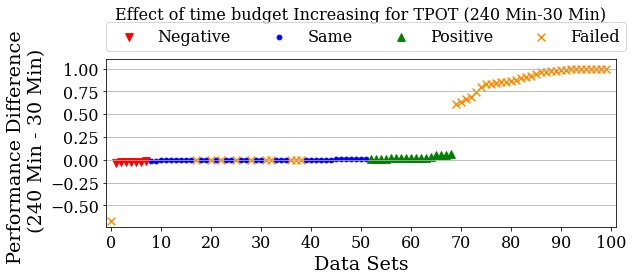

Average and Max loss = -4.1, and -7.7,  from 5 datasets
 46 datasets have the same performance
Average and Max gain = 2.5 and 5.6,  from 19 datasets
19 datasets failed to run on the left side only
0 datasets failed to run on the right side only
11 datasets failed to run on the both sides
2.5  &  5.6  &  19  &  46  &  5  &  -4.1  &  -7.7


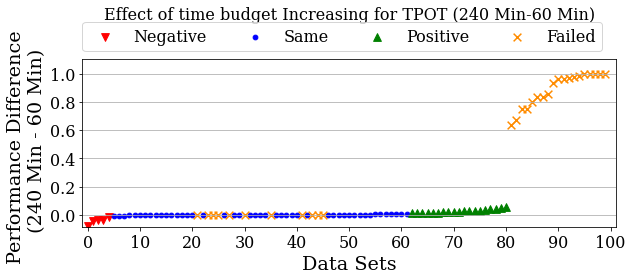

Average and Max loss = -4.1, and -5.4,  from 2 datasets
 17 datasets have the same performance
Average and Max gain = 13.6 and 25.0,  from 2 datasets
48 datasets failed to run on the left side only
12 datasets failed to run on the right side only
19 datasets failed to run on the both sides
13.6  &  25.0  &  2  &  17  &  2  &  -4.1  &  -5.4


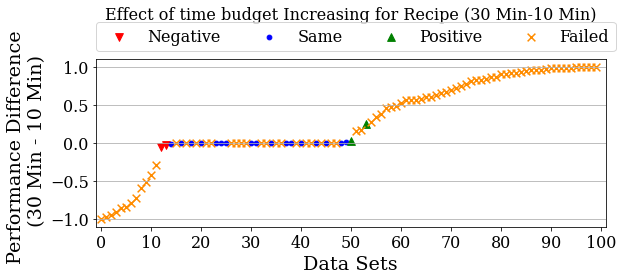

Average and Max loss = -8.8, and -17.8,  from 5 datasets
 16 datasets have the same performance
Average and Max gain = 9.2 and 25.0,  from 5 datasets
50 datasets failed to run on the left side only
7 datasets failed to run on the right side only
17 datasets failed to run on the both sides
9.2  &  25.0  &  5  &  16  &  5  &  -8.8  &  -17.8


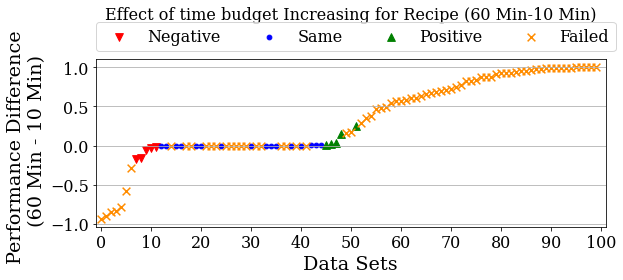

Average and Max loss = -12.5, and -17.8,  from 3 datasets
 59 datasets have the same performance
Average and Max gain = 4.3 and 12.5,  from 5 datasets
9 datasets failed to run on the left side only
2 datasets failed to run on the right side only
22 datasets failed to run on the both sides
4.3  &  12.5  &  5  &  59  &  3  &  -12.5  &  -17.8


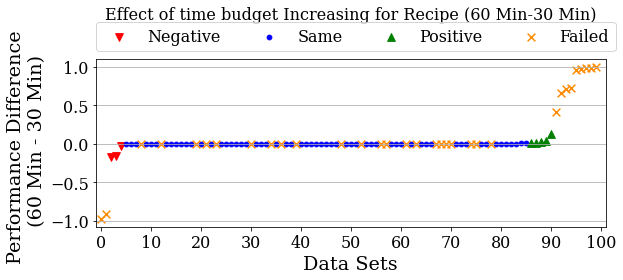

Average and Max loss = -6.5, and -16.4,  from 4 datasets
 18 datasets have the same performance
Average and Max gain = 10.0 and 32.1,  from 10 datasets
53 datasets failed to run on the left side only
1 datasets failed to run on the right side only
14 datasets failed to run on the both sides
10.0  &  32.1  &  10  &  18  &  4  &  -6.5  &  -16.4


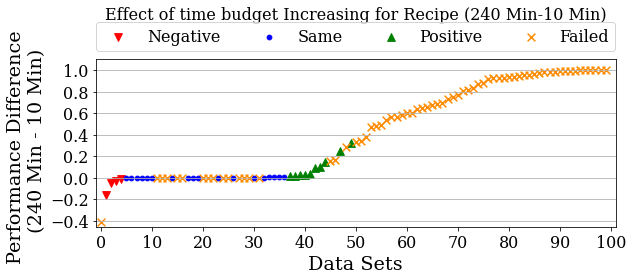

Average and Max loss = -7.1, and -16.4,  from 3 datasets
 57 datasets have the same performance
Average and Max gain = 4.5 and 12.5,  from 9 datasets
16 datasets failed to run on the left side only
0 datasets failed to run on the right side only
15 datasets failed to run on the both sides
4.5  &  12.5  &  9  &  57  &  3  &  -7.1  &  -16.4


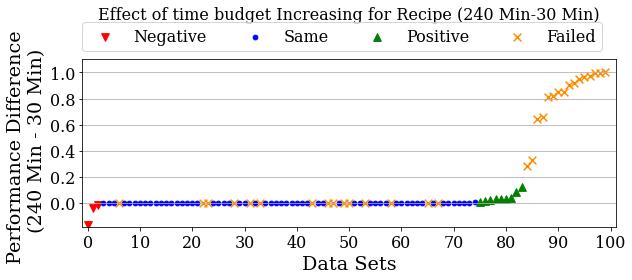

Average and Max loss = -37.5, and -37.5,  from 1 datasets
 70 datasets have the same performance
Average and Max gain = 10.5 and 26.3,  from 4 datasets
10 datasets failed to run on the left side only
1 datasets failed to run on the right side only
14 datasets failed to run on the both sides
10.5  &  26.3  &  4  &  70  &  1  &  -37.5  &  -37.5


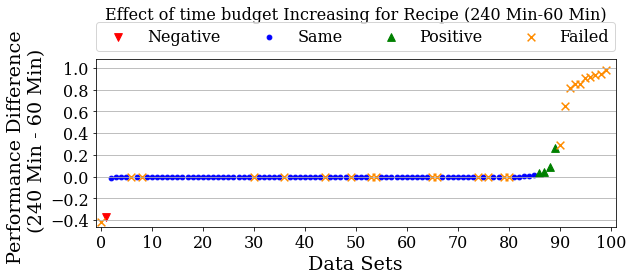

Average and Max loss = -3.6, and -8.3,  from 11 datasets
 64 datasets have the same performance
Average and Max gain = 8.0 and 33.3,  from 13 datasets
2 datasets failed to run on the left side only
1 datasets failed to run on the right side only
9 datasets failed to run on the both sides
8.0  &  33.3  &  13  &  64  &  11  &  -3.6  &  -8.3


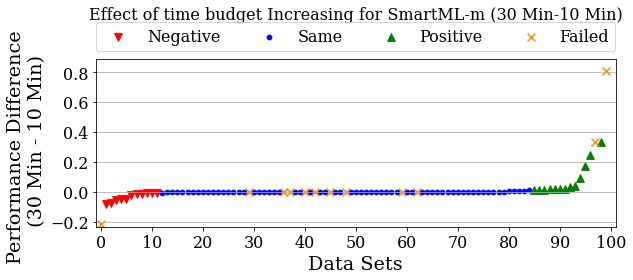

Average and Max loss = -3.3, and -9.3,  from 12 datasets
 64 datasets have the same performance
Average and Max gain = 10.8 and 33.3,  from 11 datasets
2 datasets failed to run on the left side only
2 datasets failed to run on the right side only
9 datasets failed to run on the both sides
10.8  &  33.3  &  11  &  64  &  12  &  -3.3  &  -9.3


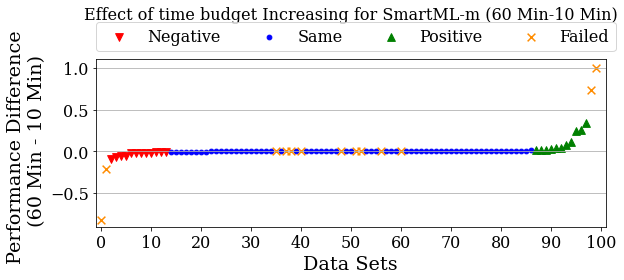

Average and Max loss = -6.2, and -18.3,  from 6 datasets
 73 datasets have the same performance
Average and Max gain = 12.2 and 40.0,  from 10 datasets
0 datasets failed to run on the left side only
1 datasets failed to run on the right side only
10 datasets failed to run on the both sides
12.2  &  40.0  &  10  &  73  &  6  &  -6.2  &  -18.3


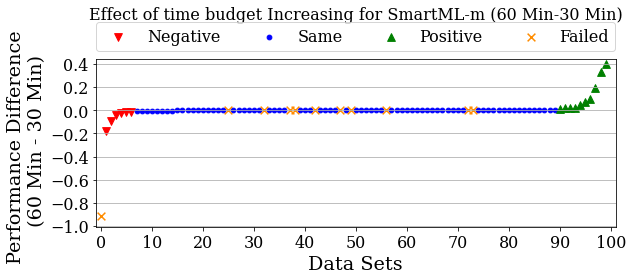

Average and Max loss = -4.1, and -10.6,  from 9 datasets
 58 datasets have the same performance
Average and Max gain = 13.5 and 59.6,  from 20 datasets
2 datasets failed to run on the left side only
2 datasets failed to run on the right side only
9 datasets failed to run on the both sides
13.5  &  59.6  &  20  &  58  &  9  &  -4.1  &  -10.6


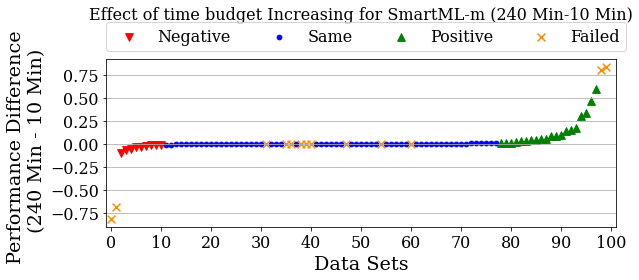

Average and Max loss = -6.8, and -18.0,  from 7 datasets
 61 datasets have the same performance
Average and Max gain = 13.4 and 59.6,  from 20 datasets
1 datasets failed to run on the left side only
2 datasets failed to run on the right side only
9 datasets failed to run on the both sides
13.4  &  59.6  &  20  &  61  &  7  &  -6.8  &  -18.0


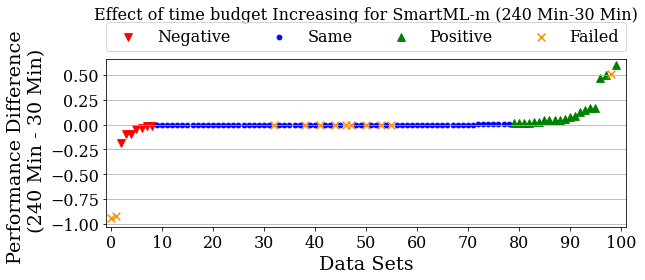

Average and Max loss = -6.6, and -19.4,  from 10 datasets
 59 datasets have the same performance
Average and Max gain = 10.6 and 59.6,  from 19 datasets
1 datasets failed to run on the left side only
1 datasets failed to run on the right side only
10 datasets failed to run on the both sides
10.6  &  59.6  &  19  &  59  &  10  &  -6.6  &  -19.4


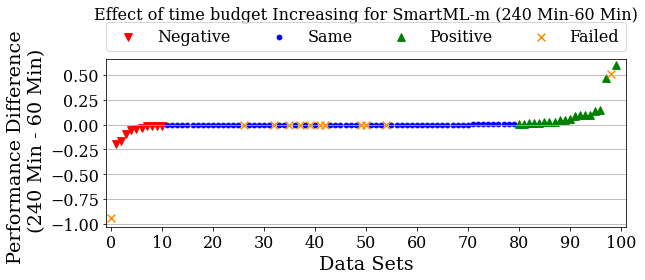

Average and Max loss = -6.3, and -16.9,  from 11 datasets
 67 datasets have the same performance
Average and Max gain = 7.9 and 85.2,  from 18 datasets
0 datasets failed to run on the left side only
1 datasets failed to run on the right side only
3 datasets failed to run on the both sides
7.9  &  85.2  &  18  &  67  &  11  &  -6.3  &  -16.9


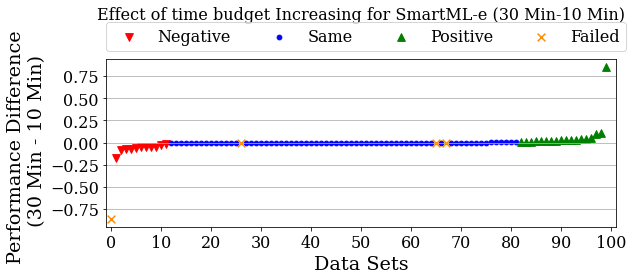

Average and Max loss = -5.2, and -12.2,  from 16 datasets
 62 datasets have the same performance
Average and Max gain = 6.5 and 18.2,  from 17 datasets
0 datasets failed to run on the left side only
2 datasets failed to run on the right side only
3 datasets failed to run on the both sides
6.5  &  18.2  &  17  &  62  &  16  &  -5.2  &  -12.2


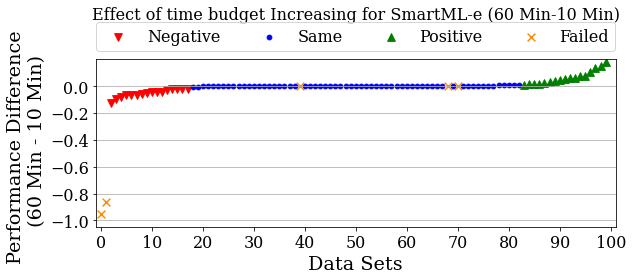

Average and Max loss = -9.0, and -84.3,  from 20 datasets
 54 datasets have the same performance
Average and Max gain = 6.5 and 18.2,  from 21 datasets
0 datasets failed to run on the left side only
1 datasets failed to run on the right side only
4 datasets failed to run on the both sides
6.5  &  18.2  &  21  &  54  &  20  &  -9.0  &  -84.3


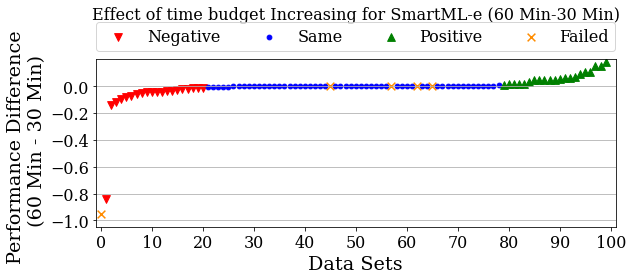

Average and Max loss = -5.8, and -18.8,  from 13 datasets
 62 datasets have the same performance
Average and Max gain = 9.2 and 36.1,  from 20 datasets
0 datasets failed to run on the left side only
2 datasets failed to run on the right side only
3 datasets failed to run on the both sides
9.2  &  36.1  &  20  &  62  &  13  &  -5.8  &  -18.8


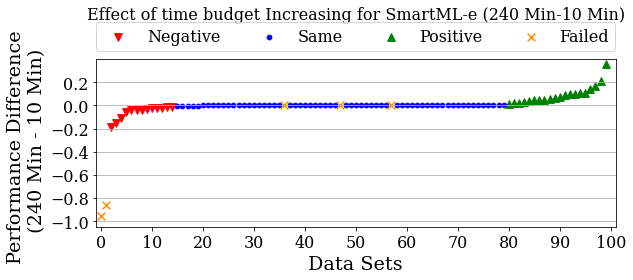

Average and Max loss = -8.9, and -68.8,  from 18 datasets
 54 datasets have the same performance
Average and Max gain = 8.3 and 32.9,  from 23 datasets
0 datasets failed to run on the left side only
1 datasets failed to run on the right side only
4 datasets failed to run on the both sides
8.3  &  32.9  &  23  &  54  &  18  &  -8.9  &  -68.8


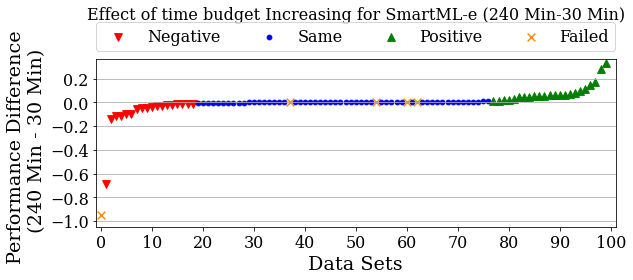

Average and Max loss = -6.9, and -18.8,  from 19 datasets
 53 datasets have the same performance
Average and Max gain = 9.1 and 22.3,  from 23 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
5 datasets failed to run on the both sides
9.1  &  22.3  &  23  &  53  &  19  &  -6.9  &  -18.8


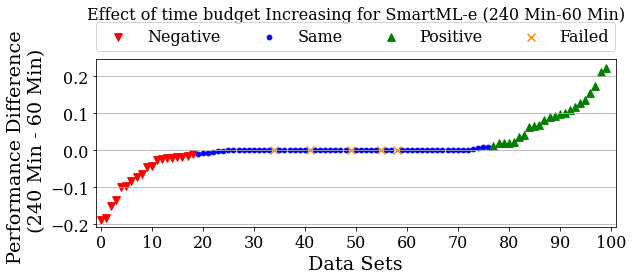

Average and Max loss = -4.7, and -21.0,  from 13 datasets
 33 datasets have the same performance
Average and Max gain = 4.2 and 21.0,  from 21 datasets
7 datasets failed to run on the left side only
8 datasets failed to run on the right side only
18 datasets failed to run on the both sides
4.2  &  21.0  &  21  &  33  &  13  &  -4.7  &  -21.0


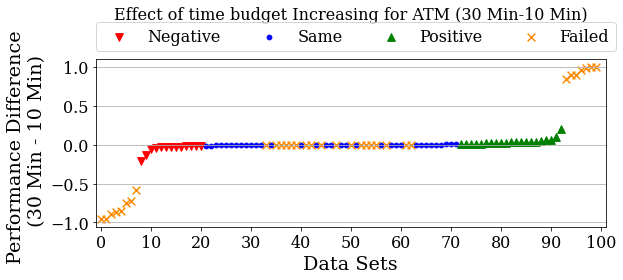

Average and Max loss = -6.2, and -19.6,  from 19 datasets
 34 datasets have the same performance
Average and Max gain = 5.4 and 21.0,  from 18 datasets
8 datasets failed to run on the left side only
4 datasets failed to run on the right side only
17 datasets failed to run on the both sides
5.4  &  21.0  &  18  &  34  &  19  &  -6.2  &  -19.6


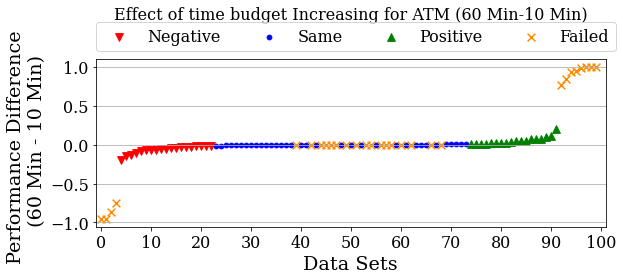

Average and Max loss = -6.6, and -25.0,  from 19 datasets
 35 datasets have the same performance
Average and Max gain = 4.5 and 16.7,  from 15 datasets
10 datasets failed to run on the left side only
5 datasets failed to run on the right side only
16 datasets failed to run on the both sides
4.5  &  16.7  &  15  &  35  &  19  &  -6.6  &  -25.0


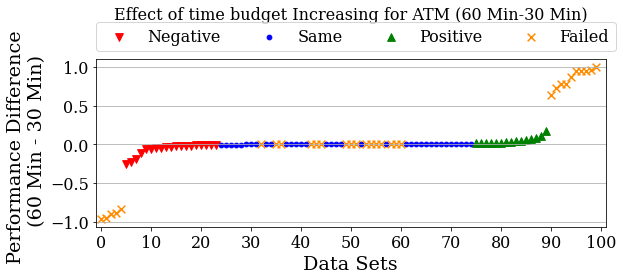

Average and Max loss = -4.3, and -13.0,  from 18 datasets
 34 datasets have the same performance
Average and Max gain = 4.9 and 21.0,  from 21 datasets
13 datasets failed to run on the left side only
2 datasets failed to run on the right side only
12 datasets failed to run on the both sides
4.9  &  21.0  &  21  &  34  &  18  &  -4.3  &  -13.0


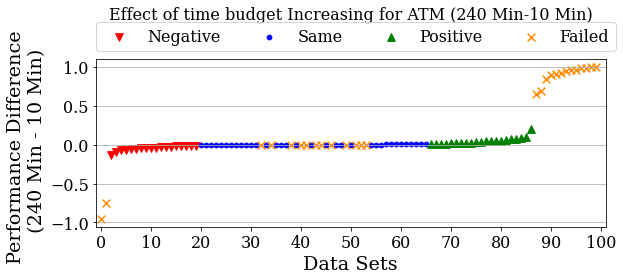

Average and Max loss = -4.6, and -18.8,  from 17 datasets
 40 datasets have the same performance
Average and Max gain = 3.3 and 9.1,  from 16 datasets
13 datasets failed to run on the left side only
1 datasets failed to run on the right side only
13 datasets failed to run on the both sides
3.3  &  9.1  &  16  &  40  &  17  &  -4.6  &  -18.8


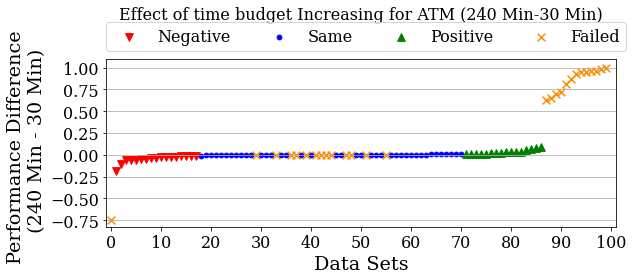

Average and Max loss = -4.0, and -13.9,  from 16 datasets
 41 datasets have the same performance
Average and Max gain = 5.3 and 26.8,  from 20 datasets
9 datasets failed to run on the left side only
2 datasets failed to run on the right side only
12 datasets failed to run on the both sides
5.3  &  26.8  &  20  &  41  &  16  &  -4.0  &  -13.9


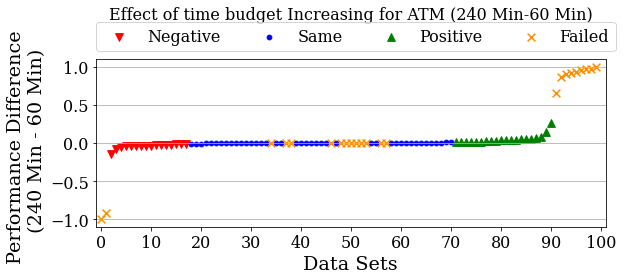

In [106]:
x_label = 'Data Sets'
tools = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m', 'AutoWeka', 'TPOT', 'Recipe', 'SmartML-m', 'SmartML-e', 'ATM']
acc = ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'smartml_e_valid_acc', 'atm_acc']
t =  ['10 Min', '30 Min', '60 Min', '240 Min']
for tool, acc in zip(tools,acc):
    for i in range(1, len(t)):
        for j in range(i):
            fig = Figure()
            first = fig.get_sheet()[t[i]].loc[:, acc]
            second = fig.get_sheet()[t[j]].loc[:, acc]
            y_lable = 'Performance Difference \n (' + t[i] + ' - ' + t[j] + ')'
            title = 'Effect of time budget Increasing for '+ tool + ' ('+ t[i] +'-'+t[j]+ ')'
            fig.compare_acc_scatter(first, second, x_label, y_lable, title, fig_size=(9, 4))

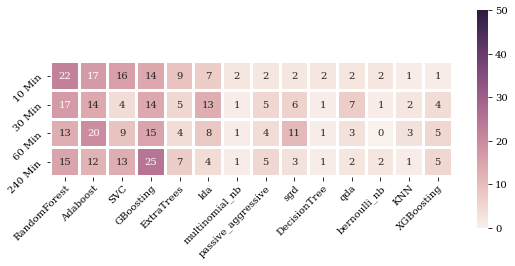

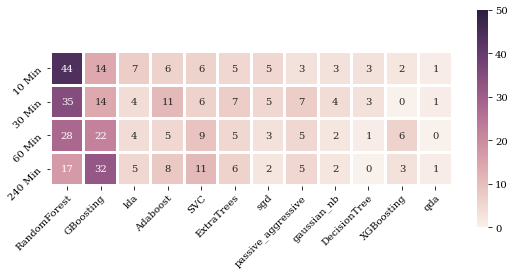

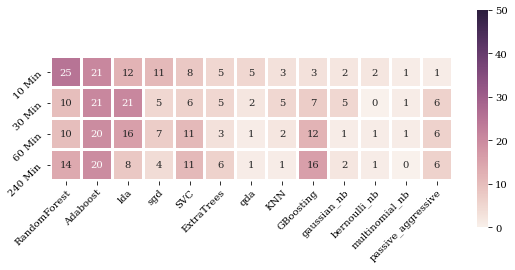

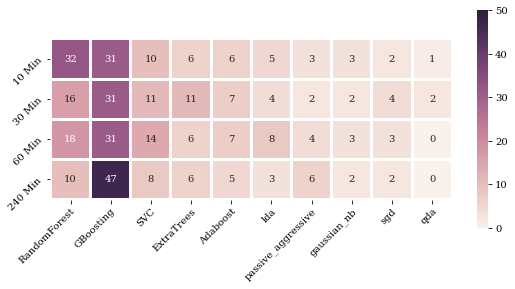

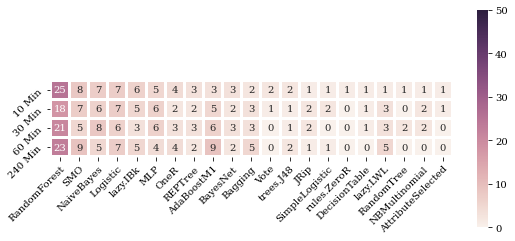

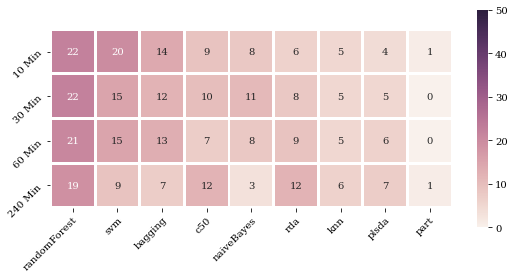

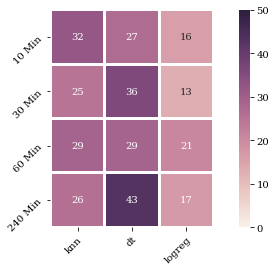

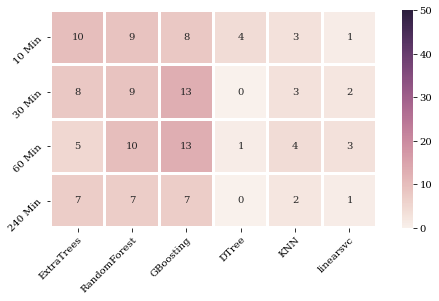

In [107]:
tools = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m', 'AutoWeka', 'SmartML-m', 'ATM', 'TPOT']
models = ['sklearn_model_1', 'sklearn_v_model_1', 'sklearn_e_model_1', 'sklearn_m_model_1',
            'autoweka_model_1', 'smartml_model', 'ATM_classifier', 'tpot_classifier']
for tool, model in zip(tools,models):
    fig = Figure()
    fig.draw_heat_map(model, tool, fig_size=(9,4), divide_data=False)

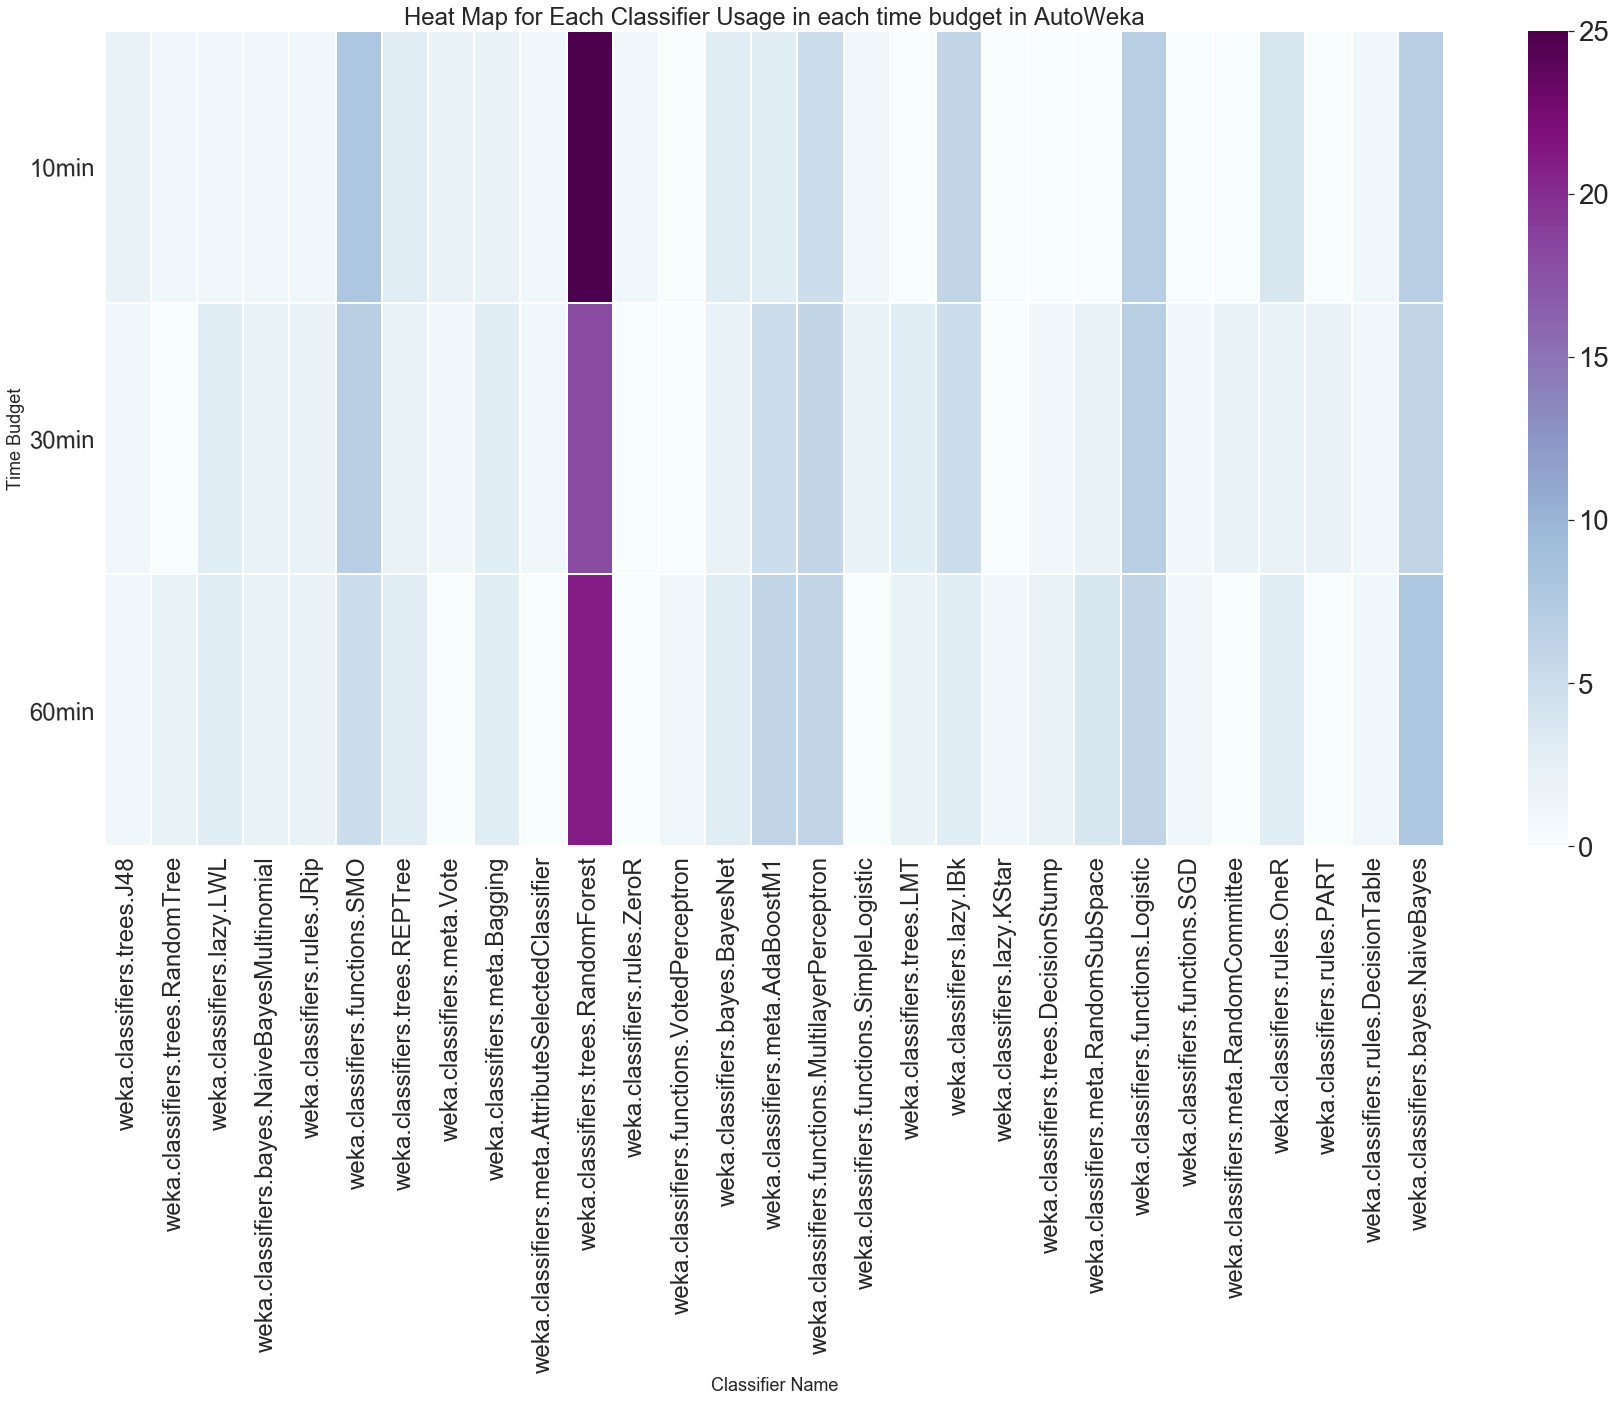

In [84]:
#### Most frequesnt classifiers chosen by AutoWeka
Image('weka_most.png')

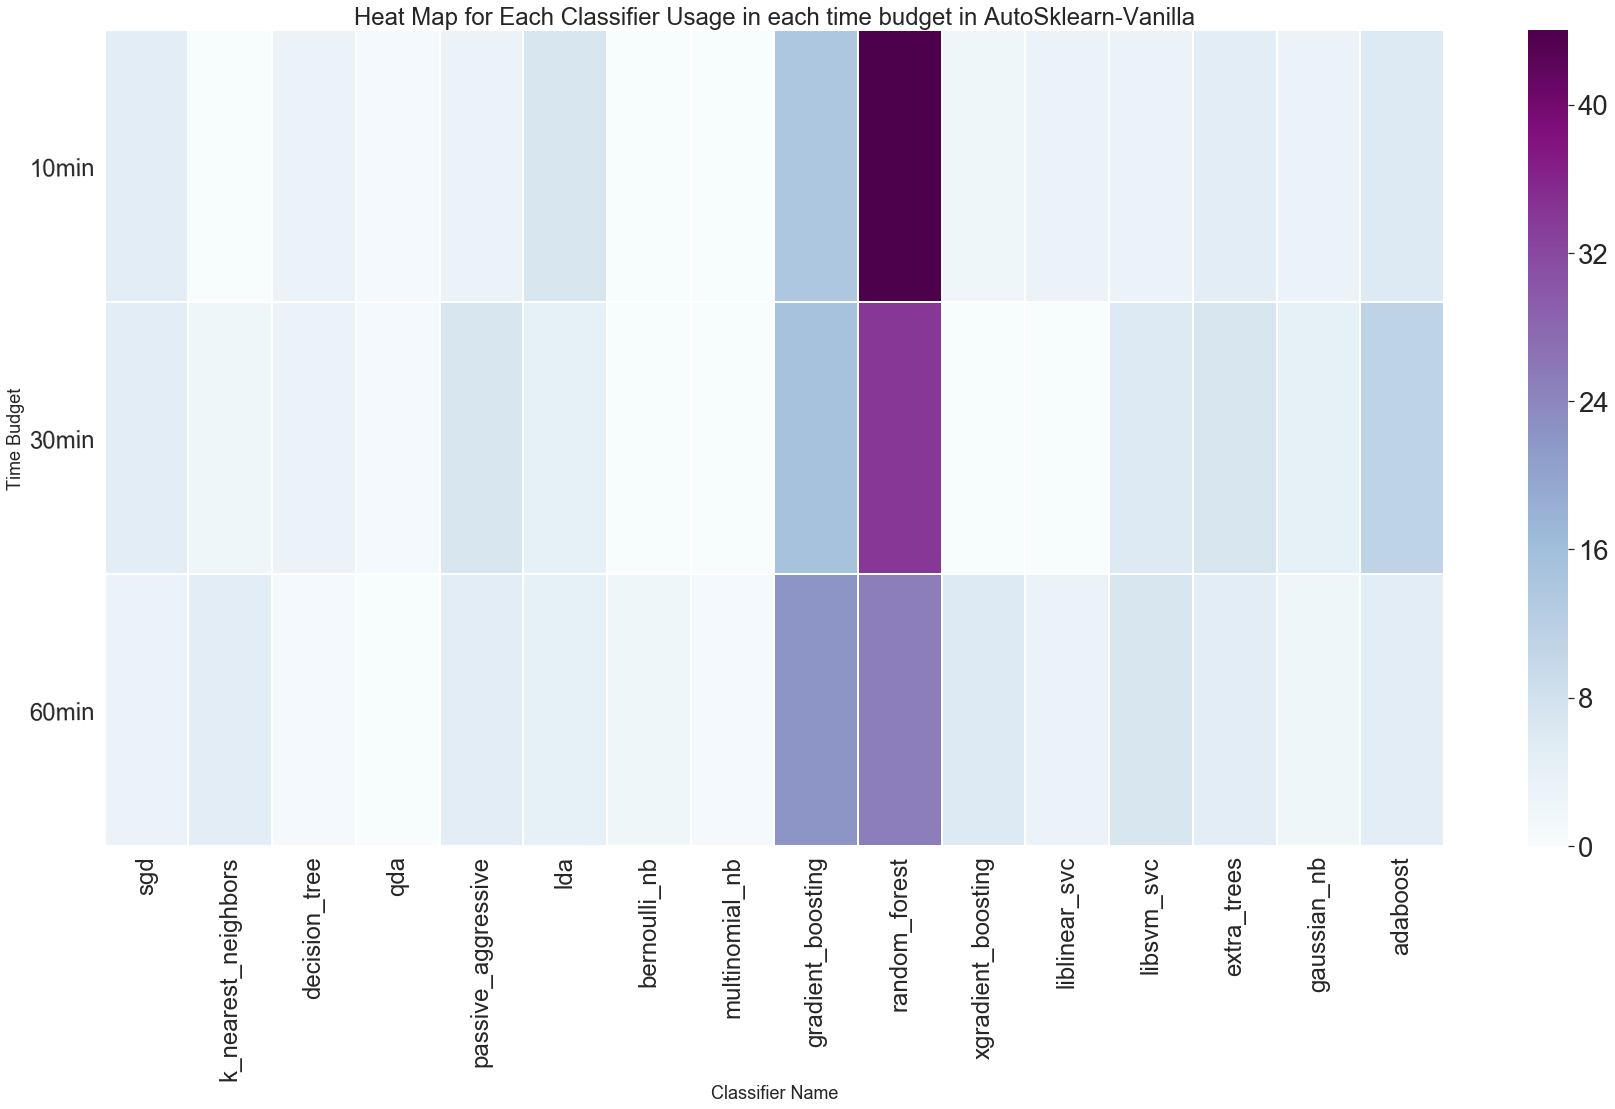

In [85]:
#### Most frequesnt classifiers chosen by AutoSklearn
Image('sklearn_most.png')

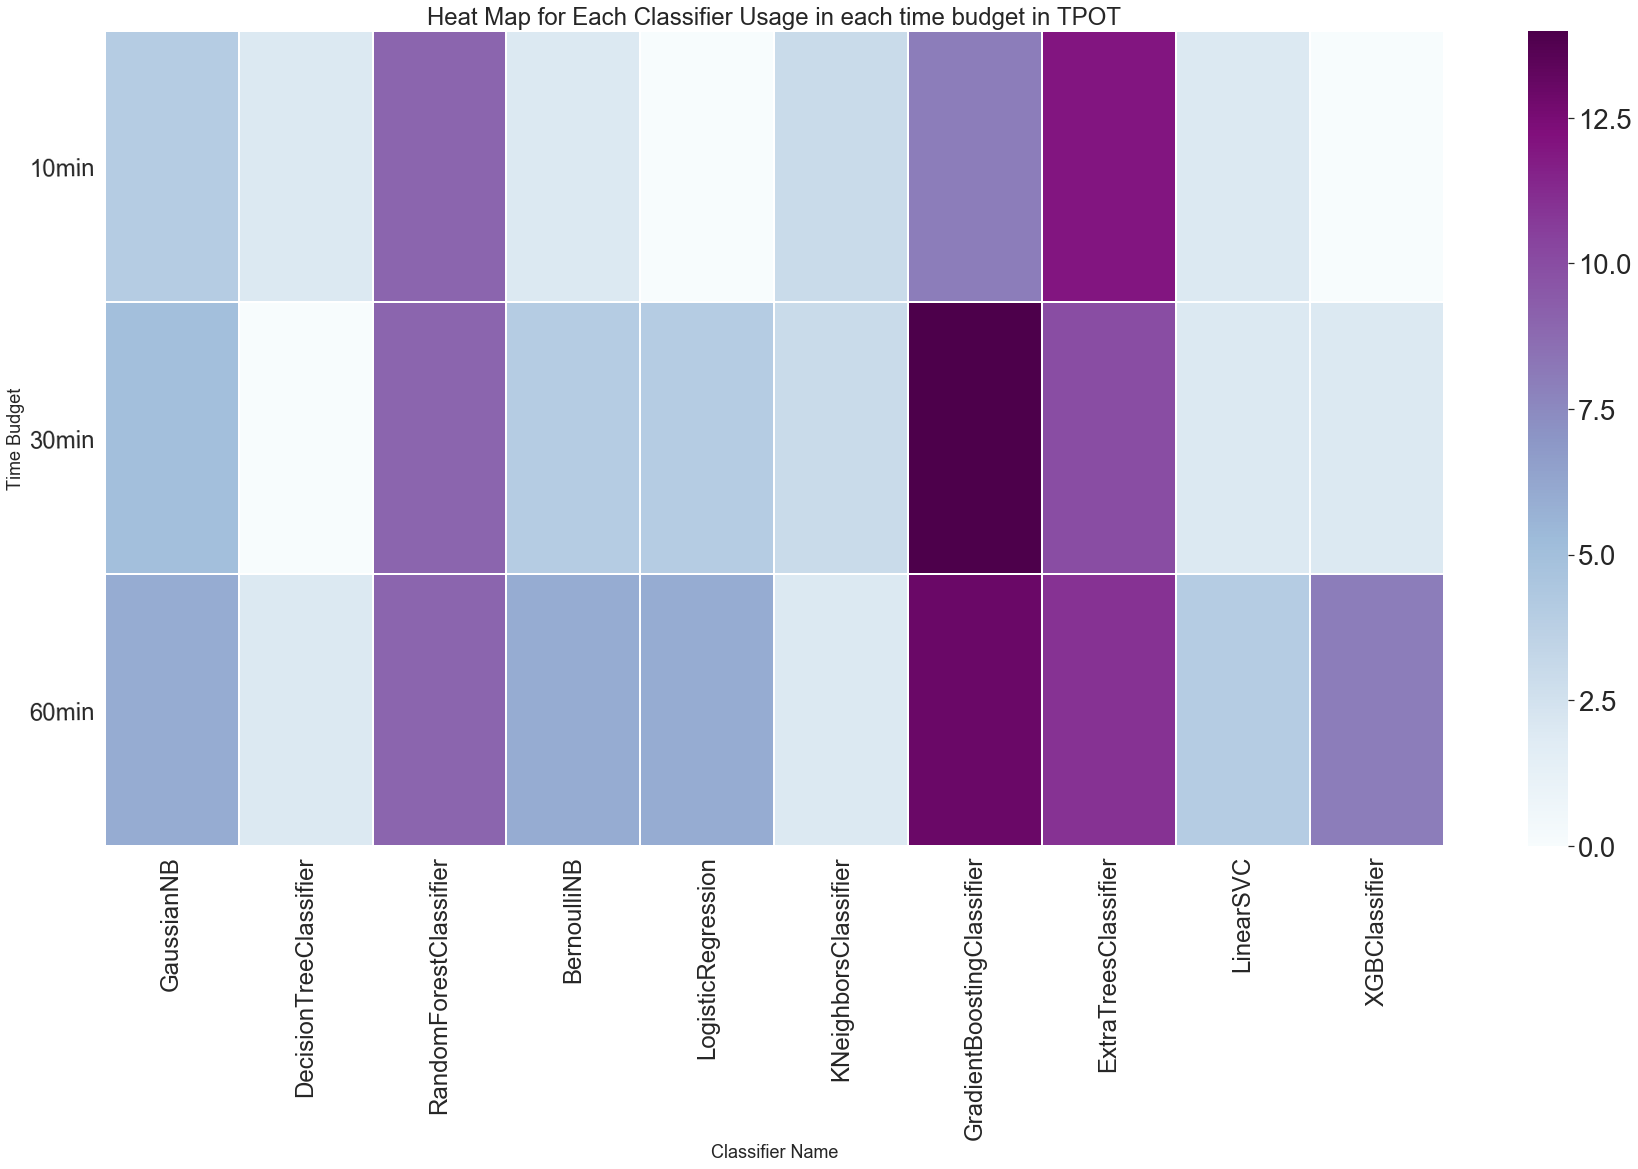

In [86]:
#### Most frequesnt classifiers chosen by TPOT
Image('tpot.png')

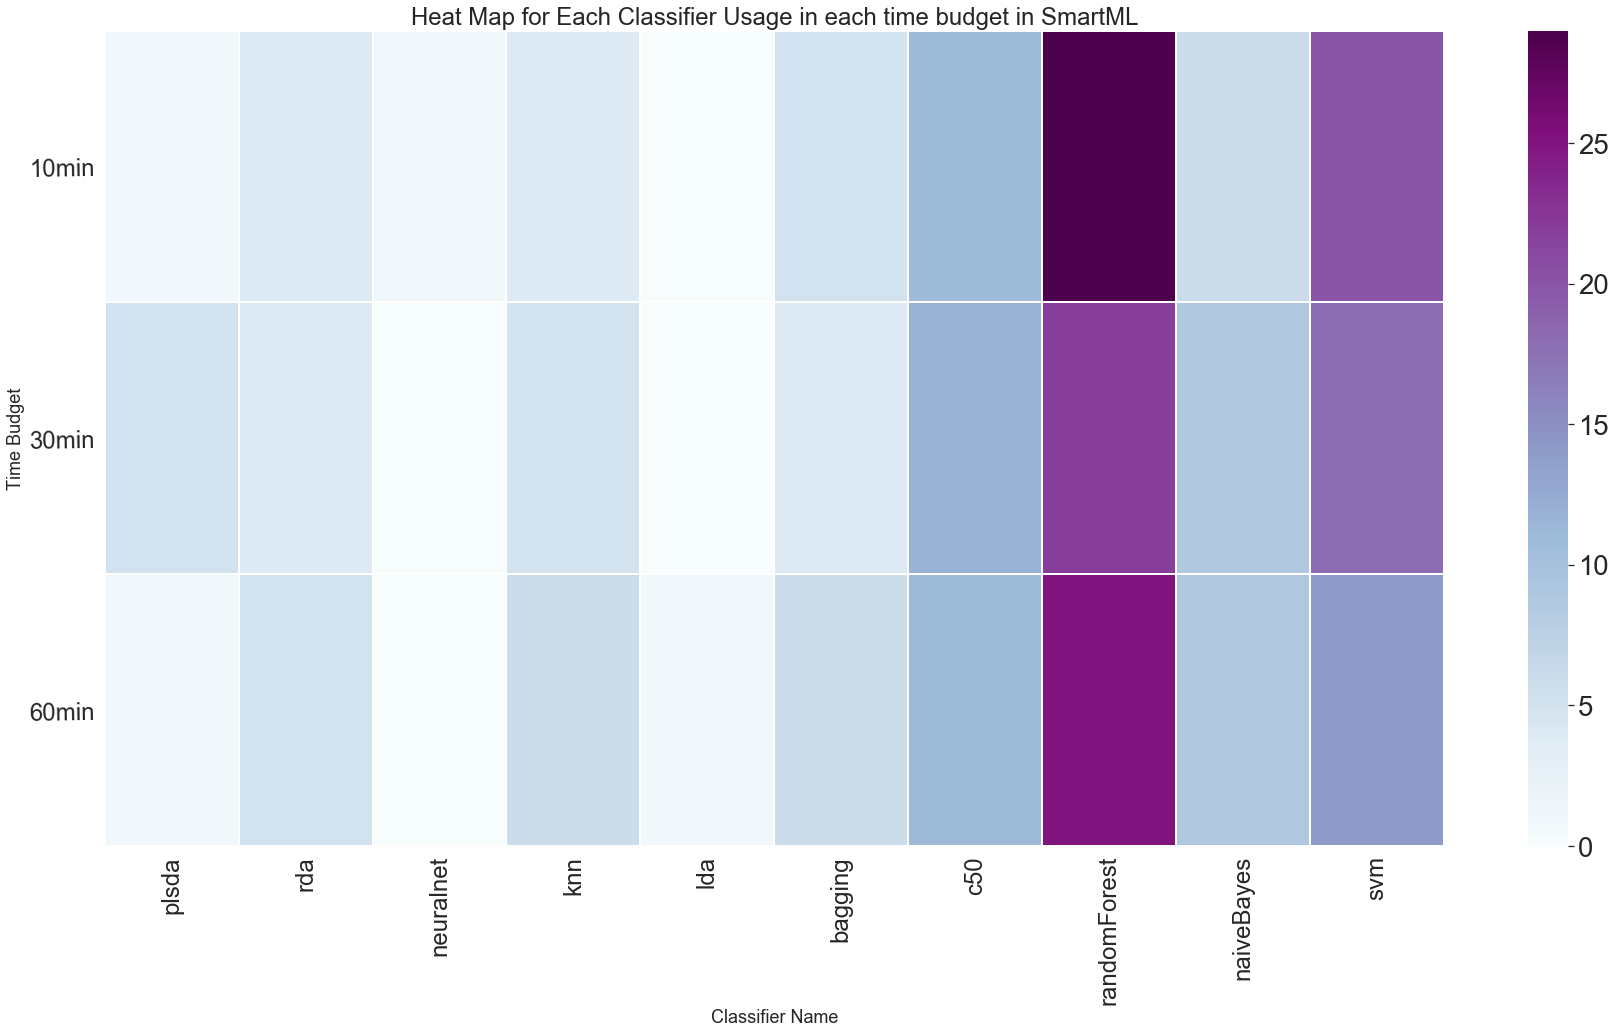

In [87]:
#### Most frequesnt classifiers chosen by SmartML
Image('smartml.png')

#  Output pipelines for datasets where TPOT outperform AutoSklearn

************ CHURN DATASET ************ <br>
<b>TPOT:</b> <br>
Pipeline(memory=None,steps=[('extratreesclassifier')]) <br><br>

<b>AutoSklearn:</b><br>
{'balancing:strategy': 'none', <br>
'categorical_encoding:__choice__': 'one_hot_encoding',  <br>
'classifier:__choice__': 'random_forest',  <br>
'imputation:strategy': 'mean', <br>
'preprocessor:__choice__': 'no_preprocessing', <br>
'rescaling:__choice__': 'standardize', <br>
'categorical_encoding:one_hot_encoding}<br><br><br>

<hr>

************ Adult DATASET ************ <br>
<b>TPOT: </b> <br>
Pipeline(memory=None, steps=[('gradientboostingclassifier')]) <br><br>

<b>AutoSklearn:</b> <br>
{'balancing:strategy': 'none', <br>
'categorical_encoding:__choice__': 'one_hot_encoding', <br>
'classifier:__choice__': 'random_forest', <br>
'imputation:strategy': 'median', <br>
'preprocessor:__choice__': 'feature_agglomeration', <br>
'rescaling:__choice__': 'robust_scaler', <br>
'categorical_encoding:one_hot_encoding} <br><br><br>

<hr>

************ Yeast DATASET ************ <br>
<b>TPOT: </b> <br>
Pipeline(memory=None, steps=[('randomforestclassifier')]) <br><br>

<b>AutoSklearn:</b> <br>
{'balancing:strategy': 'none', <br>
'categorical_encoding:__choice__': 'one_hot_encoding', <br>
'classifier:__choice__': 'extra_trees', <br>
'imputation:strategy': 'median', <br>
'preprocessor:__choice__': 'feature_agglomeration', <br>
'rescaling:__choice__': 'normalize', <br>
'categorical_encoding:one_hot_encoding } <br><br><br>

<hr>

************ Eucalputus DATASET ************<br>
<b>TPOT:</b><br>
Pipeline(memory=None, steps=[('polynomialfeatures', 'gradientboostingclassifier')])<br><br>


<b>AutoSklearn:</b><br>
({'balancing:strategy': 'none', <br>
'categorical_encoding:__choice__': 'no_encoding', <br>
'classifier:__choice__': 'extra_trees', <br>
'imputation:strategy': 'most_frequent', <br>
'preprocessor:__choice__': 'polynomial', <br>
'rescaling:__choice__': 'normalize'<br>

<hr>

************ Ecoli DATASET ************ <br>
<b>TPOT:</b><br>
Pipeline(memory=None, steps=[('featureunion', transformer_list=[('rbfsampler', 'functiontransformer')]) <br><br>

<b>AutoSklearn:</b> <br>
{'balancing:strategy': 'weighting', <br>
'categorical_encoding:__choice__': 'no_encoding', <br>
'classifier:__choice__': 'libsvm_svc', <br>
'imputation:strategy': 'median', <br>
'preprocessor:__choice__': 'random_trees_embedding', <br>
'rescaling:__choice__': 'standardize'}<br>


### AutoSklearn Search Space:
#### Classifiers (11):
1. Adaboost
2. BernoulliNB
3. GaussianNB
4. DecisionTreeClassifier
5. ExtraTreesClassifier
6. RandomForestClassifier
7. GradientBoostingClassifier
8. KNeighborsClassifier
9. svm.LinearSVC and non linear
10. LogisticRegression
11. XGBClassifier
12. LDA
13. Multinomial Naive-Bayes
14. SGD
15. QDA
16. Passive Aggressive

#### Preprocessors & Extractors (16):
1. Densifier
2. FastICA
3. cluster.FeatureAgglomeration
4. ExtraTrees
5. KernelPCA
6. Normalizer
7. Nystroem Sampler
8. PCA
9. PolynomialFeatures
10. Select Percentile
11. OneHotEncoder
12. Kitchen Sink
13. Imputation
14. Balancing
15. Variance Threshold
16. Rescaling

#### Feature Selectors (1):
1. truncated SVD

# F1 Score Analysis

# How often each tool succeeded to deliver a pipeline within the given time budget?

In [88]:
sheet_path = r'./../AutoML Benchmarking Results.xlsx'
result = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min - F1 Score', '60 Min - F1 Score'])
#result[experiment_time[0]].head(10)
experiment_time = ['10 Min - F1 Score', '60 Min - F1 Score']
experiment_time1 = ['10 Min', '60 Min']
frameworks = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML-m']
autoSKLearn = [np.sum(result[experiment_time[0]].AutoSkLearn> 0),
            np.sum(result[experiment_time[1]].AutoSkLearn> 0)]
autoSKLearn_v = [np.sum(result[experiment_time[0]].loc[:,'AutoSkLearn - Vanilla']> 0),
            np.sum(result[experiment_time[1]].loc[:, 'AutoSkLearn - Vanilla']> 0)]
autoSKLearn_e = [np.sum(result[experiment_time[0]].loc[:, 'AutoSkLearn - Vanilla + Ensembling']> 0),
            np.sum(result[experiment_time[1]].loc[:, 'AutoSkLearn - Vanilla + Ensembling']> 0)]
autoSKLearn_m = [np.sum(result[experiment_time[0]].loc[:, 'AutoSkLearn - Vanilla + MetaLearning']> 0),
            np.sum(result[experiment_time[1]].loc[:, 'AutoSkLearn - Vanilla + MetaLearning']> 0)]
autoweka = [np.sum(result[experiment_time[0]].AutoWeka> 0),
            np.sum(result[experiment_time[1]].AutoWeka> 0)]
TPOT = [np.sum(result[experiment_time[0]].TPot> 0),
            np.sum(result[experiment_time[1]].TPot> 0)]
Recipe = [np.sum(result[experiment_time[0]].Receipe> 0),
            np.sum(result[experiment_time[1]].Receipe> 0)]
SmartML = [np.sum(result[experiment_time[0]].SmartML> 0),
            np.sum(result[experiment_time[1]].SmartML> 0)]
numerical = [autoSKLearn,
             autoSKLearn_v,
             autoSKLearn_e,
             autoSKLearn_m,
             autoweka,
             TPOT,
             Recipe,
             SmartML]
#rint(np.sum(result['10 Min'].autoweka_accuracy_mean > 0))
#rint((result['10 Min'].autoweka_accuracy_mean > 0).to_string())
number_groups = len(frameworks) 
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(len(experiment_time)) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(len(experiment_time)) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(experiment_time1)
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of datasets')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of datasets in which the tool has succeeded to return a model (F1 Score)', pad = 45)
plt.show()])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(len(experiment_time)) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(len(experiment_time)) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(experiment_time1)
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of datasets')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of datasets in which the tool has succeeded to return a model (F1 Score)', pad = 45)
plt.show()])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(len(experiment_time)) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(len(experiment_time)) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(experiment_time1)
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of datasets')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of datasets in which the tool has succeeded to return a model (F1 Score)', pad = 45)
plt.show()])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(len(experiment_time)) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(len(experiment_time)) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(experiment_time1)
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of datasets')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of datasets in which the tool has succeeded to return a model (F1 Score)', pad = 45)
plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-88-2826533dc2a4>, line 35)

# How many times each tool has been the best performance? (F1 Score)

In [90]:
types= ['AutoSkLearn', 'AutoSkLearn - Vanilla', 'AutoSkLearn - Vanilla + Ensembling',
         'AutoSkLearn - Vanilla + MetaLearning', 'AutoWeka', 'TPot', 'Receipe', 'SmartML-m']
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML-m', 'ATM']
T=[]
for t in experiment_time:
    total = [0,0,0,0,0,0,0,0]
    for i in range(100):
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))
#print(s)
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit
for i in range(len(types)-1):
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))

line1, = ax.plot(t, s[7],linestyle='-',label=labels[7])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[7],
           #color= next(gray_colors),
           marker =next(markers))
ax.set(xlabel='Time Budget', ylabel='No. of datasets',title='No. of datasets in which the tool has acheived the best performance (F1 Score)')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([0, 45])
plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
plt.show()])
for i in range(len(types)-1):
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))

line1, = ax.plot(t, s[7],linestyle='-',label=labels[7])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[7],
           #color= next(gray_colors),
           marker =next(markers))
ax.set(xlabel='Time Budget', ylabel='No. of datasets',title='No. of datasets in which the tool has acheived the best performance (F1 Score)')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([0, 45])
plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
plt.show()])
for i in range(len(types)-1):
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))

line1, = ax.plot(t, s[7],linestyle='-',label=labels[7])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[7],
           #color= next(gray_colors),
           marker =next(markers))
ax.set(xlabel='Time Budget', ylabel='No. of datasets',title='No. of datasets in which the tool has acheived the best performance (F1 Score)')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([0, 45])
plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
plt.show()])
for i in range(len(types)-1):
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))

line1, = ax.plot(t, s[7],linestyle='-',label=labels[7])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[7],
           #color= next(gray_colors),
           marker =next(markers))
ax.set(xlabel='Time Budget', ylabel='No. of datasets',title='No. of datasets in which the tool has acheived the best performance (F1 Score)')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([0, 45])
plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-90-5f94ee5e032d>, line 28)

In [92]:
types= ['AutoSkLearn', 'AutoSkLearn - Vanilla', 'AutoSkLearn - Vanilla + Ensembling',
         'AutoSkLearn - Vanilla + MetaLearning', 'AutoWeka', 'TPot', 'Receipe', 'SmartML-m']
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML-m']
T=[]
for t in experiment_time:
    total = [0,0,0,0,0,0,0,0]
    for i in range(100):
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))


sheet_path = r'./../Complete_Sheet.xlsx'
result_acc = pd.read_excel(sheet_path, na_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min',  '60 Min'])

types=[ "sklearn_accuracy_mean", "sklearn_v_accuracy_mean", "sklearn_e_accuracy_mean", "sklearn_m_accuracy_mean",
       "autoweka_accuracy_mean", "tpot_accuracy_mean", "recipe_test_acc", "smartml_valid_acc"]
T=[]
for t in ['10 Min',  '60 Min']:
    total = [0,0,0,0,0,0,0,0]
    for i in range(100):
        #my_list = [result_acc['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result_acc[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s_acc=[]
for u in range(len(types)):
    s_acc.append(list([T[i][u]for i in range(len(experiment_time))]))

numerical = []
for i in range(8):
    n = []
    for (f, a) in zip(s[i], s_acc[i]):
        n.append(a)
        n.append(f)
    numerical.append(n)

number_groups = len(frameworks) 
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd', '$\clubsuit
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(4) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(4) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(['10 Min acc', '10 Min F1', '60 Min acc', '60 Min F1'])
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of datasets')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of datasets in which the tool has acheived the best performance', pad = 45)
plt.show()])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(4) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(4) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(['10 Min acc', '10 Min F1', '60 Min acc', '60 Min F1'])
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of datasets')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of datasets in which the tool has acheived the best performance', pad = 45)
plt.show()])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(4) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(4) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(['10 Min acc', '10 Min F1', '60 Min acc', '60 Min F1'])
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of datasets')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of datasets in which the tool has acheived the best performance', pad = 45)
plt.show()])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(4) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(4) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(['10 Min acc', '10 Min F1', '60 Min acc', '60 Min F1'])
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of datasets')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of datasets in which the tool has acheived the best performance', pad = 45)
plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-92-ca21c766a61a>, line 62)

# How much is the performance gain increase by increasing time budget? (F1 Score)

Average and Max loss = -3.3, and -12.1,  from 15 datasets
 63 datasets have the same performance
Average and Max gain = 4.3 and 23.6,  from 21 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.3  &  23.6  &  21  &  63  &  15  &  -3.3  &  -12.1


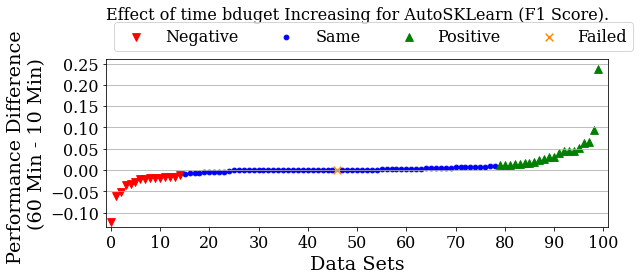

Average and Max loss = -3.6, and -7.4,  from 11 datasets
 50 datasets have the same performance
Average and Max gain = 5.6 and 28.4,  from 38 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.6  &  28.4  &  38  &  50  &  11  &  -3.6  &  -7.4


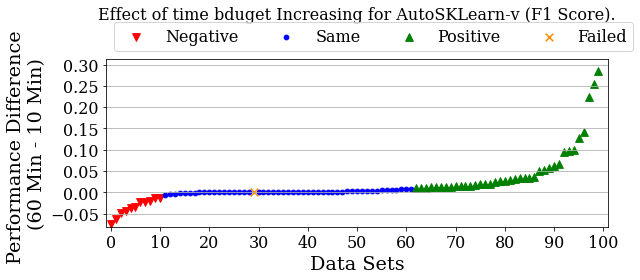

Average and Max loss = -3.7, and -12.5,  from 12 datasets
 57 datasets have the same performance
Average and Max gain = 7.1 and 48.1,  from 30 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
7.1  &  48.1  &  30  &  57  &  12  &  -3.7  &  -12.5


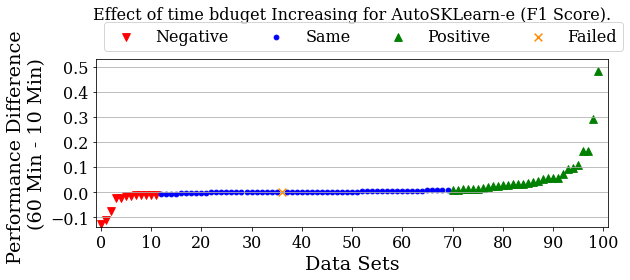

Average and Max loss = -2.8, and -6.5,  from 15 datasets
 62 datasets have the same performance
Average and Max gain = 4.3 and 15.4,  from 22 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.3  &  15.4  &  22  &  62  &  15  &  -2.8  &  -6.5


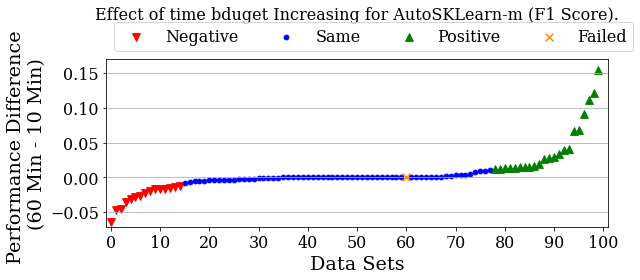

Average and Max loss = -16.0, and -64.6,  from 8 datasets
 60 datasets have the same performance
Average and Max gain = 4.6 and 20.1,  from 19 datasets
3 datasets failed to run on the left side only
0 datasets failed to run on the right side only
10 datasets failed to run on the both sides
4.6  &  20.1  &  19  &  60  &  8  &  -16.0  &  -64.6


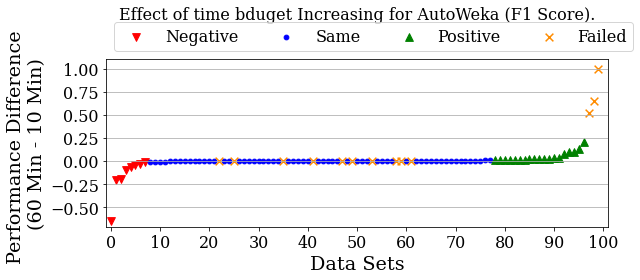

Average and Max loss = -4.6, and -8.0,  from 9 datasets
 21 datasets have the same performance
Average and Max gain = 7.1 and 22.5,  from 7 datasets
35 datasets failed to run on the left side only
3 datasets failed to run on the right side only
25 datasets failed to run on the both sides
7.1  &  22.5  &  7  &  21  &  9  &  -4.6  &  -8.0


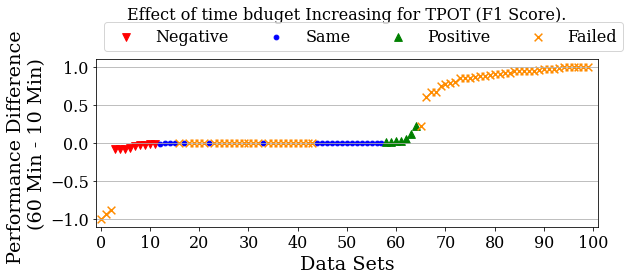

Average and Max loss = -15.1, and -34.2,  from 6 datasets
 34 datasets have the same performance
Average and Max gain = 9.9 and 36.6,  from 10 datasets
23 datasets failed to run on the left side only
7 datasets failed to run on the right side only
20 datasets failed to run on the both sides
9.9  &  36.6  &  10  &  34  &  6  &  -15.1  &  -34.2


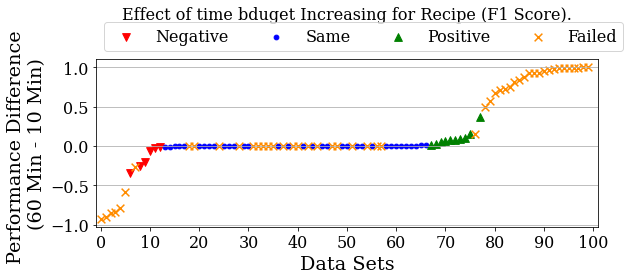

Average and Max loss = -6.6, and -39.0,  from 13 datasets
 68 datasets have the same performance
Average and Max gain = 4.3 and 12.5,  from 9 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
10 datasets failed to run on the both sides
4.3  &  12.5  &  9  &  68  &  13  &  -6.6  &  -39.0


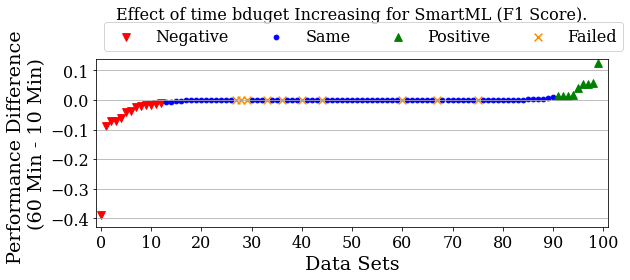

In [93]:
x_label = 'Data Sets'
tools = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m', 'AutoWeka', 'TPOT', 'Recipe', 'SmartML-m']
acc = ['AutoSkLearn', 'AutoSkLearn - Vanilla', 'AutoSkLearn - Vanilla + Ensembling',
         'AutoSkLearn - Vanilla + MetaLearning', 'AutoWeka', 'TPot', 'Receipe', 'SmartML-m']
t =  ['10 Min - F1 Score', '60 Min - F1 Score']
t1 =  ['10 Min', '60 Min']
sheet_path = r'./../AutoML Benchmarking Results.xlsx'
for tool, acc in zip(tools,acc):
    for i in range(1, len(t)):
        for j in range(i):
            fig = Figure(sheet_path, sheet_names=t)
            first = fig.get_sheet()[t[i]].loc[:, acc]
            second = fig.get_sheet()[t[j]].loc[:, acc]
            y_lable = 'Performance Difference \n(' + t1[i] + ' - ' + t1[j] + ')'
            title = 'Effect of time bduget Increasing for '+ tool +' (F1 Score).'
            fig=Figure()
            fig.compare_acc_scatter(first, second, x_label, y_lable, title, fig_size=(9, 4))

# How many times Meta-learning improved the performance and what is the average improvement in AutoSKLearn? (F1 Score)

Average and Max loss = -5.7, and -22.6,  from 8 datasets
 64 datasets have the same performance
Average and Max gain = 4.4 and 16.3,  from 27 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.4  &  16.3  &  27  &  64  &  8  &  -5.7  &  -22.6


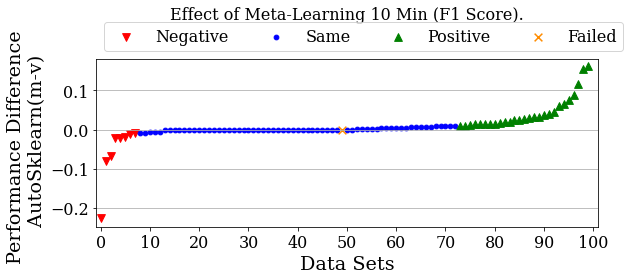

Average and Max loss = -3.9, and -19.7,  from 12 datasets
 52 datasets have the same performance
Average and Max gain = 5.0 and 14.9,  from 35 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
5.0  &  14.9  &  35  &  52  &  12  &  -3.9  &  -19.7


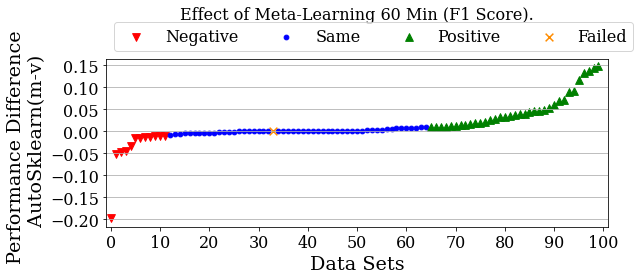

In [94]:
for i in range(len(t)):
    fig = Figure(sheet_path, sheet_names=t)
    meta = fig.get_sheet()[t[i]].loc[:, 'AutoSkLearn - Vanilla + MetaLearning']
    vanilla = fig.get_sheet()[t[j]].loc[:, 'AutoSkLearn - Vanilla']
    y_lable = 'Performance Difference \n AutoSklearn(m-v)'
    title = 'Effect of Meta-Learning '+ t1[i] +' (F1 Score).'
    fig = Figure()
    fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9, 4))

# How many times Esembling improved the performance and what is the average improvement in AutoSKLearn? (F1 Score)

Average and Max loss = -3.4, and -22.6,  from 19 datasets
 58 datasets have the same performance
Average and Max gain = 4.6 and 19.0,  from 22 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
4.6  &  19.0  &  22  &  58  &  19  &  -3.4  &  -22.6


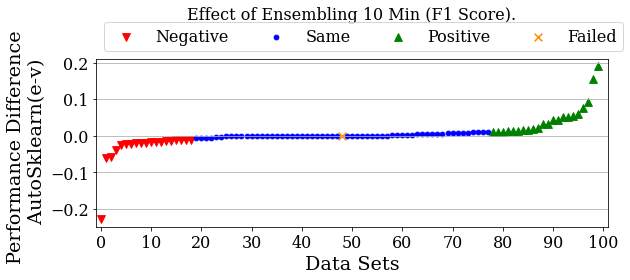

Average and Max loss = -2.7, and -7.4,  from 9 datasets
 52 datasets have the same performance
Average and Max gain = 6.4 and 25.5,  from 38 datasets
0 datasets failed to run on the left side only
0 datasets failed to run on the right side only
1 datasets failed to run on the both sides
6.4  &  25.5  &  38  &  52  &  9  &  -2.7  &  -7.4


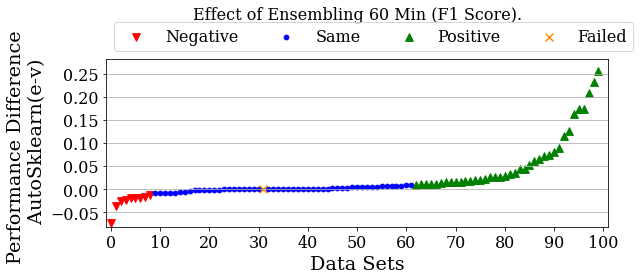

In [95]:
for i in range(len(t)):
    fig = Figure(sheet_path, sheet_names=t)
    ensembling = fig.get_sheet()[t[i]].loc[:, 'AutoSkLearn - Vanilla + Ensembling']
    vanilla = fig.get_sheet()[t[j]].loc[:, 'AutoSkLearn - Vanilla']
    y_lable = 'Performance Difference \n AutoSklearn(e-v)'
    title = 'Effect of Ensembling '+ t1[i] +' (F1 Score).'
    fig=Figure()
    fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9, 4))